# Data analysis: Spinal control of locomotion before and after spinal cord injury
Analysis of results presented in Danner SM, Shepard CT, Hainline C, Shevtosva NA, Rybak IA, Magnuson DSK. Spinal control of locomotion before and after spinal cord injury. 

## Installation of missing packages for Google Colab

In [ ]:

!pip install lmfit numdifftools
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages('lme4')
install.packages('emmeans')
install.packages('sjPlot')
install.packages('lmerTest')
install.packages('pbkrtest')
install.packages('glmmTMB')

## Start here if not using Google Colab

In [54]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import circmean, circstd
import seaborn as sns
sns.set(
    style="white", color_codes=True)
import lmfit
import numdifftools as nd
import inspect
import scipy.stats as scstats
from copy import deepcopy
%load_ext rpy2.ipython

limb_names = ['lh', 'rh', 'lf', 'rf']
%matplotlib inline

#df_raw = pd.read_pickle("./df_raw.pkl")
#df_phases = pd.read_pickle("./df_phases_gaits.pkl")

df_raw = pd.read_hdf("./df_raw.h5",key='df_raw')
df_phases = pd.read_hdf("./df_phases.h5",key='df_phases')

fc = ['#000000','#F7941D','#00A875','#0072BC','#DA70D6']
%config InlineBackend.figure_format = 'png'
mpl.rcParams['figure.dpi']= 300
sns.set_context("paper")


sns.set(font='serif')
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["axes.labelsize"] = 6
plt.rcParams["lines.linewidth"]= 1
plt.rcParams["pdf.fonttype"]= 42
plt.rcParams["ps.fonttype"]= 42
sns.set(font_scale=0.5)


sns.set_style("ticks")
plt.rcParams['svg.fonttype'] = 'none'

colormap = np.array([[0, 0, 0],  # black
                [230, 159, 0],  # orange
                [86, 180, 233],  # sky blue
                [0, 158, 115],  # bluish green
                [240, 228, 66],  # yellow
                [0, 114, 178],  # blue
                [213, 94, 0],  # vermillion
                [204, 121, 167], # reddish purple
                [255, 255, 255]],dtype=float)/255. 

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Figure1: speed-dependent gait expression of intact rats
### Figure 1B: example bout

array([<AxesSubplot:title={'center':'28,1,4'}>,
       <AxesSubplot:ylabel='n. phase diffs (1)'>,
       <AxesSubplot:xlabel='Time (s)', ylabel='Inst. Speed (cm/s)'>],
      dtype=object)

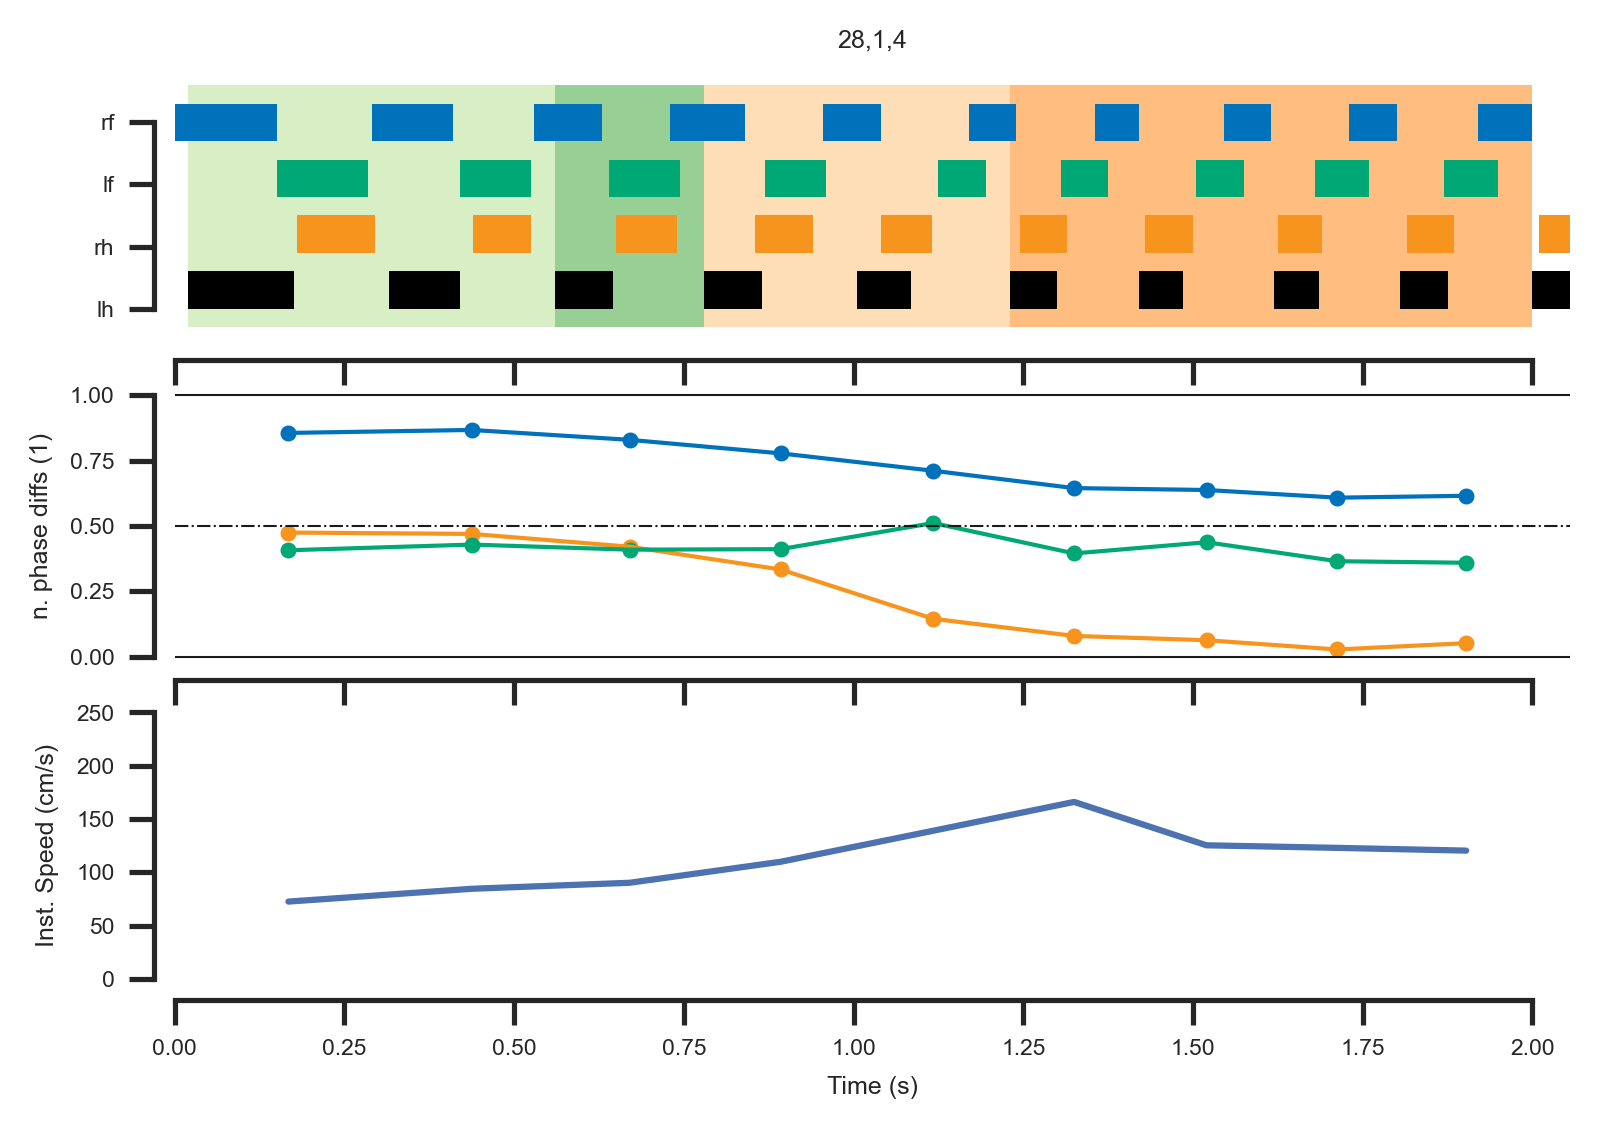

In [2]:
def lp_circ(x,alpha):
    y=np.zeros(len(x))
    y[0]=x[0]
    for i in range(1,len(x)):
        y[i] = y[i-1]+alpha*(np.angle(np.exp(1j*x[i])/np.exp(1j*y[i-1])))
    y=y%(2*np.pi)
    return y

def lp_circ_fc(x,fc,interval=1):
    alpha = (fc*2*np.pi*interval)/(fc*2*np.pi*interval+1)
    return lp_circ(x,alpha)

def ma_dev(x,fc,interval=1):
    ma_x = lp_circ_fc(x,fc,interval)
    return np.mean(np.abs(np.angle(np.exp(1j*(x-ma_x)))))/(np.pi)

def calc_ma_dev(df_,fc=0.2):
    ret={}
    for phase_diff in ['LR_h','hl','diag','LR_f','hl_r','diag_2']:
        ret['r_'+phase_diff]=ma_dev(df_[phase_diff].values*np.pi*2.0,fc)
    return ret

cp=sns.color_palette("Paired", 17)
def plot_circ_line(x,phi,ax,**kwargs):
    
    i_wrap=np.where(np.abs(np.diff(phi))>0.5)[0]
    i_wrap+=1
    i_wrap=np.append(i_wrap,[len(phi)])
    segs = []
    last=0
    if not (i_wrap.size>0):
        segs.append((x,phi))
    else:
        for iw in i_wrap:
            segs.append((x[last:iw],phi[last:iw]))
            phi_=phi[iw-1:iw+1]
            dphi=np.diff(phi_)
            x_=x[iw-1:iw+1]
            dx=np.diff(x_)
            if dphi.size > 0:
                if dphi<0:
                    din=((1-phi_[0])/(dphi%1))*dx
                    if din.size==1:
                        din=din[0]
                    segs.append(([x_[0],x_[0]+din],[phi_[0],1]))
                    segs.append(([x_[0]+din,x_[1]],[0,phi_[1]]))
                elif dphi>0:
                    din=((-phi_[0])/(dphi-1))*dx
                    if din.size==1:
                        din=din[0]
                    segs.append(([x_[0],x_[0]+din],[phi_[0],0]))
                    segs.append(([x_[0]+din,x_[1]],[1,phi_[1]]))
            last=iw
    for x_,phi_ in segs:
        ax.plot(x_,phi_,**kwargs)

def plot_bout(id,rid,bout,do_ma=False,width=0.2,flp=0.125):
    cp=sns.color_palette("Paired", 17)
    fig, axes = plt.subplots(3, 1,sharex='all')
    fig.set_size_inches(6,4)
    dfp=df_phases[(df_phases.ID==id) & (df_phases.RID==rid)&(df_phases.bout==bout)]
    df_bout=df_raw[(df_raw.ID==id) & (df_raw.RID==rid)&(df_raw.bout==bout)]

    t0 = df_bout.onset.iloc[0]
    xg = [(row.onset_lh-t0,row.phase_dur) for (index,row) in dfp.iterrows()]
    yg = (0.9,4*width*1.5+0.1)
    
    col = [cp[k] for k in dfp.gaits.cat.codes.values]
    axes[0].broken_barh(xg,yg,facecolors=col,lw=0,alpha=0.5)
    xmax=0
    for j in range(4):
        xranges = [(row.onset-t0,row.offset-row.onset) for (index,row) in df_bout[df_bout.leg==j].iterrows()]
        yranges = (1.0+j*width*1.5,width)
        axes[0].broken_barh(xranges,yranges,facecolors=fc[j],lw=0)
        xmax_=xranges[-1][0]+xranges[-1][1]
        if xmax_>xmax:
            xmax=xmax_
    x = dfp.onset_lh-t0+dfp.phase_dur*0.5
    for phd,color in zip([dfp.LR_h,dfp.hl,dfp.diag],[fc[1],fc[2],fc[3],fc[0]]):
        plot_circ_line(x.values,phd.values,axes[1],c=color,lw=1)
        axes[1].scatter(x,phd,c=color,s=8)
        if do_ma:
            plot_circ_line(x.values,lp_circ_fc(phd.values*2*np.pi,flp)/(2*np.pi),axes[1],c=color,lw=1,alpha=0.5)
    
    axes[1].plot([0,2.5],[0]*2,'k',lw=0.5)
    axes[1].plot([0,2.5],[0.5]*2,'-.k',lw=0.5)
    axes[1].plot([0,2.5],[1]*2,'k',lw=0.5)
    
    axes[1].set_ylim((-0.01,1.01))

    axes[2].plot(dfp.onset_lh - df_bout.iloc[0].onset + 0.5 * dfp.phase_dur,dfp.speed)
    axes[2].set_ylim(0,250)
    axes[0].set_title(str(id)+","+str(rid)+","+str(bout))
    axes[2].set_xlim(0,xmax)

    axes[0].set_yticks(np.linspace(1,2,4))
    axes[0].set_yticklabels(['lh','rh','lf','rf'])
    axes[2].set_ylabel('Inst. Speed (cm/s)')
    axes[1].set_ylabel('n. phase diffs (1)')
    axes[2].set_xlabel('Time (s)')
    sns.despine(offset=5, trim=True)
    return axes
    
# plot bout by ID, RID, and bout number
plot_bout(28,1,4);



### Figure 1 C-F: Letter-value plots of locomotor speed (C), frequency (D), stride length (E), and duty factor (F) for each gait (walk, trot, canter, gallop, half-bound and bound) of intact rats

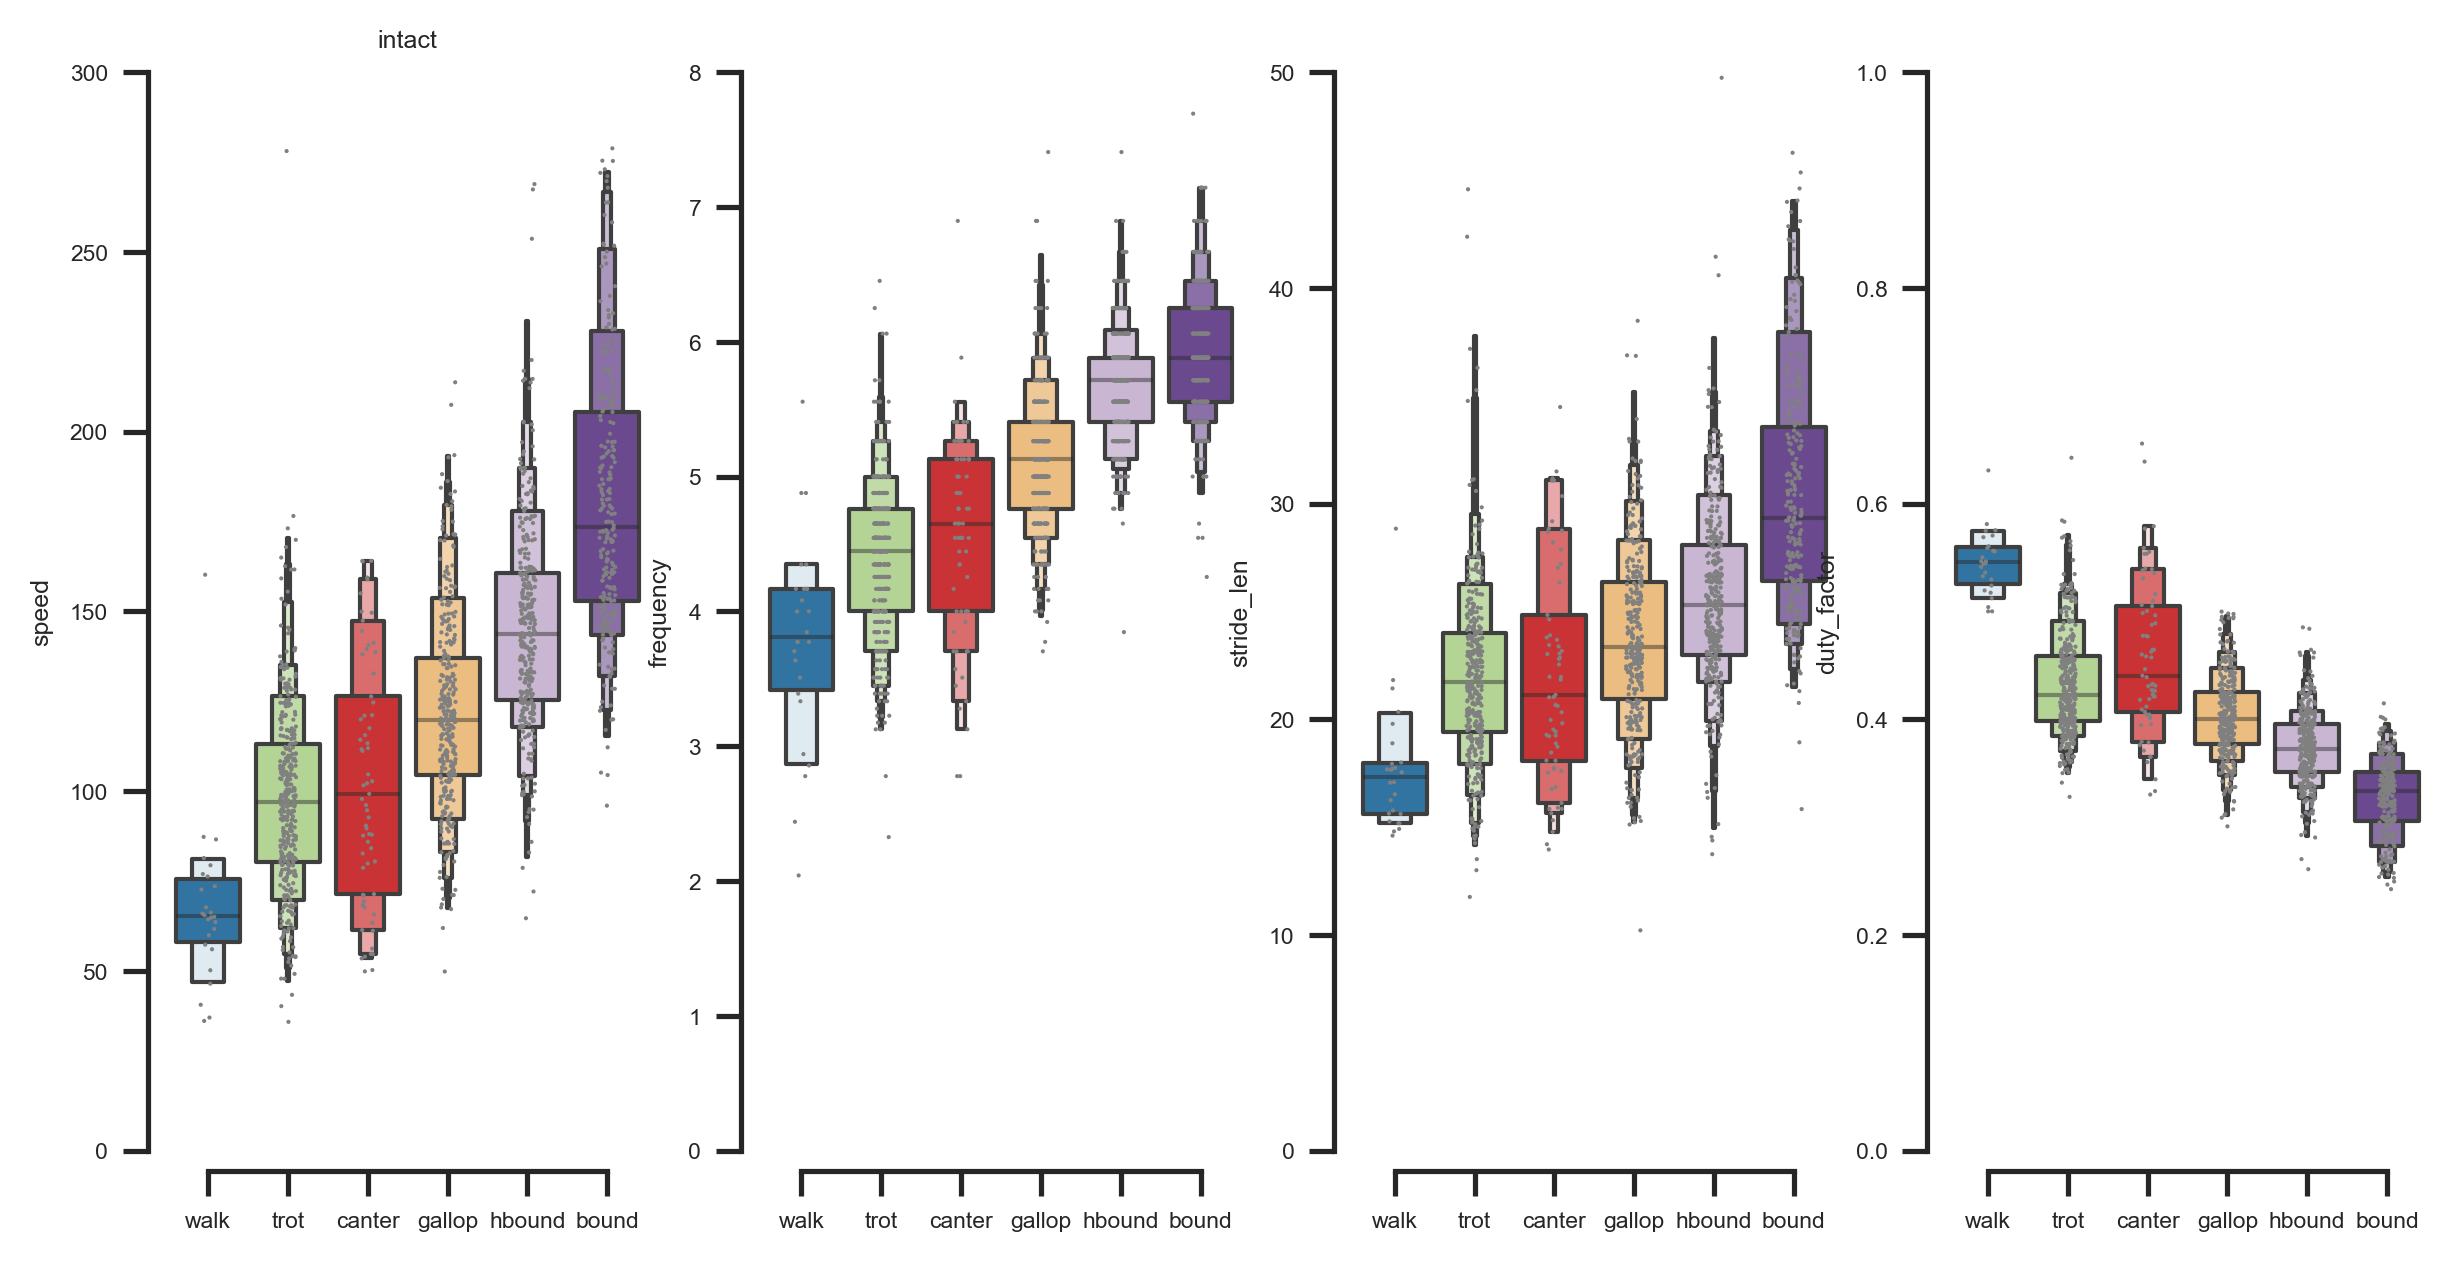

In [3]:
cp=sns.color_palette("Paired", 20)
cp=cp[1:]
cp.pop(2)
cp.pop(2)
cp.pop(4)

sci ='intact'

df = df_phases.loc[(df_phases.SCI == sci),['ID','gaits','frequency','speed','stride_len','duty_factor']].dropna()
gaits_= pd.Categorical(
        [np.nan]*len(df.gaits), ['walk', 'trot','canter','gallop', 'hbound', 'bound'])
gaits_[df.gaits=='walk']='walk'
gaits_[df.gaits=='trot']='trot'
gaits_[df.gaits=='canter']='canter'
gaits_[df.gaits=='gallop']='gallop'
gaits_[df.gaits=='hbound']='hbound'
gaits_[df.gaits=='bound']='bound'
pl=['speed','frequency','stride_len','duty_factor']
ylims=[[0,300],[0,8],[0,50],[0,1],[0,1]]  
fig, ax = plt.subplots(1,4)
fig.set_size_inches(8, 4., forward=True)
plt.tight_layout()
for a,p,yl in zip(ax,pl,ylims):
    a = sns.boxenplot(
            y=df[p],x=gaits_,
            palette=cp,ax=a,linewidth=1,showfliers=False,k_depth='trustworthy')
    a = sns.stripplot(y=df[p],x=gaits_,
                   size=1, jitter=True,linewidth=0, color="gray",ax=a)
    a.set_ylim(yl)
sns.despine(offset=5, trim=True) 
ax[0].set_title(sci)
df['gaits_']=gaits_

#### Stats: Figure 1C–F
Comparison of speed, frequency, stride length, and duty factor between gaits

Linear mixed model fit by REML ['lmerMod']
Formula: speed ~ gaits_ + (1 | ID)
   Data: df

REML criterion at convergence: 13044.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9482 -0.6428 -0.0954  0.5373  6.2048 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 177.3    13.31   
 Residual             793.9    28.18   
Number of obs: 1369, groups:  ID, 17

Fixed effects:
             Estimate Std. Error t value
(Intercept)    77.148      6.564  11.753
gaits_trot     23.352      5.940   3.931
gaits_canter   29.104      6.601   4.409
gaits_gallop   45.274      5.942   7.620
gaits_hbound   63.916      5.988  10.673
gaits_bound    96.775      6.229  15.537

Correlation of Fixed Effects:
            (Intr) gts_tr gts_cn gts_gl gts_hb
gaits_trot  -0.838                            
gaits_cantr -0.730  0.810                     
gaits_gallp -0.837  0.930  0.810              
gaits_hbond -0.838  0.923  0.807  0.928       
gaits_bound -0.812  0.885

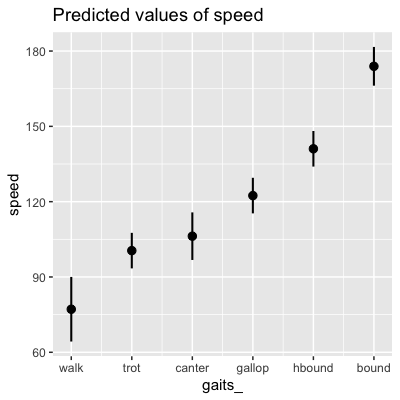

In [4]:
%%R -i df -w 4 -h 4 --units in -r 100
library(lme4)
library(emmeans)

mod1 <- lmer(speed ~ gaits_ + (1|ID) ,data=df)

print(summary(mod1))

print(joint_tests(mod1))
emm_ = emmeans(mod1,pairwise ~gaits_,data=df)
print(emm_) 
print(contrast(emmeans(mod1,~gaits_), "consec"))

print(plot_model(mod1,type='pred'))

Linear mixed model fit by REML ['lmerMod']
Formula: frequency ~ gaits_ + (1 | ID)
   Data: df

REML criterion at convergence: 2099.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5357 -0.5855  0.0275  0.5367  7.3129 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 0.0784   0.2800  
 Residual             0.2576   0.5075  
Number of obs: 1369, groups:  ID, 17

Fixed effects:
             Estimate Std. Error t value
(Intercept)    3.9762     0.1234  32.224
gaits_trot     0.4873     0.1071   4.551
gaits_canter   0.6690     0.1189   5.626
gaits_gallop   1.1341     0.1071  10.588
gaits_hbound   1.5949     0.1080  14.770
gaits_bound    1.7579     0.1124  15.645

Correlation of Fixed Effects:
            (Intr) gts_tr gts_cn gts_gl gts_hb
gaits_trot  -0.803                            
gaits_cantr -0.700  0.810                     
gaits_gallp -0.803  0.930  0.810              
gaits_hbond -0.803  0.923  0.807  0.928       
gaits_bound -0.778  0.

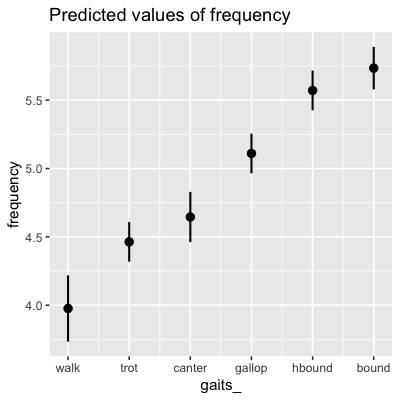

In [5]:
%%R -i df -w 4 -h 4 --units in -r 100

mod1 <- lmer(frequency ~ gaits_ + (1|ID) ,data=df)

print(summary(mod1))
print(joint_tests(mod1))
emm_ = emmeans(mod1,pairwise ~gaits_,data=df)
print(emm_) 

print(plot_model(mod1,type='pred'))

Linear mixed model fit by REML ['lmerMod']
Formula: stride_len ~ gaits_ + (1 | ID)
   Data: df

REML criterion at convergence: 7978.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1981 -0.6239 -0.0915  0.5078  8.4416 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept)  2.451   1.566   
 Residual             19.422   4.407   
Number of obs: 1369, groups:  ID, 17

Fixed effects:
             Estimate Std. Error t value
(Intercept)   18.7731     0.9694  19.366
gaits_trot     3.4339     0.9270   3.704
gaits_canter   3.6665     1.0318   3.554
gaits_gallop   5.0021     0.9271   5.395
gaits_hbound   6.3209     0.9339   6.769
gaits_bound   11.1982     0.9702  11.542

Correlation of Fixed Effects:
            (Intr) gts_tr gts_cn gts_gl gts_hb
gaits_trot  -0.885                            
gaits_cantr -0.772  0.810                     
gaits_gallp -0.885  0.930  0.811              
gaits_hbond -0.885  0.924  0.807  0.928       
gaits_bound -0.859  0

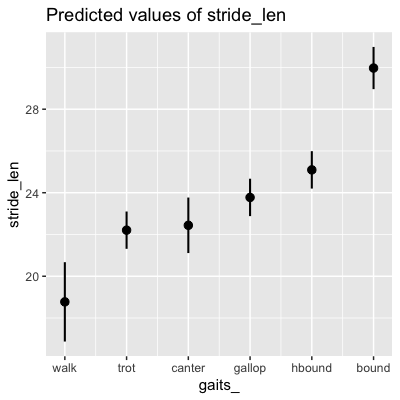

In [6]:
%%R -i df -w 4 -h 4 --units in -r 100

mod1 <- lmer(stride_len ~ gaits_ + (1|ID),data=df)

print(summary(mod1))
print(joint_tests(mod1))
emm_=emmeans(mod1,pairwise ~gaits_,data=df)

print(emm_) 
print(plot_model(mod1,type='pred'))

Linear mixed model fit by REML ['lmerMod']
Formula: duty_factor ~ gaits_ + (1 | ID)
   Data: df

REML criterion at convergence: -5042.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1562 -0.6552 -0.0863  0.5973  4.6013 

Random effects:
 Groups   Name        Variance  Std.Dev.
 ID       (Intercept) 0.0006604 0.02570 
 Residual             0.0013588 0.03686 
Number of obs: 1369, groups:  ID, 17

Fixed effects:
              Estimate Std. Error t value
(Intercept)   0.515495   0.009744  52.903
gaits_trot   -0.084667   0.007784 -10.877
gaits_canter -0.072043   0.008639  -8.339
gaits_gallop -0.114389   0.007788 -14.689
gaits_hbound -0.136572   0.007853 -17.391
gaits_bound  -0.177048   0.008175 -21.658

Correlation of Fixed Effects:
            (Intr) gts_tr gts_cn gts_gl gts_hb
gaits_trot  -0.739                            
gaits_cantr -0.645  0.810                     
gaits_gallp -0.739  0.930  0.810              
gaits_hbond -0.740  0.923  0.807  0.928       
gaits_bou

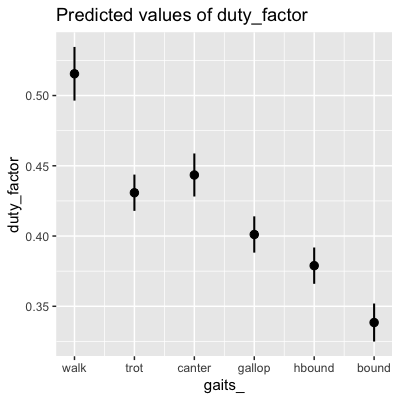

In [7]:
%%R -i df -w 4 -h 4 --units in -r 100 -o emm

mod1 <- lmer(duty_factor ~ gaits_ + (1|ID) ,data=df)

print(summary(mod1))

print(joint_tests(mod1))
emm_=emmeans(mod1,pairwise ~gaits_,data=df)
print(emm_) 

print(plot_model(mod1,type='pred'))

### Figure 1 G–I:(G) Average stance phases for each gait. (H) Circular plots of average normalized phase differences for each gait. (I) Average foot position.

In [8]:
def plot_barh_polar(ax,xranges,yranges,fc_,n=360):
    for xrange in xranges:
        xrange_ = [(x,1.01*2*np.pi/n) for x in np.arange(xrange[0],xrange[0]+xrange[1],2*np.pi/n)]
        ax.broken_barh(xrange_,yranges,facecolors=fc_,edgecolors=None,linewidths=0)

def circ_r(a,low=0,high=1):
    a=(a-low)*2*np.pi/(high-low)
    return np.abs(np.sum(np.exp(1j*a)))/len(a)

def plot_avg_gait_stance(df,label,ax):
    df = df[['LR_h','hl','diag','duty_factor_lh','duty_factor_rh','duty_factor_rf','duty_factor_lf','frequency','phase_dur']].dropna()

    lr = circmean(df.LR_h,1,0)
    hl = circmean(df.hl,1,0)
    diag = circmean(df.diag,1,0)
    duty_factor = [np.mean(df.duty_factor_lh),
                   np.mean(df.duty_factor_rh),
                   np.mean(df.duty_factor_lf),
                   np.mean(df.duty_factor_rf)]
    frequency = np.mean(df.frequency)
    
    phases=[0.0,lr,hl,diag]
    phases_sd=[0.0,circstd(df.LR_h,1,0),circstd(df.hl,1,0),circstd(df.diag,1,0)]
    print("{:10s}\tLR={:1.3f}+-{:1.3f}, HL={:1.3f}+-{:1.3f}, diag={:1.3f}+-{:1.3f}".format(\
        label,phases[1],phases_sd[1],phases[2],phases_sd[2],phases[3],phases_sd[3]))
    period = 1/frequency
    width = 0.2
    
    for j in range(4):
        scale = np.mean(df.phase_dur)
        xranges = [[phases[j]*scale,duty_factor[j]*scale],[phases[j]*scale-scale,duty_factor[j]*scale]]
        xranges = [[x[0],x[1]] if ((x[1]+x[0])<scale) else [x[0],scale-x[0]] for x in xranges]
        yranges = (1.0+j*width*1.5,width)
        ax.broken_barh(xranges,yranges,facecolors=fc[j],lw=0)
        xranges = [[phases[j]*scale-phases_sd[j]*scale,phases_sd[j]*scale],[phases[j]*scale+duty_factor[j]*scale,phases_sd[j]*scale]]
        xranges = [[x[0],x[1]] if (x[0]<scale) else [x[0]-scale,x[1]] for x in xranges]
        yranges = (1.0+j*width*1.5+0.45*width,width*0.1)
        #ax.broken_barh(xranges,yranges,facecolors=fc[j],lw=0)
        for xr in xranges:
            ax.plot([xr[0],xr[0]+xr[1]],[1.0+j*width*1.5+0.5*width]*2,lw=1,c=fc[j])
    ax.axvline(x=scale,c='k',lw=0.5)
    ax.axvline(x=0,c='k',lw=0.5)
    ax.set_xlim((0,0.31))
    ax.set_yticks([1.0+j*width*1.5+width*0.5 for j in range(4)])
    ax.set_yticklabels(['lh','rh','lf','rf'])
    ax.set_title(str(label) +' '+ str(len(df)))

def plot_avg_gait_phase(df,label,ax):
    df = df[['LR_h','LR_f','hl','diag','duty_factor_lh','duty_factor_rh','duty_factor_rf','duty_factor_lf','frequency','phase_dur']].dropna()
    lr = circmean(df.LR_h,1,0)
    hl = circmean(df.hl,1,0)
    diag = circmean(df.diag,1,0)
    lr_fl = circmean(df.LR_f,1,0)
    duty_factor = [np.mean(df.duty_factor_lh),
                   np.mean(df.duty_factor_rh),
                   np.mean(df.duty_factor_lf),
                   np.mean(df.duty_factor_rf)]
    frequency = np.mean(df.frequency)
    phases=np.array([0.0,lr,hl,diag,lr_fl])
    phase_r=np.array([1.0,circ_r(df.LR_h),circ_r(df.hl),circ_r(df.diag),circ_r(df.LR_f)])
    
    period = 1/frequency
    width = 0.3
    
    for j in range(len(phase_r)):        
        ax.plot([phases[j]*2*np.pi]*2,[0,phase_r[j]],fc[j])
    ax.scatter(phases*2*np.pi,phase_r,c=fc)
    ax.set_ylim((0,1.1))
    ax.set_yticks([1])
    ax.set_yticklabels([""])
        
    
    #for ax_ in ax:
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
        
    ax.set_title(str(label) )
    ax.set_thetagrids(
                np.linspace(0.0, 360, 9)[:-1], ["0", "", ".25", "", ".5", "", ".75",""],
                fontsize=10)
    
def plot_avg_footp(df,label,ax):
    x=df[['x_stance_lh','x_stance_rh','x_stance_lf','x_stance_rf']].values
    y=df[['y_stance_lh','y_stance_rh','y_stance_lf','y_stance_rf']].values
    sw=df[['step_width_x_lh','step_width_x_rh','step_width_x_lf','step_width_x_rf']].values
    ne=np.concatenate((np.diff(df.index.values)==1,[False]))
    x=x[ne,:]
    y=y[ne,:]
    sw=sw[ne,:]

    sw2=np.sum(np.sign(sw),1)
    y[sw2<0.0]=y[sw2<0.0]*-1.0
    x[sw2<0.0]=x[sw2<0.0]*-1.0
    sw[sw2<0.0]=sw[sw2<0.0]*-1.0
    
    x=x-np.nanmean(x,axis=1,keepdims=True)
    x=(x.transpose()-np.nanmedian(x[:,0])).transpose()
    y=y-np.nanmean(y,axis=1,keepdims=True)
    y=(y.transpose()-np.nanmedian(y[:,0])).transpose()
    
    ax.set_xlim([-7.5,35])
    ax.set_ylim([-6.5,1.5])
    ax.set_aspect('equal')
    
    for i in range(4):
        ax.scatter(np.nanmedian(x[:,i]),np.nanmedian(y[:,i]),s=50,c=fc[i],lw=0)
        ax.scatter(np.nanmedian(x[:,i]+sw[:,i]),np.nanmedian(y[:,i]),s=50,c=fc[i],alpha=0.25,lw=0)
        ax.scatter(np.nanmedian(x[:,i]-sw[:,i]),np.nanmedian(y[:,i]),s=50,c=fc[i],alpha=0.25,lw=0)
        
    lr = circmean(df.LR_h,1,0)
    hl = circmean(df.hl,1,0)
    diag = circmean(df.diag,1,0)
    ph = [['lh',0,0],['rh',lr,1],['lf',hl,2],['rf',diag,3]]
    ph = sorted(ph,key=lambda x: x[1])
    #print(ph)
    ax.set_title(str(label))
    j=1
    for i in range(0,4): 
        if i>0:
            if (ph[i][1]-ph[i-1][1])<0.1:
                j=j-1
        ax.text(np.nanmedian(x[:,ph[i][2]]),np.nanmedian(y[:,ph[i][2]])-0.5,str(j),horizontalalignment='center',verticalalignment='top')
        j=j+1

def plot_gait_properties(group,gaits):
    fig = plt.figure(constrained_layout=True)
    fig.set_size_inches(len(gaits)*3, 4, forward=True)
    gs = gridspec.GridSpec( 3,len(gaits), figure=fig)

    plt.tight_layout()
    for i,gait_ in enumerate(gaits):
        df_=df_phases[(df_phases.SCI==group)&(df_phases.gaits_all2==gait_)]
        if len(df_)>10:
            label=gait_
            ax=[]
            ax.append( fig.add_subplot(gs[0, i]))
            ax.append( fig.add_subplot(gs[1, i]))
            ax.append( fig.add_subplot(gs[2, i],projection='polar'))

            plot_avg_gait_stance(df_,label,ax[0])
            
            plot_avg_gait_phase(df_,"",ax[2])
            
            if label in 'bound':
                # if LR_h > 0. and < 0.5 the position of the right hind foot can be of the next step and cause problems in the average
                df_=df_[(df_.LR_h>0.5)]
            if label in 'trot':
                df_=df_[(df_.diag>0.5)]
                
            plot_avg_footp(df_,label,ax[1])
            sns.despine(ax=ax[1],offset=5,trim=True)
            sns.despine(ax=ax[0],offset=5,trim=True)

    return fig

walk_lat  	LR=0.462+-0.040, HL=0.337+-0.045, diag=0.819+-0.041
trot      	LR=0.488+-0.060, HL=0.473+-0.046, diag=0.975+-0.070
canter    	LR=0.627+-0.067, HL=0.411+-0.057, diag=0.019+-0.049
canter_2  	LR=0.297+-0.083, HL=0.361+-0.041, diag=0.735+-0.048
trans_1   	LR=0.789+-0.073, HL=0.560+-0.037, diag=0.188+-0.062
trans_2   	LR=0.237+-0.093, HL=0.444+-0.045, diag=0.764+-0.059
hbound    	LR=0.078+-0.041, HL=0.391+-0.047, diag=0.660+-0.041
hbound_2  	LR=0.948+-0.043, HL=0.609+-0.043, diag=0.356+-0.058
bound     	LR=0.020+-0.035, HL=0.608+-0.092, diag=0.587+-0.093


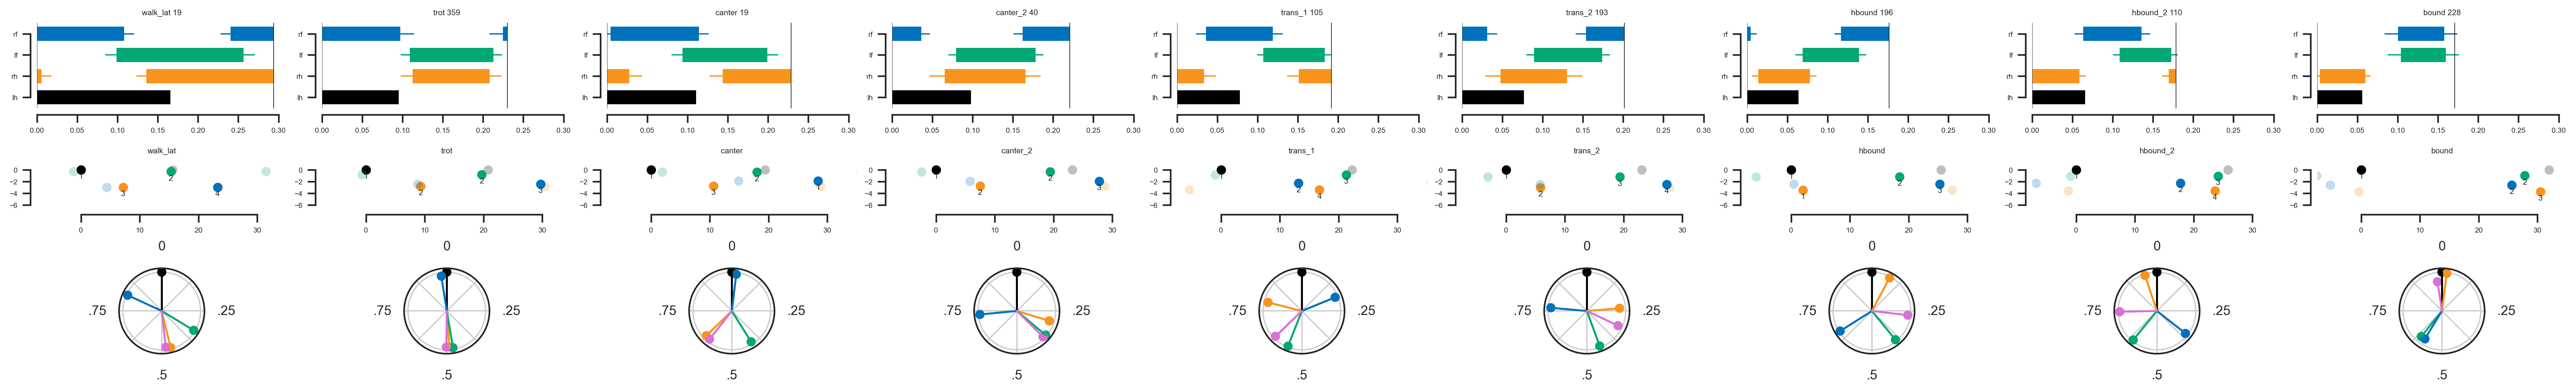

In [9]:
fig = plot_gait_properties('intact', ['walk_lat','trot', 'canter','canter_2','trans_1','trans_2','hbound','hbound_2','bound'])
#walk_lat: lateral-sequence walk
#trot:     trot
#canter:   canter (left lead)
#canter_2: canter (right lead)
#trans_1:  gallop with transverse sequence (left lead)
#trans_2:  gallop with transverse sequence (right lead)
#hbound:   half-bound gallop (right lead)
#hbound_2: half-bound gallop (left lead)
#bound:    bound

### Figure 1---figure supplement 1: Number of limbs on the ground as a proportion of the step cycle for each gait

          nolimb   onelimb   twolimb  threelimb  fourlimb
gaits_                                                   
walk    0.000000  0.042469  0.728778   0.225770  0.002983
trot    0.063559  0.172861  0.737612   0.025755  0.000213
canter  0.006981  0.274466  0.609294   0.108319  0.000940
gallop  0.013073  0.385755  0.576452   0.024496  0.000224
hbound  0.026529  0.482315  0.465536   0.025620  0.000000
bound   0.228712  0.258811  0.505474   0.006868  0.000134


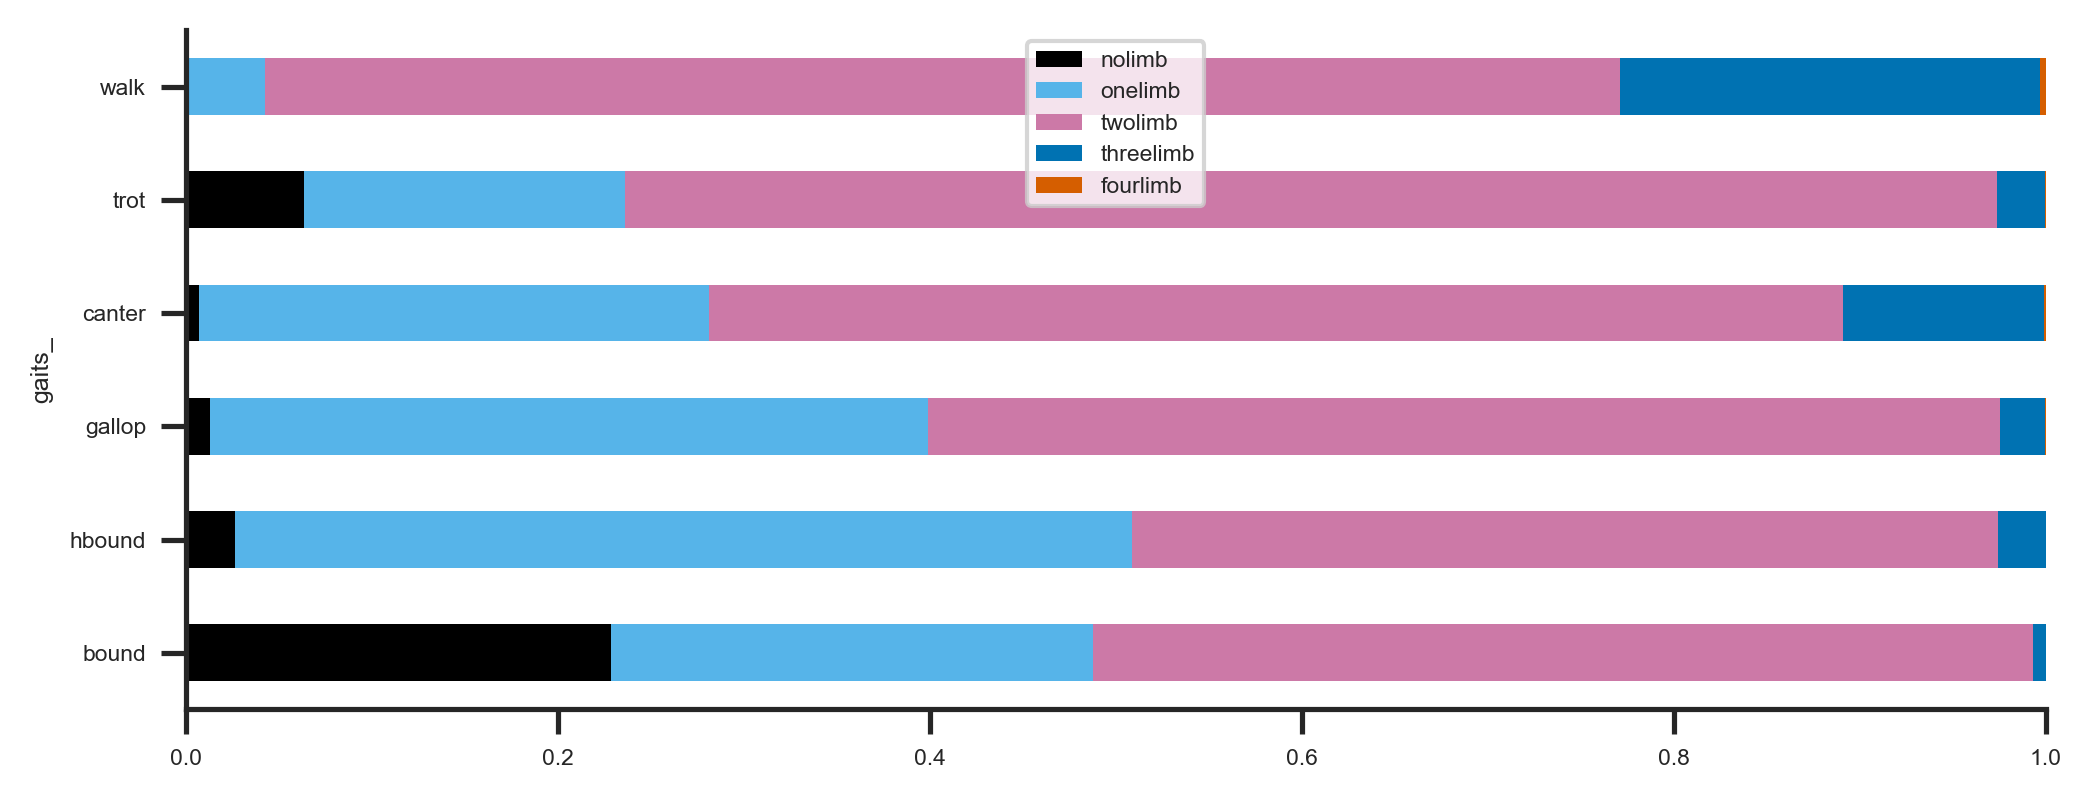

In [10]:
df_ = df_phases
df_['gaits_']=df.gaits_

group=df_[['gaits_','nolimb','onelimb','twolimb','threelimb','fourlimb']].groupby(['gaits_'])

print(group.mean())

group.mean().plot.barh(stacked=True,color= colormap[[0,2,7,5,6,4]],lw=0)
plt.gcf().set_size_inches(8,3)
plt.xlim([0,1])
#plt.gca().get_legend().remove()
sns.despine()
plt.gca().invert_yaxis()

## Figure 2: Prevalence of gaits and gait parameters in intact animals and after contusion or hemisection injury. 

Counts
SCI     contusion  hemisection  intact   All
gaits                                       
nd             49           21      11    81
walk          105           24      29   158
trot          327          151     381   859
run            66            7      15    88
pace           50            0       0    50
canter         26           79      69   174
gallop         17          172     342   531
hbound          0            8     362   370
bound           0            6     239   245
All           640          468    1448  2556


Prevalences
SCI     contusion  hemisection    intact
gaits                                   
nd       0.076563     0.044872  0.007597
walk     0.164062     0.051282  0.020028
trot     0.510938     0.322650  0.263122
run      0.103125     0.014957  0.010359
pace     0.078125     0.000000  0.000000
canter   0.040625     0.168803  0.047652
gallop   0.026562     0.367521  0.236188
hbound   0.000000     0.017094  0.250000
bound    0.000000     0.01282

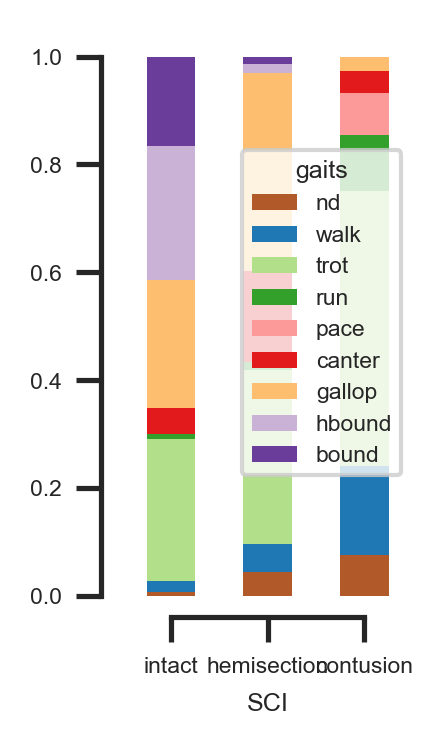

In [11]:
gaits_ = 'gaits'

ct = pd.crosstab(df_phases[gaits_], df_phases.SCI, normalize='columns')
stacked = ct.stack().reset_index().rename(columns={0: 'value'})

stacked.SCI = pd.Categorical(
    stacked.SCI,
    categories=["intact",  "hemisection", "contusion"],
    ordered=False)
stacked = stacked.rename(index=str, columns={'value': 'occurance'})
chi2, p, _,_ = scstats.chi2_contingency(pd.crosstab(df_phases[gaits_], df_phases.SCI))
print('Counts')
print(pd.crosstab(df_phases[gaits_], df_phases.SCI,margins=True))
print('\n\nPrevalences')
print(pd.crosstab(df_phases[gaits_], df_phases.SCI,normalize='columns'))

cp=sns.color_palette("Paired", 20)
cp[0]=cp[11]
cp.pop(7)

pivot_df = stacked.pivot(index='SCI', columns=gaits_, values='occurance')
pivot_df.plot.bar(stacked=True, color=cp,figsize=(1.25,2.5),linewidth=0)
sns.despine(offset=5,trim=True )


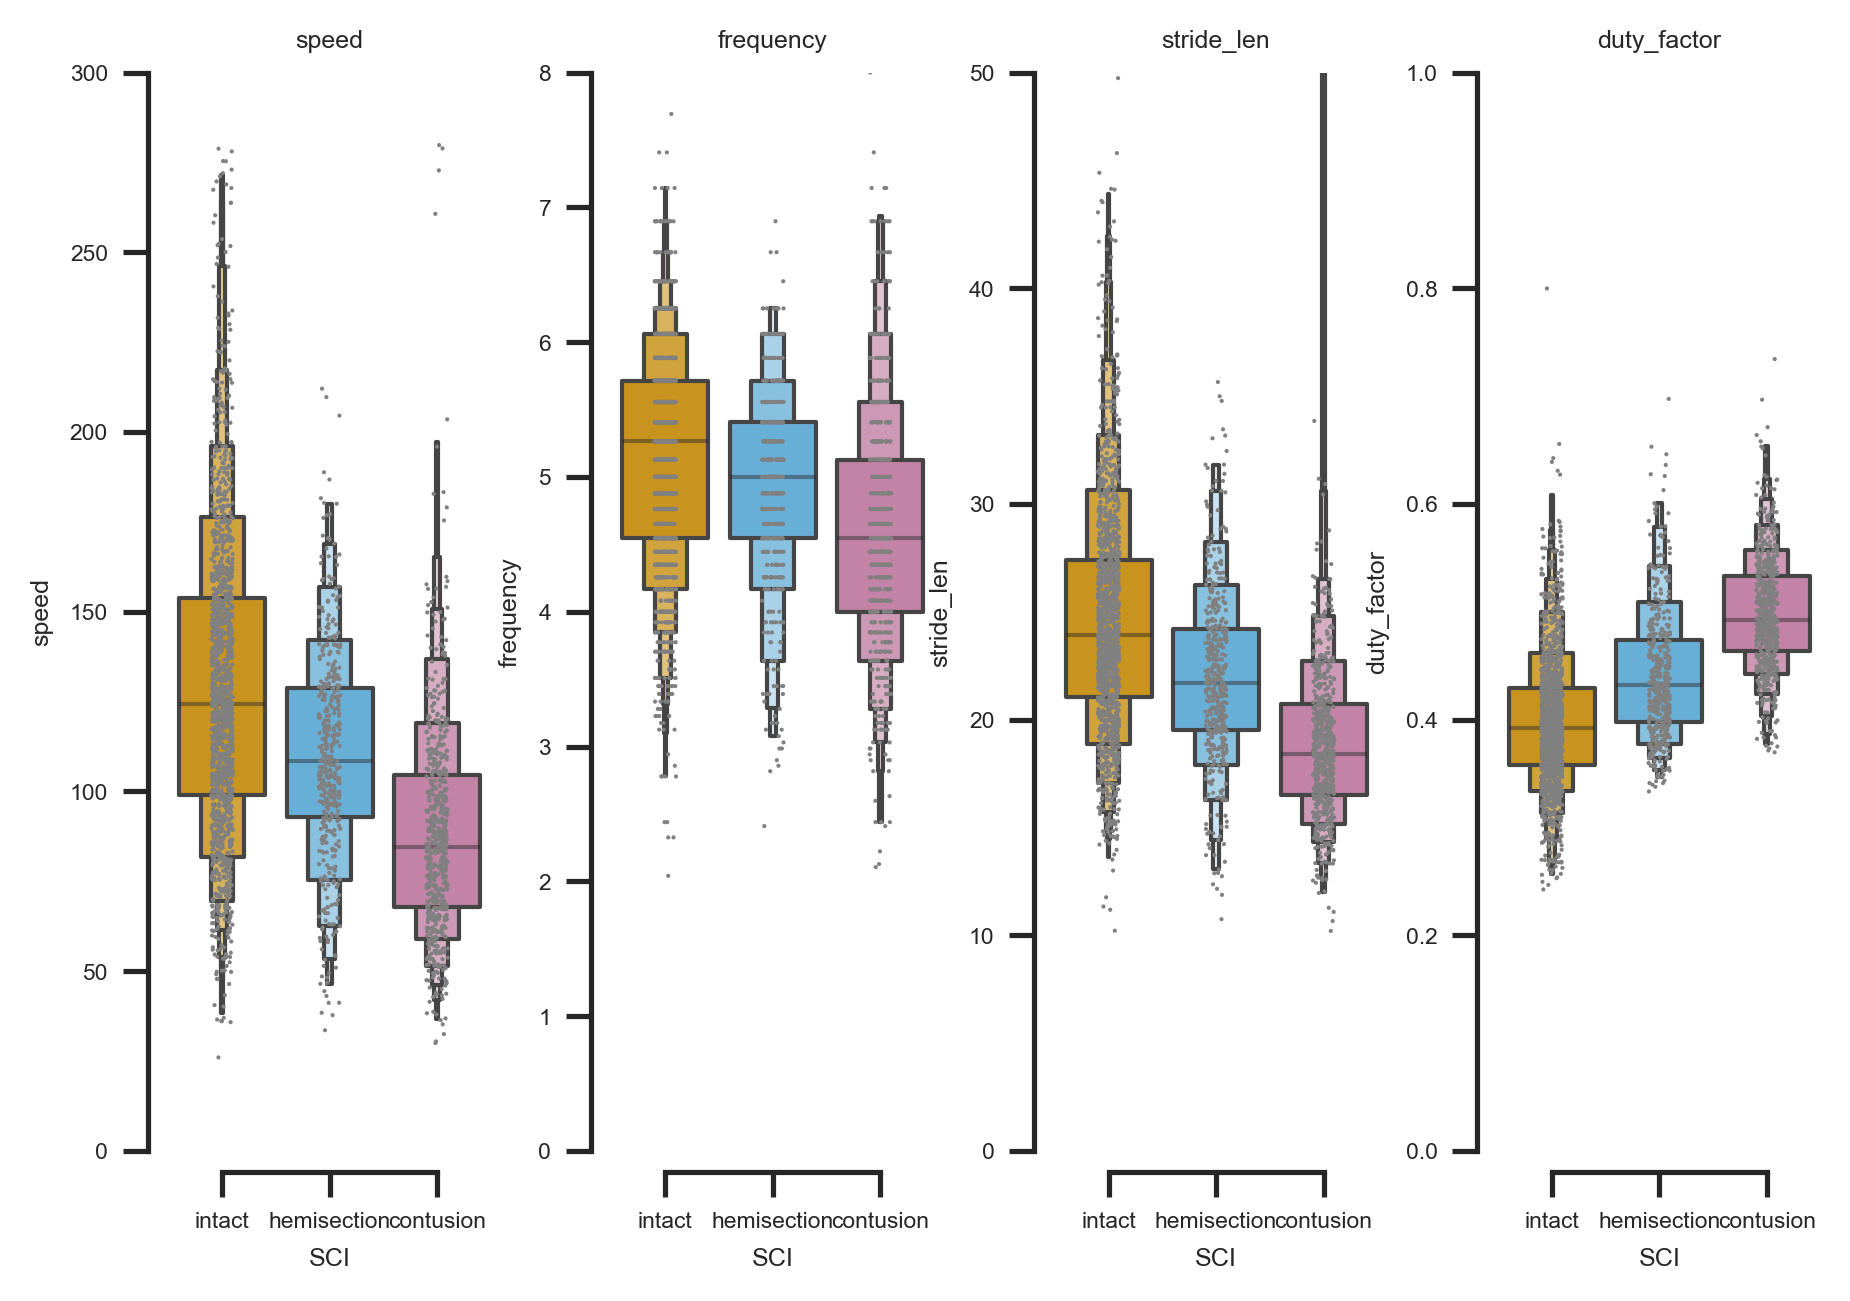

In [12]:
df = df_phases[['ID','SCI','frequency','speed','stride_len','duty_factor']].dropna()
df.SCI = pd.Categorical(df.SCI,['intact', 'hemisection','contusion'])
pl=['speed','frequency','stride_len','duty_factor']
ylims=[[0,300],[0,8],[0,50],[0,1],[0,1],[0,1],[0,1]]  
fig, ax = plt.subplots(1,len(pl))
fig.set_size_inches(6, 4., forward=True)
plt.tight_layout()
for a,p,yl in zip(ax,pl,ylims):
    a = sns.boxenplot(
            y=df[p],x=df.SCI,
            ax=a,linewidth=1,showfliers=False,palette=[colormap[1],colormap[2],colormap[7]])
    a = sns.stripplot(y=df[p],x=df.SCI,
                size=1, jitter=True,linewidth=0, color="gray",ax=a)
    a.set_ylim(yl)
    a.set_title(p)
sns.despine(offset=5, trim=True) 

### Stats for figure 2B–E
Comparison of speed, frequency, stride length, and duty factor between intact, hemisected and contused rats.

In [13]:
dfpsci = df_phases[['stride_len','speed','ID','RID','SCI','frequency','phase_dur','duty_factor','duty_factor_f','duty_factor_h','gaits']].dropna()
dfpsci.SCI=pd.Categorical(dfpsci.SCI,categories=['intact','contusion','hemisection'])

 model term df1  df2 F.ratio p.value
 SCI          2 2271  13.541  <.0001

$emmeans
 SCI         emmean   SE   df lower.CL upper.CL
 intact         127 6.83 2271    113.6    140.4
 contusion       85 7.17 2271     70.9     99.1
 hemisection    110 2.62 2271    105.2    115.5

Confidence level used: 0.95 

$contrasts
 contrast                estimate   SE   df t.ratio p.value
 intact - contusion          42.0 8.07 2271   5.204  <.0001
 intact - hemisection        16.7 6.48 2271   2.574  0.0273
 contusion - hemisection    -25.3 7.36 2271  -3.441  0.0017

P value adjustment: tukey method for comparing a family of 3 estimates 

$SCI



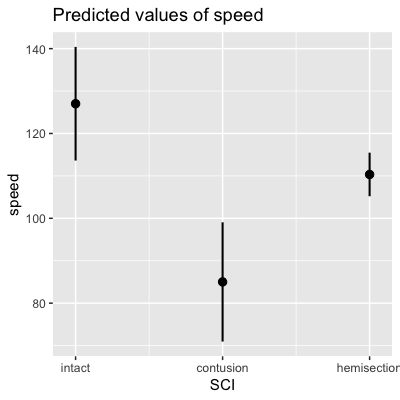

In [14]:
%%R -i dfpsci -w 4 -h 4 --units in -r 100
library(glmmTMB)
mod1 <- glmmTMB(speed ~ SCI + (1+SCI|ID) ,data=dfpsci,zi=~0,disp=~SCI)

print(joint_tests(mod1))
print(emmeans(mod1,pairwise ~SCI,data=dfpsci,lmer.df = "asymptotic")) 


print(plot_model(mod1,type='pred'))


 model term df1  df2 F.ratio p.value
 SCI          2 2271   3.457  0.0317

$emmeans
 SCI         emmean     SE   df lower.CL upper.CL
 intact        5.08 0.1385 2271     4.80     5.35
 contusion     4.49 0.2502 2271     4.00     4.98
 hemisection   4.95 0.0832 2271     4.78     5.11

Confidence level used: 0.95 

$contrasts
 contrast                estimate    SE   df t.ratio p.value
 intact - contusion         0.586 0.237 2271   2.473  0.0359
 intact - hemisection       0.130 0.103 2271   1.269  0.4131
 contusion - hemisection   -0.456 0.243 2271  -1.875  0.1463

P value adjustment: tukey method for comparing a family of 3 estimates 

$SCI



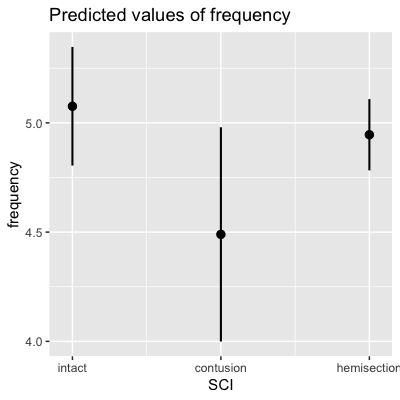

In [15]:
%%R -i dfpsci -w 4 -h 4 --units in -r 100
mod1 <- glmmTMB(frequency ~(1+SCI|ID)+SCI,zi=~0,disp=~SCI ,data=dfpsci)

print(joint_tests(mod1))
print(emmeans(mod1,pairwise ~SCI,data=dfpsci,lmer.df = "asymptotic")) 

print(plot_model(mod1,type='pred'))

 model term df1  df2 F.ratio p.value
 SCI          2 2271  27.684  <.0001

$emmeans
 SCI         response    SE   df lower.CL upper.CL
 intact          23.9 0.747 2271     22.5     25.4
 contusion       18.3 0.551 2271     17.2     19.4
 hemisection     21.8 0.348 2271     21.1     22.5

Confidence level used: 0.95 
Intervals are back-transformed from the log scale 

$contrasts
 contrast                ratio     SE   df null t.ratio p.value
 intact / contusion      1.309 0.0494 2271    1   7.142  <.0001
 intact / hemisection    1.097 0.0421 2271    1   2.421  0.0411
 contusion / hemisection 0.838 0.0293 2271    1  -5.048  <.0001

P value adjustment: tukey method for comparing a family of 3 estimates 
Tests are performed on the log scale 

$emmeans
 SCI         response    SE   df lower.CL upper.CL
 intact          23.9 0.747 2271     22.5     25.4
 contusion       18.3 0.551 2271     17.2     19.4
 hemisection     21.8 0.348 2271     21.1     22.5

Confidence level used: 0.95 
Interval

R[write to console]: Model has log-transformed response. Back-transforming predictions to
  original response scale. Standard errors are still on the log-scale.



$SCI



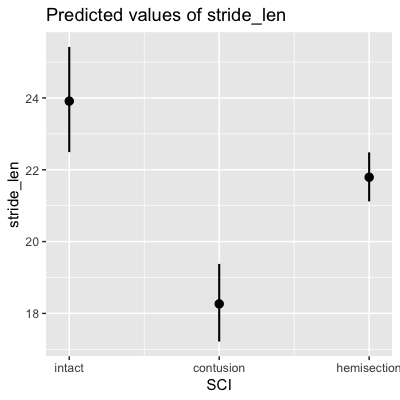

In [16]:
%%R -i dfpsci -w 4 -h 4 --units in -r 100

mod1 <- glmmTMB(log(stride_len) ~ SCI  + (1+SCI|ID) ,data=dfpsci,zi=~0,disp=~SCI)

print(joint_tests(mod1))
em=emmeans(mod1,pairwise ~SCI,data=dfpsci,type='response')
print(em)
print(confint(em))

print(plot_model(mod1,type='pred'))

 Family: Gamma  ( logit )
Formula:          duty_factor ~ SCI + (1 + SCI | ID)
Dispersion:                   ~SCI
Data: dfpsci

     AIC      BIC   logLik deviance df.resid 
 -7363.0  -7294.2   3693.5  -7387.0     2271 

Random effects:

Conditional model:
 Groups Name           Variance Std.Dev. Corr        
 ID     (Intercept)    0.03196  0.1788               
        SCIcontusion   0.01218  0.1104   -0.74       
        SCIhemisection 0.01874  0.1369   -0.86  0.64 
Number of obs: 2283, groups:  ID, 17

Conditional model:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -0.41045    0.04379  -9.373  < 2e-16 ***
SCIcontusion    0.40222    0.03577  11.245  < 2e-16 ***
SCIhemisection  0.18828    0.04644   4.054 5.03e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Dispersion model:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)     4.28600    0.03971  107.94  < 2e-16 ***
SCIcontusion    0.58236    0.07139    8.16 3.43e

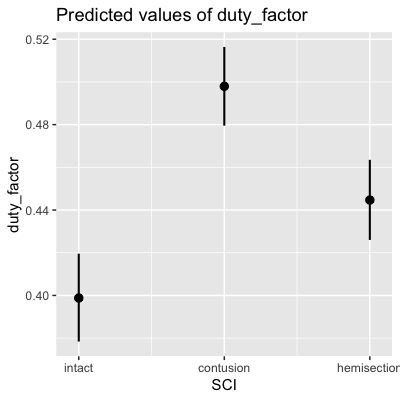

In [17]:
%%R -i dfpsci -w 4 -h 4 --units in -r 100

mod1<-glmmTMB(duty_factor ~ SCI  + (1+SCI|ID),zi=~0,disp=~SCI, data=dfpsci, family=Gamma(link = "logit"))
print(summary(mod1))

print(joint_tests(mod1))
em=emmeans(mod1,pairwise ~SCI,data=dfpsci,type='response')
print(em)
print(confint(em))


print(plot_model(mod1,type='pred'))

### Figure 2---figure supplement 1: Maximal locomotor speed of intact rats and after hemisection or contusion injury

(0.0, 250.0)

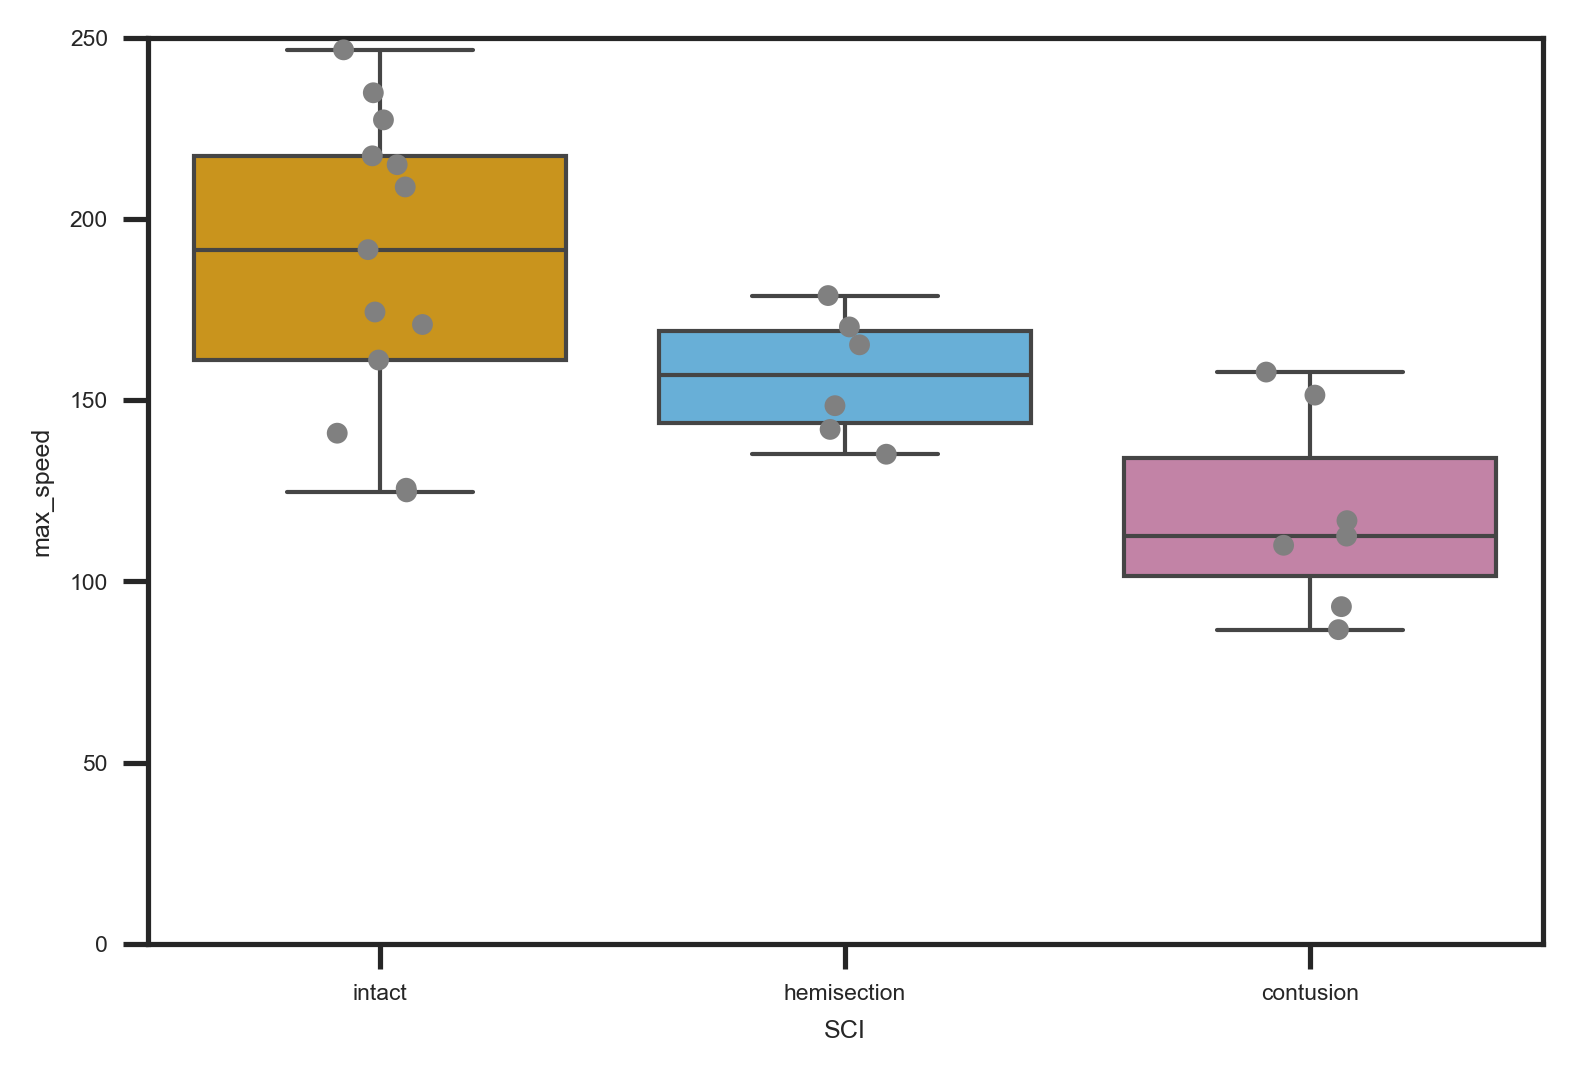

In [53]:
res_msp=dfpsci.groupby(['ID','SCI']).apply(lambda x: np.percentile(x.speed,95))
res_msp=res_msp.reset_index()
res_msp=res_msp.rename(columns={0:'max_speed'})
res_msp=res_msp[~res_msp.ID.isin([15,18,16,13])]
res_msp.SCI=res_msp.SCI.cat.reorder_categories(['intact', 'hemisection','contusion'])
sns.boxplot(y='max_speed',x='SCI',data=res_msp,palette=[colormap[1],colormap[2],colormap[7]])
sns.stripplot(y='max_speed',x='SCI',data=res_msp,color='Gray')
plt.gca().set_ylim([0,250])
#plt.savefig('max_speed.pdf',transparent=True)

 Family: gaussian  ( identity )
Formula:          max_speed ~ SCI + (1 | ID)
Data: res_msp

     AIC      BIC   logLik deviance df.resid 
   263.1    269.4   -126.5    253.1       21 

Random effects:

Conditional model:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 243      15.59   
 Residual             774      27.82   
Number of obs: 26, groups:  ID, 13

Dispersion estimate for gaussian family (sigma^2):  774 

Conditional model:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)     187.624      8.845  21.212  < 2e-16 ***
SCIhemisection  -32.016     14.367  -2.228   0.0259 *  
SCIcontusion    -68.454     13.537  -5.057 4.26e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
 model term df1 df2 F.ratio p.value
 SCI          2  21  13.399  0.0002

$emmeans
 SCI         emmean    SE df lower.CL upper.CL
 intact         188  8.85 21    169.2      206
 hemisection    156 12.87 21    128.8      182
 contusion      119 11.93 21    

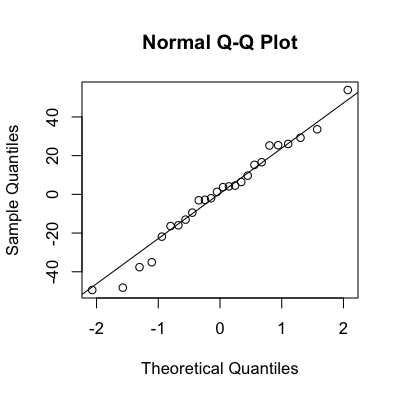

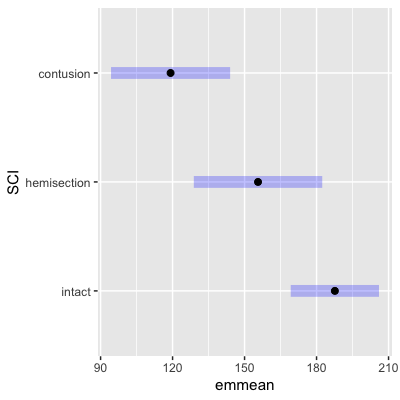

In [19]:
%%R -i res_msp -w 4 -h 4 --units in -r 100
library(lme4)
library(glmmTMB)
library(emmeans)
mod1 = glmmTMB(max_speed ~ SCI + (1|ID),disp=~1,data=res_msp)

print(summary(mod1))
print(joint_tests(mod1))
qqnorm(resid(mod1))
qqline(resid(mod1))

print(emmeans(mod1,pairwise ~SCI,data=res_msp)) 
print(contrast(emmeans(mod1, ~SCI,data=res_msp),"trt.vs.ctrl1"))
print(plot(emmeans(mod1, ~SCI,data=res_msp)))

## Figure 3: Speed-dependent modulation of gait characteristics in intact rats and after hemisection and contusion injury

In [20]:
plt.rcParams["lines.linewidth"]= 1

def tint(c, f): return [int(v + (1.0 - v) * f) for v in c]
plot_ind_mean = True

#cp = ['#%02x%02x%02x' % (c[0],c[1],c[2]) for c in [colormap[1],colormap[2],colormap[7]]]
cp=deepcopy([colormap[1],colormap[2],colormap[7]])

cp_g=sns.color_palette("Paired", 20)
cp_g=cp_g[1:]
cp_g.pop(2)
cp_g.pop(2)
cp_g.pop(4)

f_ex = lambda x, a, b: np.exp(-x * a) + b
f_1x = lambda x, a, b: 1/(a*x) + b
f_lin = lambda x, a, b: x * a + b
f_off = lambda x, a: a
f_pow = lambda x, a, b: a*x**-b

f_sqrt = lambda x, a, b: np.sqrt((x-b) * a)

x_col, x_lim = ('speed', (0.0, 300.0))

def do_regression(factors,do_plot=True):
    results = []

    if do_plot:
        fig, axes = plt.subplots(len(factors), 4, sharex='all')
        fig.set_size_inches(4*2,(len(factors))*2)
    for k,(y_col,fun,y_lim) in enumerate(factors):
        for j, (sci,df_) in enumerate(df_phases.groupby(['SCI'])):
            covars=[]
            fixed=[]
            residuals=[]
            total=[]
            for i, (id_,df) in enumerate(df_.groupby(['ID'])):
                df2 = df[[y_col, x_col,'gaits']].dropna()
                if sci == 'contusion':
                    df2=df2[df2.speed<200]
                if sci=='contusion':
                    j=2
                if sci=='intact':
                    j=0
                if sci=='hemisection':
                    j=1
                pars = lmfit.Parameters()
                pars.add_many(('a', 0.1, True, -20.0, 10.0, None),
                            ('b', 0.1, True, -1e5, 1e5, None))
            
                gmodel = lmfit.Model(fun)
                
                yy = df2[y_col].values
                xx = df2[x_col].values
                out = gmodel.fit(yy, x=xx, params=pars)

                chisq_thr = 0.15            
                n_rem_max = 20

                n_rem = 0
                for _ in range(n_rem_max):
                    chi_sq = np.zeros((len(xx),))
                    for ii in range(len(xx)):
                        idx = np.arange(0, len(xx))
                        idx = np.delete(idx, ii)
                        tmp = gmodel.fit(yy[idx], x=xx[idx], params=pars)
                        chi_sq[ii] = tmp.chisqr
                    dchisqr = out.chisqr / chi_sq - 1
                    
                    if np.max(dchisqr)>chisq_thr:
                        yy = np.delete(yy,np.argmax(dchisqr))
                        xx = np.delete(xx,np.argmax(dchisqr))
                        out = gmodel.fit(yy, x=xx, params=pars)
                        n_rem+=1
                    else:
                        break

                x = np.arange(x_lim[0]-(x_lim[1] - x_lim[0])*0.1, x_lim[1]+((x_lim[1] - x_lim[0]))*0.1, (x_lim[1] - x_lim[0]) / 100.0)
                x_min = np.percentile(xx,5)
                x_max = np.percentile(xx,95)
                
                x = np.arange(x_min, x_max, (x_max - x_min) / 100.0)
                best = out.eval(x=x)
                dely = out.eval_uncertainty(x=x, sigma=2)
                
                if do_plot:
                    ax=axes[k,j]
                    if k == 0:
                        ax.set_title( sci)
                    if k == len(factors)-1:
                        ax.set_xlabel(x_col)
                    if j == 0:
                        ax.set_ylabel(y_col)

                    ax.scatter(xx,yy,s=5,lw=0,alpha=0.25,c='0.5')
                    ax.plot(x, best,c=cp[j],lw=1)
                    ax.set_ylim(y_lim)
                    ax.set_xlim(x_lim)
                covars+=[out.covar]
                fixed+=[[x for x in out.best_values.values()]]
                residuals+=[out.residual]
                total+=[yy-np.mean(yy)]

            x = np.arange(x_lim[0]-(x_lim[1] - x_lim[0])*0.1, x_lim[1]+((x_lim[1] - x_lim[0]))*0.1, (x_lim[1] - x_lim[0]) / 100.0) 
            x_min = np.nanpercentile(df_[x_col],5)
            x_max = np.nanpercentile(df_[x_col],95) 
            x = np.arange(x_min, x_max, (x_max - x_min) / 100.0)  
            fixed=np.array(fixed)
            mu=np.mean(fixed,axis=0)
            cov=np.mean(covars,axis=0)#/np.sqrt(len(covars))

            R2=1-np.var(np.concatenate(residuals))/np.var(np.concatenate(total))

            results += [{'parameter':y_col,'SCI':sci,'a':mu[0],'a_var':cov[0,0],'b':mu[1],'b_var':cov[1,1],'mu':mu,'cov':cov,'R2':R2,'fun':inspect.getsource(fun)[:-1],'x_min':x_min,'x_max':x_max}]
            print("{:14}, {:12}: a = {: .5f} +-{: .5f}, b = {: .5f} +-{: .5f}, R2 = {:.4f}, {}".format(y_col,sci,mu[0],np.sqrt(cov[0,0]),mu[1],np.sqrt(cov[1,1]),R2,inspect.getsource(fun)[:-1]))
            
            CI = 'delta_population'

            if 'bootstrap' in CI:
                n_draws = 10000
                if CI == 'bootstrap_individuals':
                    samples = np.mean([np.random.multivariate_normal(mean,cov,n_draws) for mean, cov in list(zip(fixed,covars))],axis=0)
                elif CI == 'bootstrap_population':
                    samples = np.random.multivariate_normal(mu,cov,n_draws)
                ys=[fun(x,a,b) for a,b in samples]
                perc=np.percentile(np.array(ys),[5,95],axis=0)
                if do_plot:
                    axes[k,3].fill_between(x,perc[0,:],perc[1,:],alpha=0.25,lw=0,color=cp[j])    
            elif CI == 'delta_population':
                # https://stats.idre.ucla.edu/r/faq/how-can-i-estimate-the-standard-error-of-transformed-regression-parameters-in-r-using-the-delta-method/
                # https://cran.r-project.org/web/packages/modmarg/vignettes/delta-method.html
                dfdx=nd.Gradient(lambda p,x: fun(x,p[0],p[1]))
                delta_sd=np.sqrt(np.diagonal(dfdx(mu,x)@cov@dfdx(mu,x).T))
                y_m = fun(x,mu[0],mu[1])
                if do_plot:
                    axes[k,3].fill_between(x,y_m-delta_sd*1.96,y_m+delta_sd*1.96,alpha=0.25,lw=0,color=cp[j])

            if do_plot:
                axes[k,3].plot(x, fun(x,mu[0],mu[1]),c=cp[j],lw=1)
                    
                axes[k,3].set_ylim(y_lim)
                axes[k,3].set_xlim(x_lim)
    if do_plot:
        fig.tight_layout()    
        sns.despine(offset=5, trim=True)
    return results


stride_len    , contusion   : a =  0.13409 +- 0.01111, b =  7.47572 +- 0.92614, R2 = 0.6616, f_lin = lambda x, a, b: x * a + b
stride_len    , hemisection : a =  0.11879 +- 0.00777, b =  8.60982 +- 0.87559, R2 = 0.8390, f_lin = lambda x, a, b: x * a + b
stride_len    , intact      : a =  0.12205 +- 0.00699, b =  8.75804 +- 0.81592, R2 = 0.8390, f_lin = lambda x, a, b: x * a + b
duty_factor_f , contusion   : a = -0.00123 +- 0.00021, b =  0.62578 +- 0.01669, R2 = 0.4087, f_lin = lambda x, a, b: x * a + b
duty_factor_f , hemisection : a = -0.00140 +- 0.00012, b =  0.59883 +- 0.01401, R2 = 0.6576, f_lin = lambda x, a, b: x * a + b
duty_factor_f , intact      : a = -0.00116 +- 0.00015, b =  0.54506 +- 0.01593, R2 = 0.6186, f_lin = lambda x, a, b: x * a + b
duty_factor_h , contusion   : a = -0.00110 +- 0.00041, b =  0.56100 +- 0.03224, R2 = 0.1128, f_lin = lambda x, a, b: x * a + b
duty_factor_h , hemisection : a = -0.00150 +- 0.00020, b =  0.59582 +- 0.02258, R2 = 0.4476, f_lin = lambda x, 

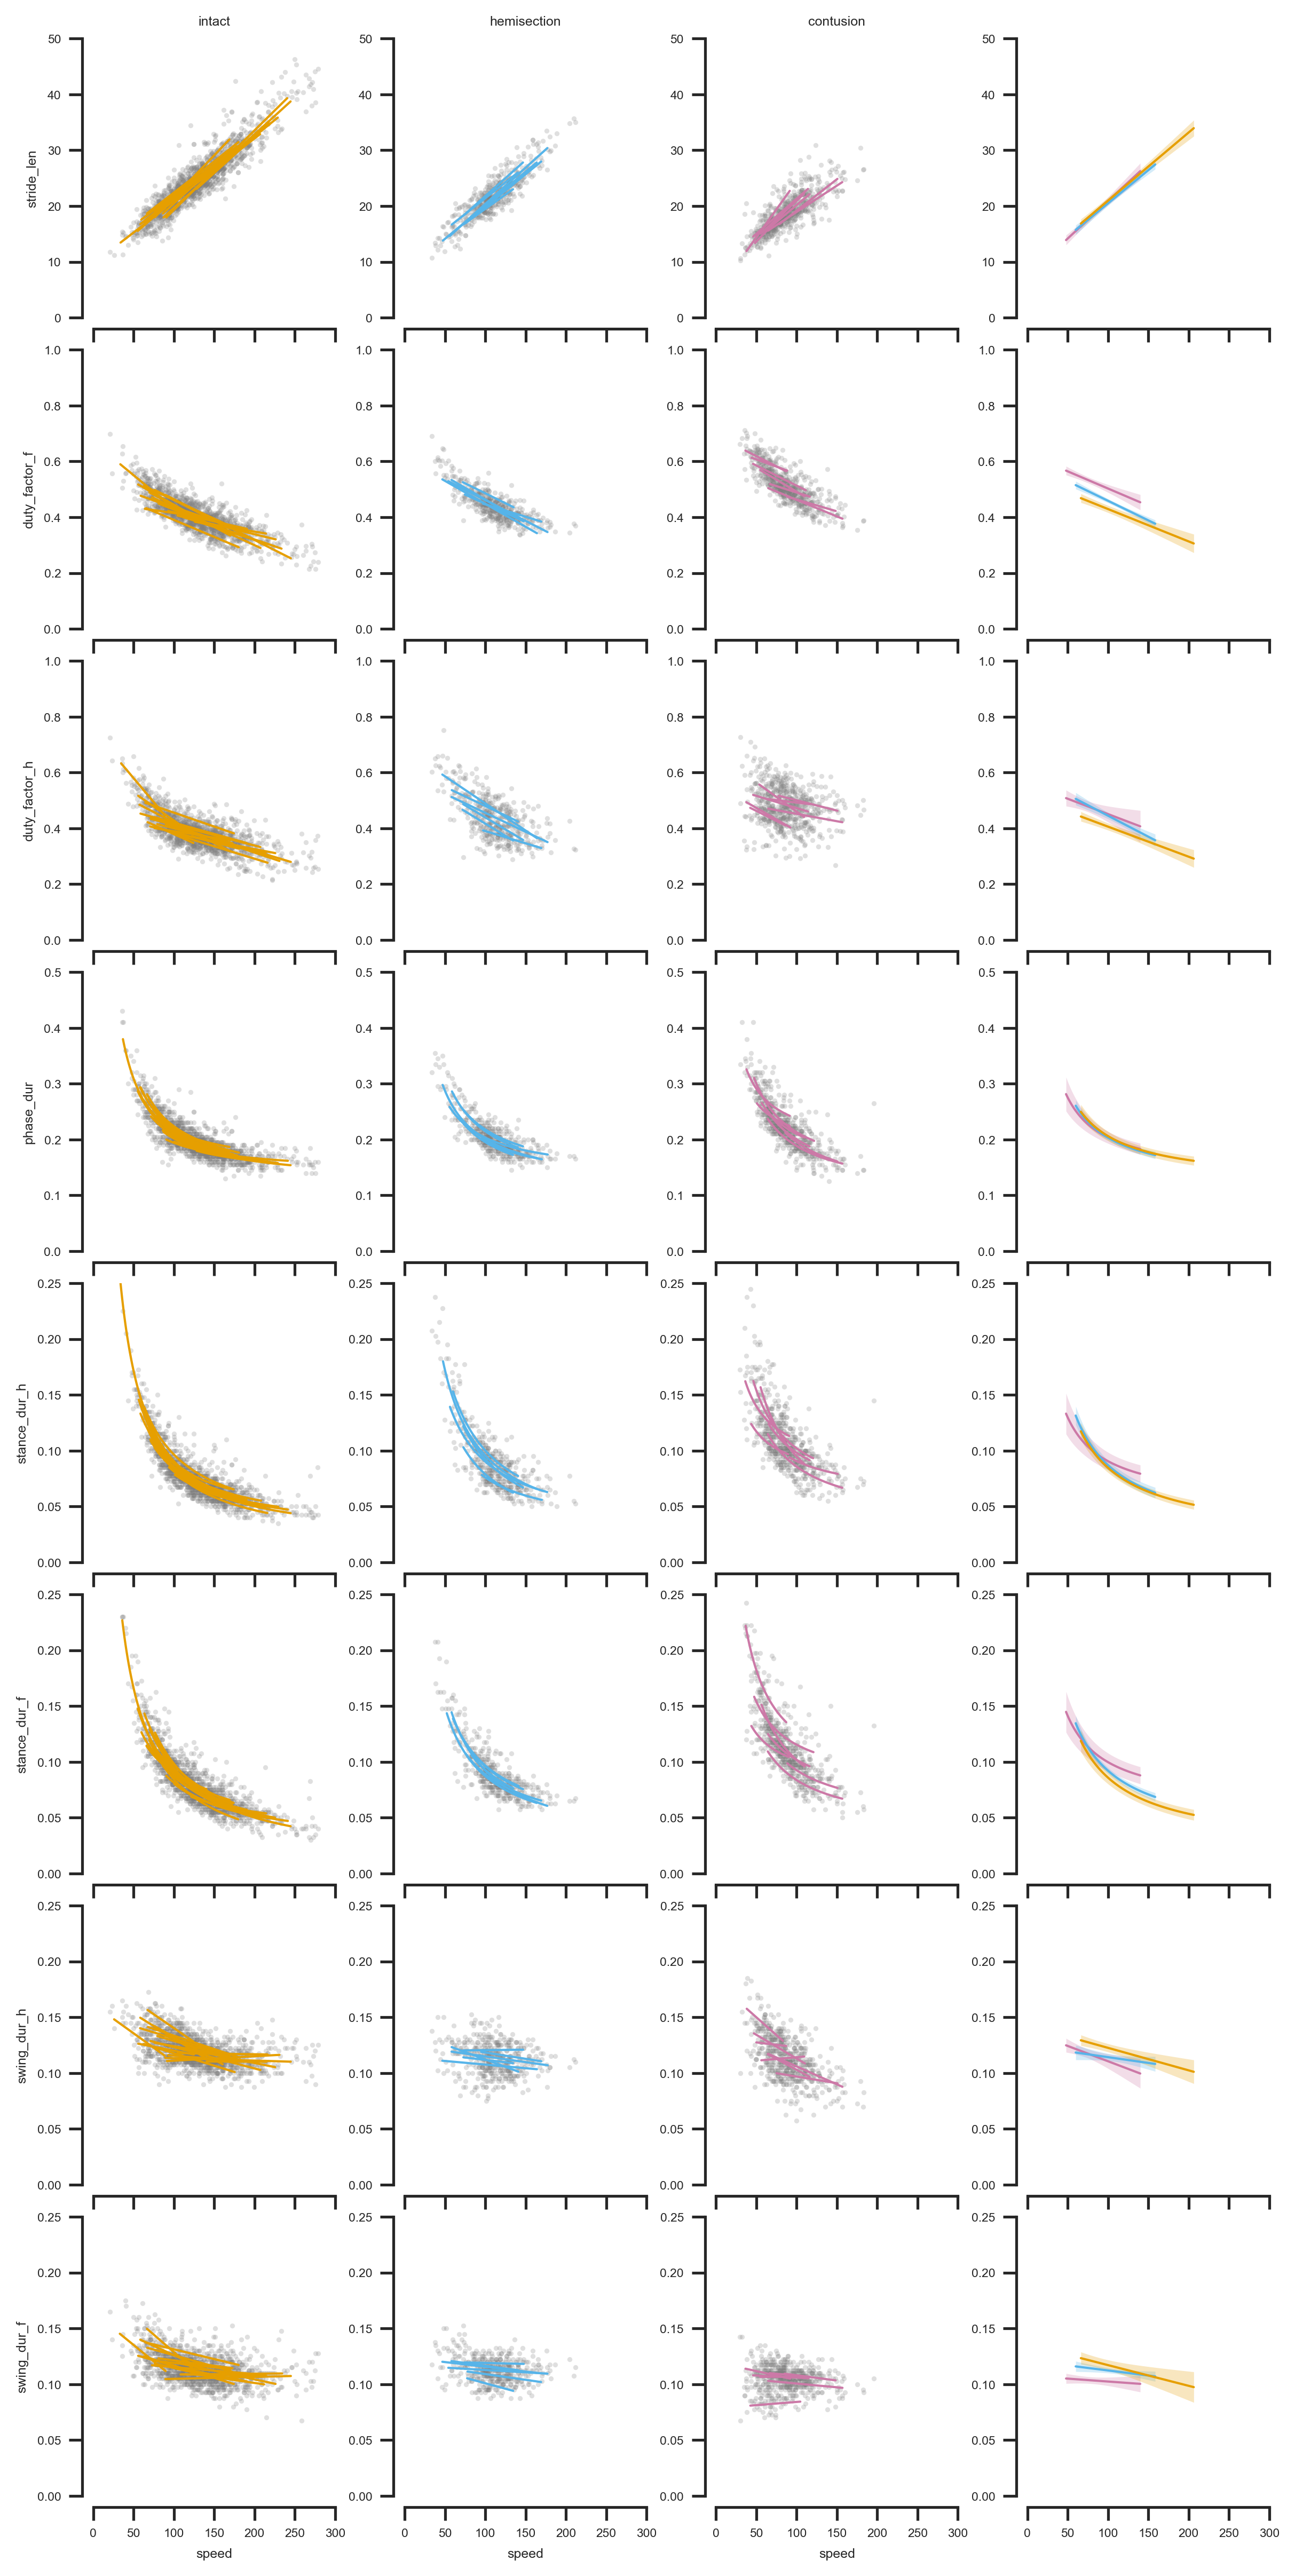

In [21]:
factors = [('stride_len',f_lin,(0,50)),('duty_factor_f',f_lin,(0,1)),('duty_factor_h',f_lin,(0,1)),('phase_dur',f_1x,(0,0.5))]
factors += [('stance_dur_h',f_1x,(0,0.25)),('stance_dur_f',f_1x,(0,0.25))]
factors += [('swing_dur_h',f_lin,(0,0.25)),('swing_dur_f',f_lin,(0,0.25))]
results=do_regression(factors)

### Figure 3---figure supplement 2: Left–right asymmetry of duty factors after hemisection

duty_factor_rh, contusion   : a = -0.00135 +- 0.00043, b =  0.56135 +- 0.03384, R2 = 0.1067, f_lin = lambda x, a, b: x * a + b
duty_factor_rh, hemisection : a = -0.00144 +- 0.00024, b =  0.57100 +- 0.02697, R2 = 0.4440, f_lin = lambda x, a, b: x * a + b
duty_factor_rh, intact      : a = -0.00108 +- 0.00016, b =  0.51867 +- 0.01838, R2 = 0.4384, f_lin = lambda x, a, b: x * a + b
duty_factor_lh, contusion   : a = -0.00092 +- 0.00037, b =  0.56849 +- 0.03130, R2 = 0.0943, f_lin = lambda x, a, b: x * a + b
duty_factor_lh, hemisection : a = -0.00137 +- 0.00022, b =  0.59548 +- 0.02529, R2 = 0.3323, f_lin = lambda x, a, b: x * a + b
duty_factor_lh, intact      : a = -0.00102 +- 0.00017, b =  0.50108 +- 0.01912, R2 = 0.3544, f_lin = lambda x, a, b: x * a + b
duty_factor_rf, contusion   : a = -0.00124 +- 0.00026, b =  0.63427 +- 0.02044, R2 = 0.3317, f_lin = lambda x, a, b: x * a + b
duty_factor_rf, hemisection : a = -0.00120 +- 0.00015, b =  0.57558 +- 0.01679, R2 = 0.5687, f_lin = lambda x, 

(0.0, 250.0)

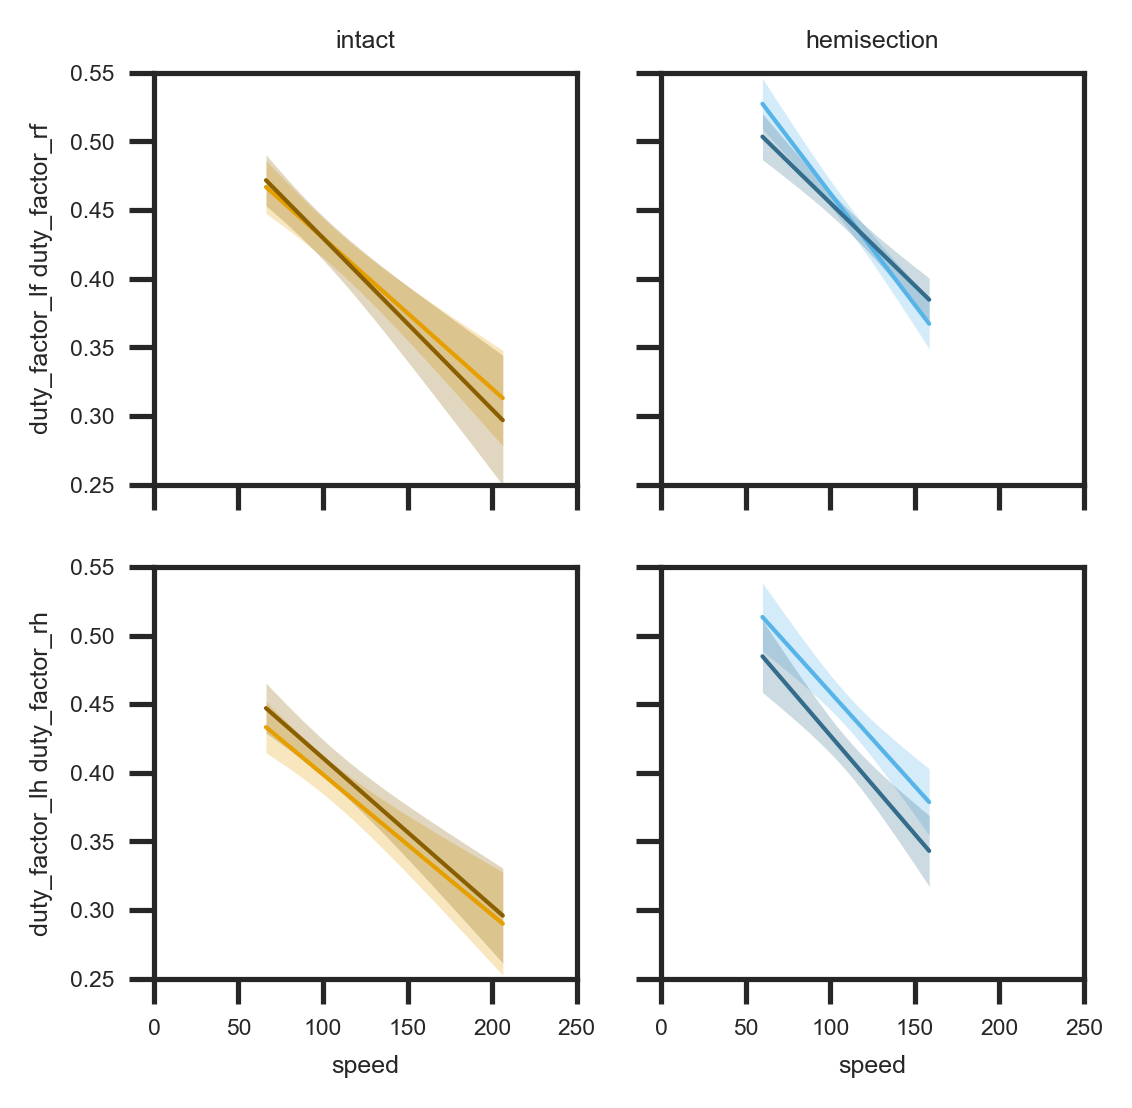

In [22]:
factors = [('duty_factor_rh',f_lin,(0,1)),('duty_factor_lh',f_lin,(0,1)),('duty_factor_rf',f_lin,(0,1)),('duty_factor_lf',f_lin,(0,1))]
results=do_regression(factors,False)
df_res = pd.DataFrame(results)
N_rats=df_phases.groupby('SCI').ID.unique().apply(lambda x:len(x))

cm_=colormap*255
cm_=cm_.astype(int)
cp2 = ['#%02x%02x%02x' % (c[0],c[1],c[2]) for c in [tint(c_,0.4) for c_ in [cm_[1],cm_[2],cm_[7]]]]
def plot_delta_gradient(x,mu,cov,fun,ax,col):
    dfdx=nd.Gradient(lambda p,x: fun(x,p[0],p[1]))
    delta_sd=np.sqrt(np.diagonal(dfdx(mu,x)@cov@dfdx(mu,x).T))
    y_m = fun(x,mu[0],mu[1])
    ax.fill_between(x,y_m-delta_sd*1.96,y_m+delta_sd*1.96,alpha=0.25,lw=0,color=col)
    ax.plot(x, fun(x,mu[0],mu[1]),c=col,lw=1)


factor_comps = [['duty_factor_lf','duty_factor_rf'],['duty_factor_lh','duty_factor_rh']]

fig, axes = plt.subplots(2, 2, sharex='all',sharey='all')
fig.set_size_inches(2*2,2*2)

for i,sci in enumerate(['intact','hemisection']):
    for j,ps in enumerate(factor_comps):
        df_=df_res[df_res.SCI==sci]
        for k,p in enumerate(ps):
            
            row=df_[df_.parameter==p].iloc[0]
            x_min=row.x_min
            x_max=row.x_max
            x = np.arange(x_min, x_max, (x_max - x_min) / 100.0) 
            col = cp[i]
            if k>0:
                col = cp2[i]
            ax = axes[j,i]
            plot_delta_gradient(x,row.mu,row['cov'],f_lin,ax,col)
            if j == 0:
                ax.set_title(sci)
            if j == 1:
                ax.set_xlabel('speed')
            if i == 0:
                ax.set_ylabel(ps[0]+' '+ps[1])

axes[0,0].set_ylim([0.25,0.55])
axes[0,0].set_xlim([0,250])


## Figure 4: Speed-dependent gait expression after recovery from a lateral-hemisection injury

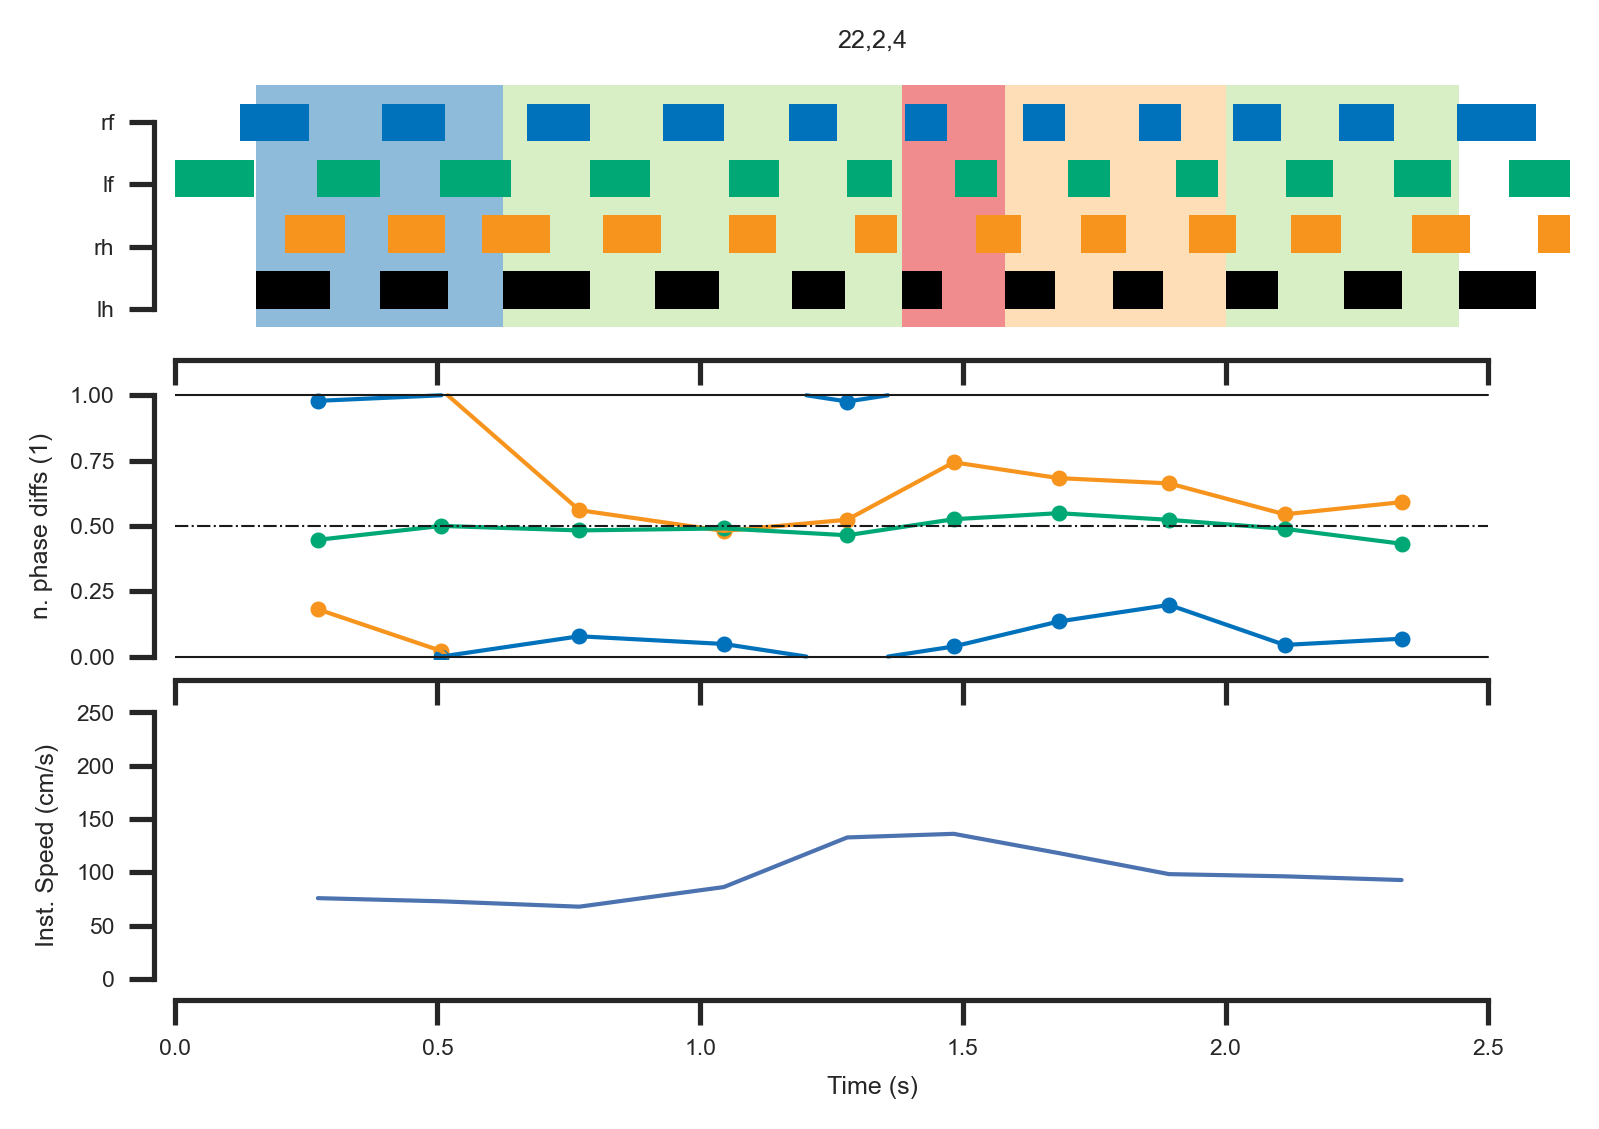

In [23]:
plot_bout(22,2,4);

### Figure 4 B–E: Boxenplots of locomotor speed (B), frequency (C), stride length (D), and duty factor (E) for each gait (walk, trot, canter, and gallop)

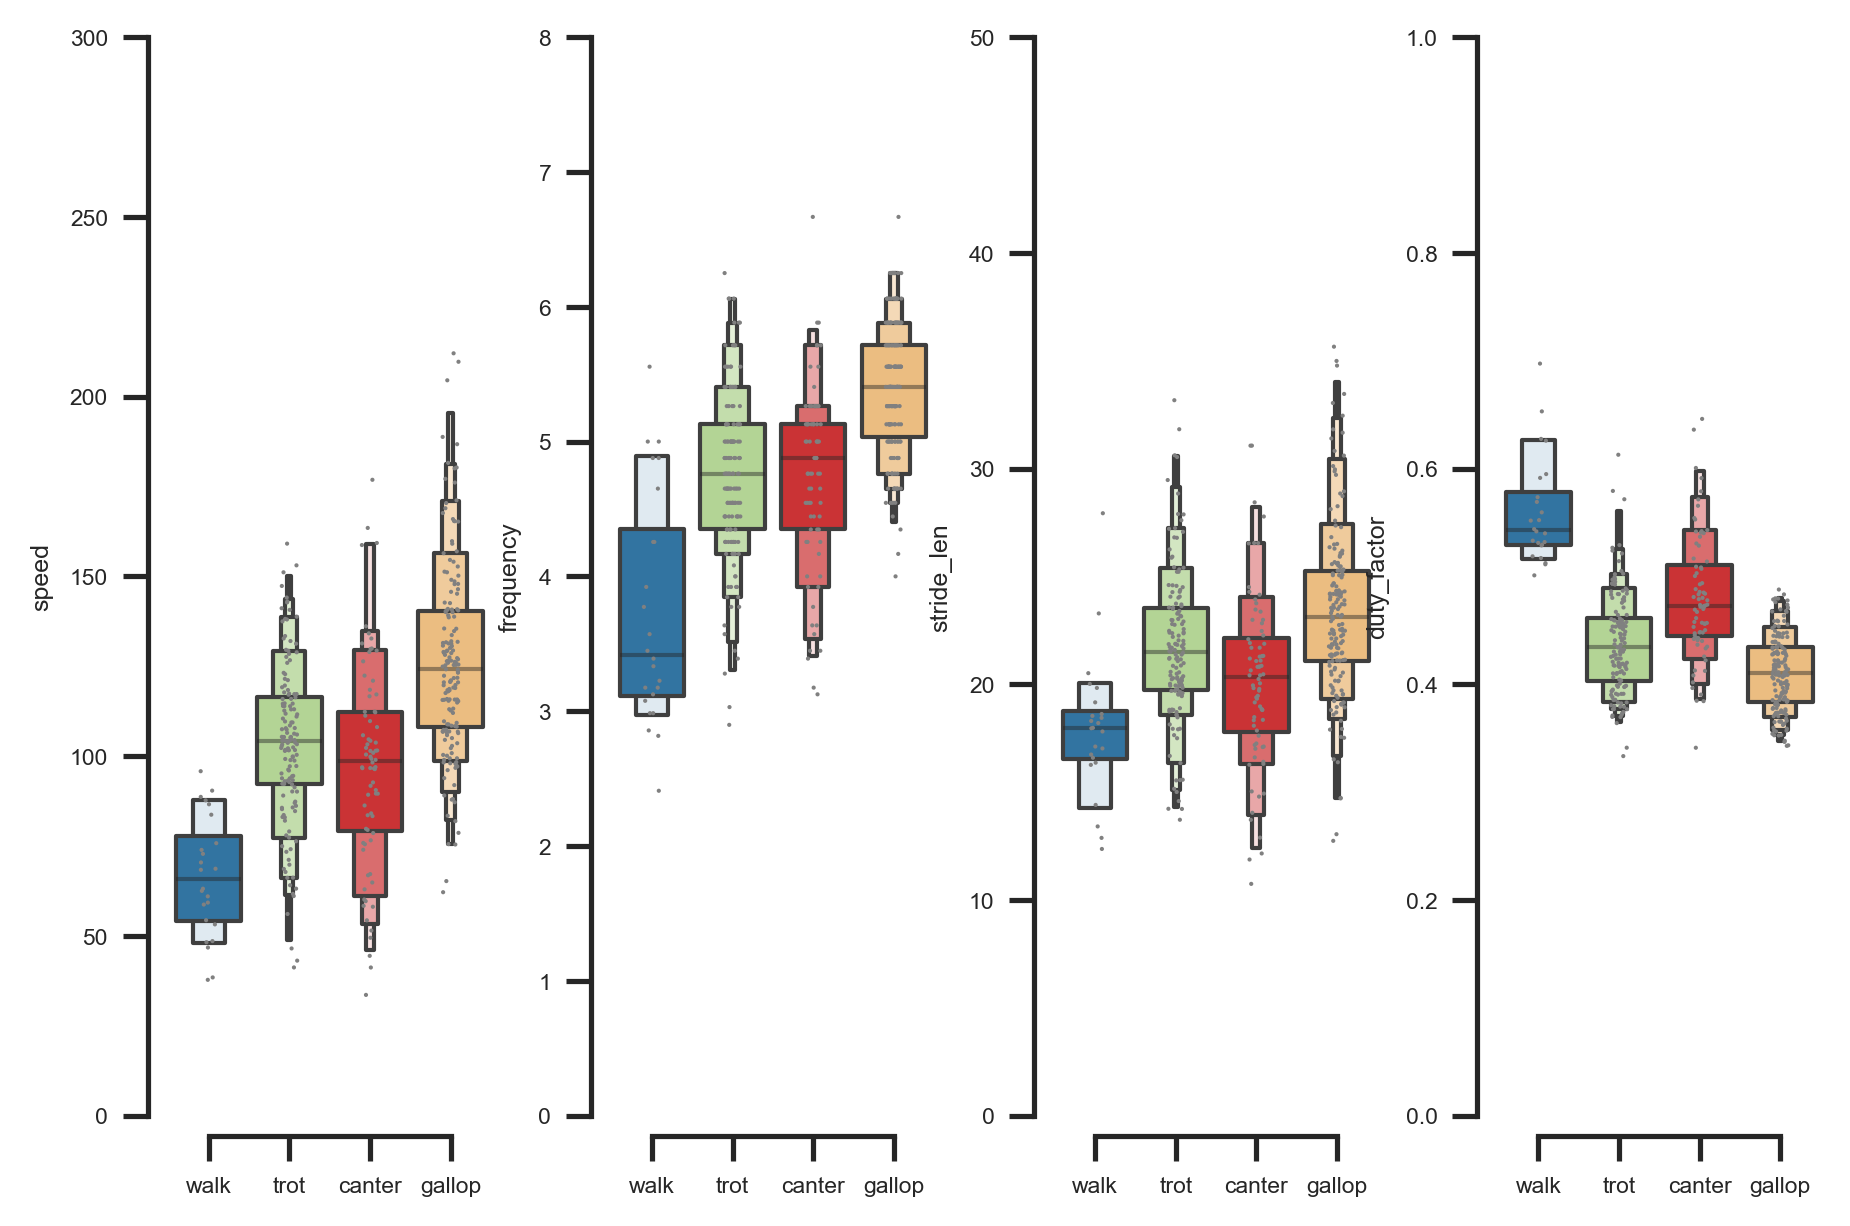

In [24]:
cp=sns.color_palette("Paired", 20)
cp=cp[1:]
cp.pop(2)
cp.pop(2)
cp.pop(4)

sci ='hemisection'

df = df_phases.loc[(df_phases.SCI == sci),['ID','gaits','frequency','speed','stride_len','duty_factor']].dropna()
gaits_= pd.Categorical(
        [np.nan]*len(df.gaits), ['walk', 'trot','canter','gallop'])
gaits_[df.gaits=='walk']='walk'
gaits_[df.gaits=='trot']='trot'
gaits_[df.gaits=='canter']='canter'
gaits_[df.gaits=='gallop']='gallop'
pl=['speed','frequency','stride_len','duty_factor']
ylims=[[0,300],[0,8],[0,50],[0,1],[0,1]]  
fig, ax = plt.subplots(1,4)
fig.set_size_inches(6, 4., forward=True)
plt.tight_layout()
for a,p,yl in zip(ax,pl,ylims):
    a = sns.boxenplot(
            y=df[p],x=gaits_,
            palette=cp,ax=a,linewidth=1,showfliers=False,k_depth='trustworthy')
    a = sns.stripplot(y=df[p],x=gaits_,
                   size=1, jitter=True,linewidth=0, color="gray",ax=a)
    a.set_ylim(yl)
sns.despine(offset=5, trim=True) 
df['gaits_']=gaits_

### Stats: Figure 4 B–E
Comparison of speed, frequency, stride length and duty factor between gaits of hemisected rats

R[write to console]: boundary (singular) fit: see help('isSingular')



 model term df1    df2 F.ratio p.value
 gaits_       3 392.69  53.843  <.0001

$emmeans
 gaits_ emmean   SE    df lower.CL upper.CL
 walk     66.4 5.19 300.5     56.2     76.7
 trot    103.4 2.25  16.0     98.7    108.2
 canter   97.3 3.06  39.7     91.2    103.5
 gallop  126.3 2.08  14.0    121.8    130.8

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$contrasts
 contrast        estimate   SE    df t.ratio p.value
 walk - trot        -37.0 5.65 392.7  -6.542  <.0001
 walk - canter      -30.9 5.97 405.4  -5.173  <.0001
 walk - gallop      -59.9 5.57 401.7 -10.750  <.0001
 trot - canter        6.1 3.92  74.5   1.555  0.4104
 trot - gallop      -22.9 3.16  57.6  -7.233  <.0001
 canter - gallop    -29.0 3.56 367.8  -8.125  <.0001

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 4 estimates 

 contrast        estimate   SE    df t.ratio p.value
 trot - walk         37.0 5.65 392.7   6.542  <.0001
 canter - trot 

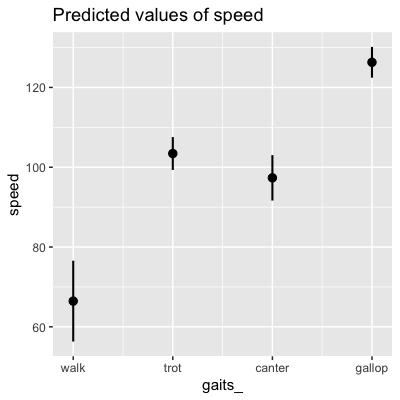

In [25]:
%%R -i df -w 4 -h 4 --units in -r 100

mod1 <- lmer(speed ~ gaits_ + (1|ID) ,data=df)

print(joint_tests(mod1))
emm_ = emmeans(mod1,pairwise ~gaits_,data=df)
print(emm_) 
print(contrast(emmeans(mod1,~gaits_), "consec"))

print(plot_model(mod1,type='pred'))

Linear mixed model fit by REML ['lmerMod']
Formula: frequency ~ gaits_ + (1 | ID)
   Data: df

REML criterion at convergence: 716.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0196 -0.5898  0.0671  0.6309  3.5811 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 0.05697  0.2387  
 Residual             0.31603  0.5622  
Number of obs: 411, groups:  ID, 6

Fixed effects:
             Estimate Std. Error t value
(Intercept)    3.8011     0.1514  25.107
gaits_trot     0.9593     0.1258   7.623
gaits_canter   1.0167     0.1329   7.652
gaits_gallop   1.6282     0.1248  13.045

Correlation of Fixed Effects:
            (Intr) gts_tr gts_cn
gaits_trot  -0.700              
gaits_cantr -0.653  0.766       
gaits_gallp -0.708  0.829  0.809
 model term df1    df2 F.ratio p.value
 gaits_       3 403.42  70.811  <.0001

$emmeans
 gaits_ emmean    SE    df lower.CL upper.CL
 walk     3.80 0.151 23.61     3.49     4.11
 trot     4.76 0.110  6.66     4

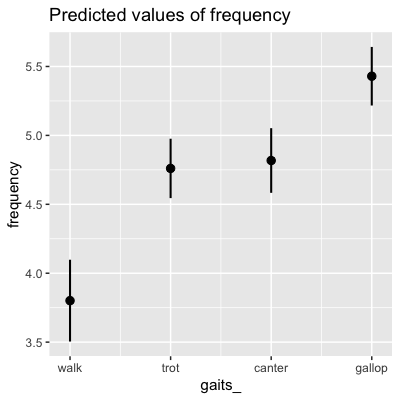

In [26]:
%%R -i df -w 4 -h 4 --units in -r 100

mod1 <- lmer(frequency ~ gaits_ + (1|ID) ,data=df)

print(summary(mod1))

print(joint_tests(mod1))
emm_ = emmeans(mod1,pairwise ~gaits_,data=df)
print(emm_) 

print(plot_model(mod1,type='pred'))

Linear mixed model fit by REML ['lmerMod']
Formula: stride_len ~ gaits_ + (1 | ID)
   Data: df

REML criterion at convergence: 2253.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6992 -0.6152 -0.0566  0.4819  3.2205 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept)  0.4401  0.6634  
 Residual             14.0586  3.7495  
Number of obs: 411, groups:  ID, 6

Fixed effects:
             Estimate Std. Error t value
(Intercept)   17.8721     0.8165  21.889
gaits_trot     3.6389     0.8355   4.355
gaits_canter   2.4115     0.8837   2.729
gaits_gallop   5.5661     0.8275   6.726

Correlation of Fixed Effects:
            (Intr) gts_tr gts_cn
gaits_trot  -0.866              
gaits_cantr -0.810  0.778       
gaits_gallp -0.875  0.841  0.811
 model term df1    df2 F.ratio p.value
 gaits_       3 406.17  22.221  <.0001

$emmeans
 gaits_ emmean    SE     df lower.CL upper.CL
 walk     17.9 0.819 125.97     16.3     19.5
 trot     21.5 0.434  11.54 

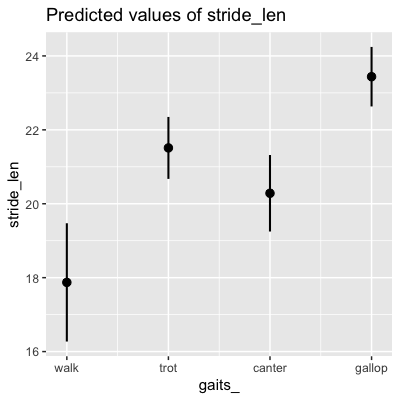

In [27]:
%%R -i df -w 4 -h 4 --units in -r 100

mod1 <- lmer(stride_len ~ gaits_ + (1|ID),data=df)
print(summary(mod1))
print(joint_tests(mod1))
emm_=emmeans(mod1,pairwise ~gaits_,data=df)
print(emm_) 

print(plot_model(mod1,type='pred'))

Linear mixed model fit by REML ['lmerMod']
Formula: duty_factor ~ gaits_ + (1 | ID)
   Data: df

REML criterion at convergence: -1364.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1259 -0.7014 -0.0279  0.5590  3.8249 

Random effects:
 Groups   Name        Variance  Std.Dev.
 ID       (Intercept) 0.0001297 0.01139 
 Residual             0.0019246 0.04387 
Number of obs: 411, groups:  ID, 6

Fixed effects:
              Estimate Std. Error t value
(Intercept)   0.556482   0.010155  54.796
gaits_trot   -0.116289   0.009801 -11.865
gaits_canter -0.082181   0.010356  -7.936
gaits_gallop -0.147259   0.009714 -15.160

Correlation of Fixed Effects:
            (Intr) gts_tr gts_cn
gaits_trot  -0.815              
gaits_cantr -0.760  0.771       
gaits_gallp -0.823  0.834  0.810
 model term df1    df2 F.ratio p.value
 gaits_       3 404.88  94.177  <.0001

$emmeans
 gaits_ emmean      SE    df lower.CL upper.CL
 walk    0.556 0.01017 63.92    0.536    0.577
 trot    0.440 0

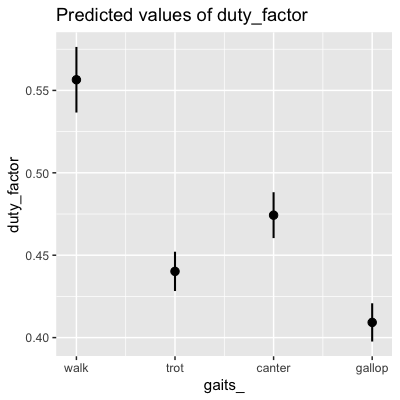

In [28]:
%%R -i df -w 4 -h 4 --units in -r 100 -o emm

mod1 <- lmer(duty_factor ~ gaits_ + (1|ID) ,data=df)

print(summary(mod1))
print(joint_tests(mod1))
emm_=emmeans(mod1,pairwise ~gaits_,data=df)
print(emm_) 

print(plot_model(mod1,type='pred'))

### Figure 4 F–H: (F) Average stance phases; (G) circular plots of average normalized phase differences; (H) average foot position of hemisected rats for each gait.

walk_lat  	LR=0.508+-0.046, HL=0.324+-0.054, diag=0.794+-0.057
trot      	LR=0.529+-0.075, HL=0.471+-0.047, diag=0.014+-0.073
canter    	LR=0.678+-0.074, HL=0.432+-0.050, diag=0.021+-0.054
trans_1   	LR=0.764+-0.072, HL=0.537+-0.056, diag=0.164+-0.062


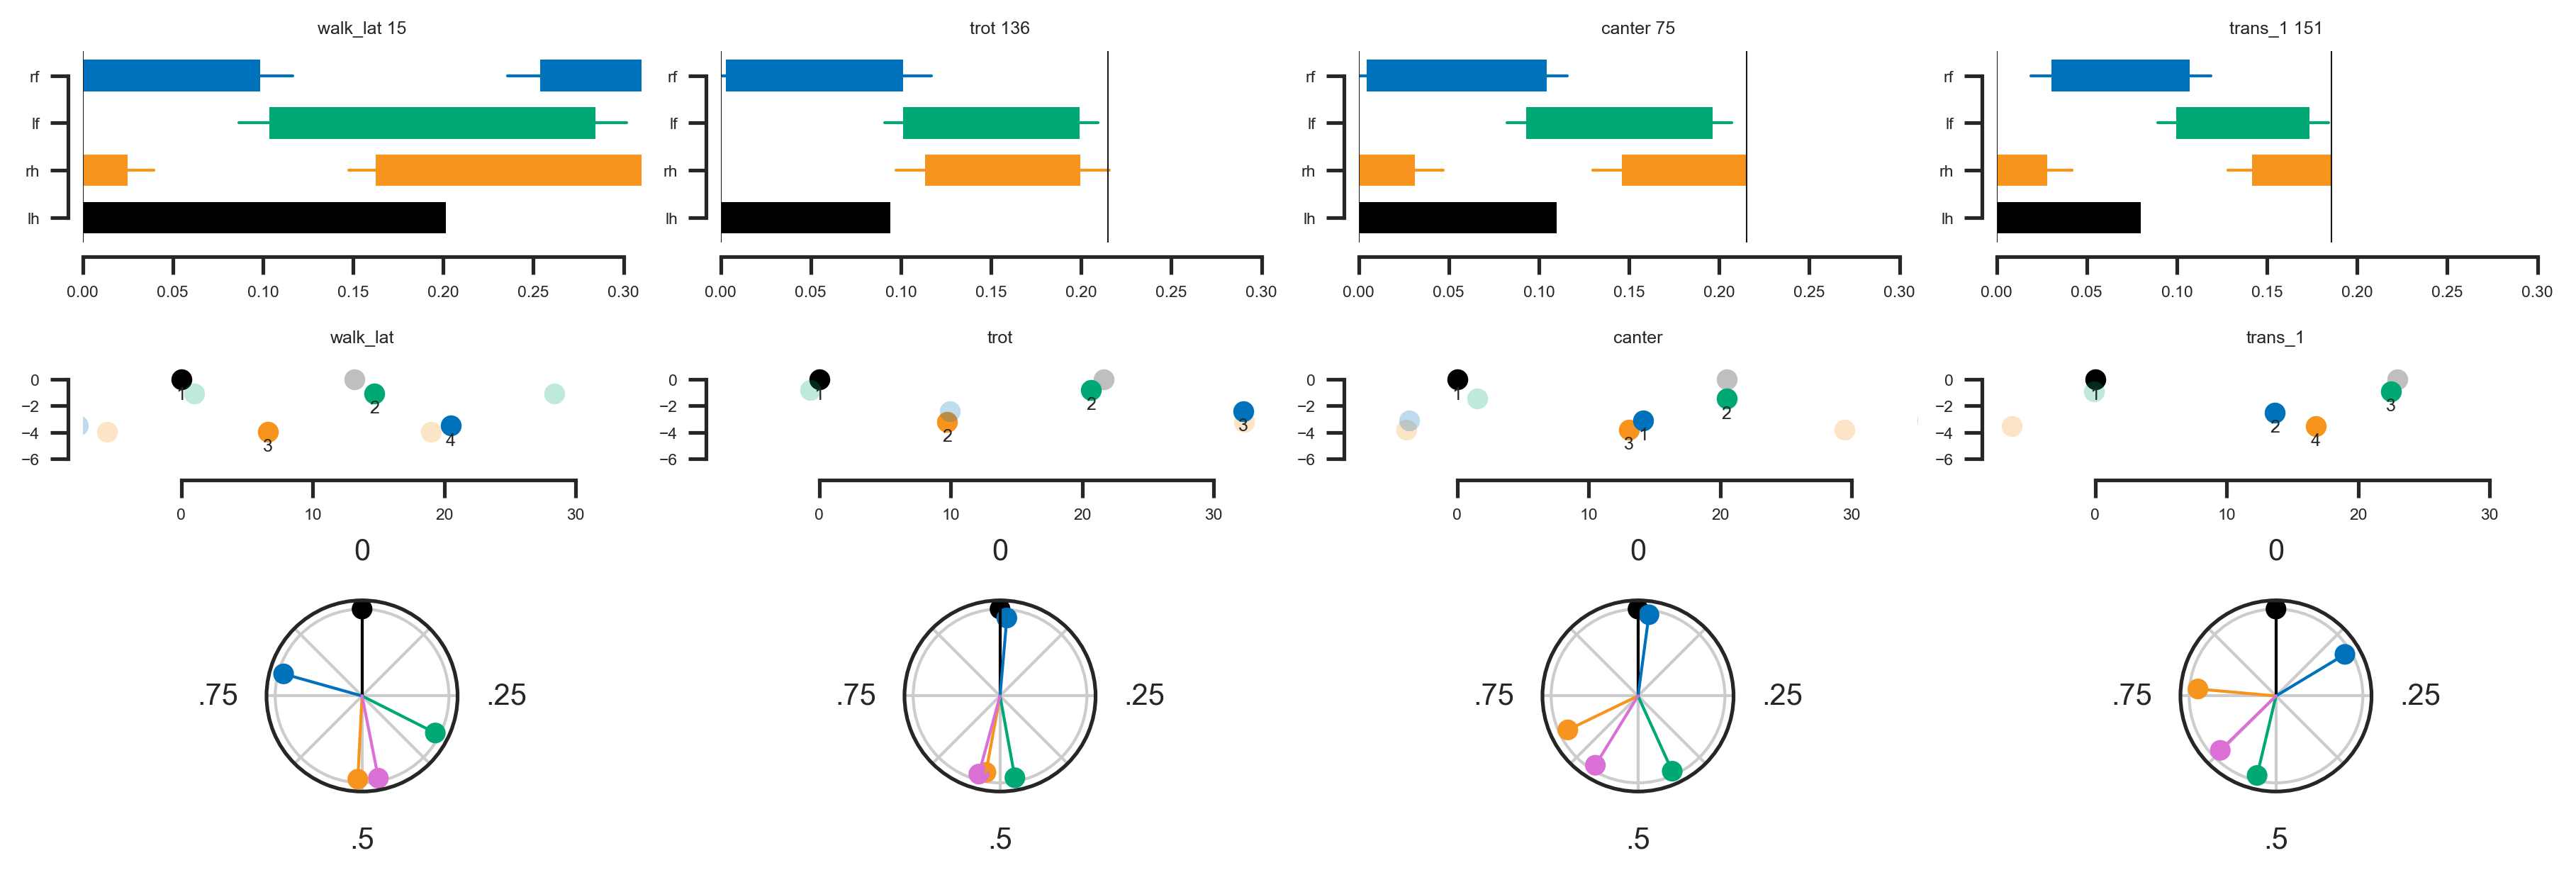

In [29]:
fig = plot_gait_properties('hemisection', ['walk_lat','trot','canter','trans_1'])
#trans_1 is a transverse-sequence gallop with a left lead limb

### Figure 4---figure supplement 1: Number of limbs on the ground as a proportion of the step cycle for each gait

          nolimb   onelimb   twolimb  threelimb  fourlimb
gaits_                                                   
walk    0.000000  0.105429  0.561600   0.317137  0.015834
trot    0.046058  0.189786  0.725678   0.038260  0.000218
canter  0.007203  0.226910  0.604826   0.160053  0.001008
gallop  0.017240  0.374787  0.572361   0.035612  0.000000


/var/folders/fz/27jjxdfx3jz5zh_vzsrj6dcm0000gp/T/ipykernel_38161/3026376006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['gaits_']=df.gaits_


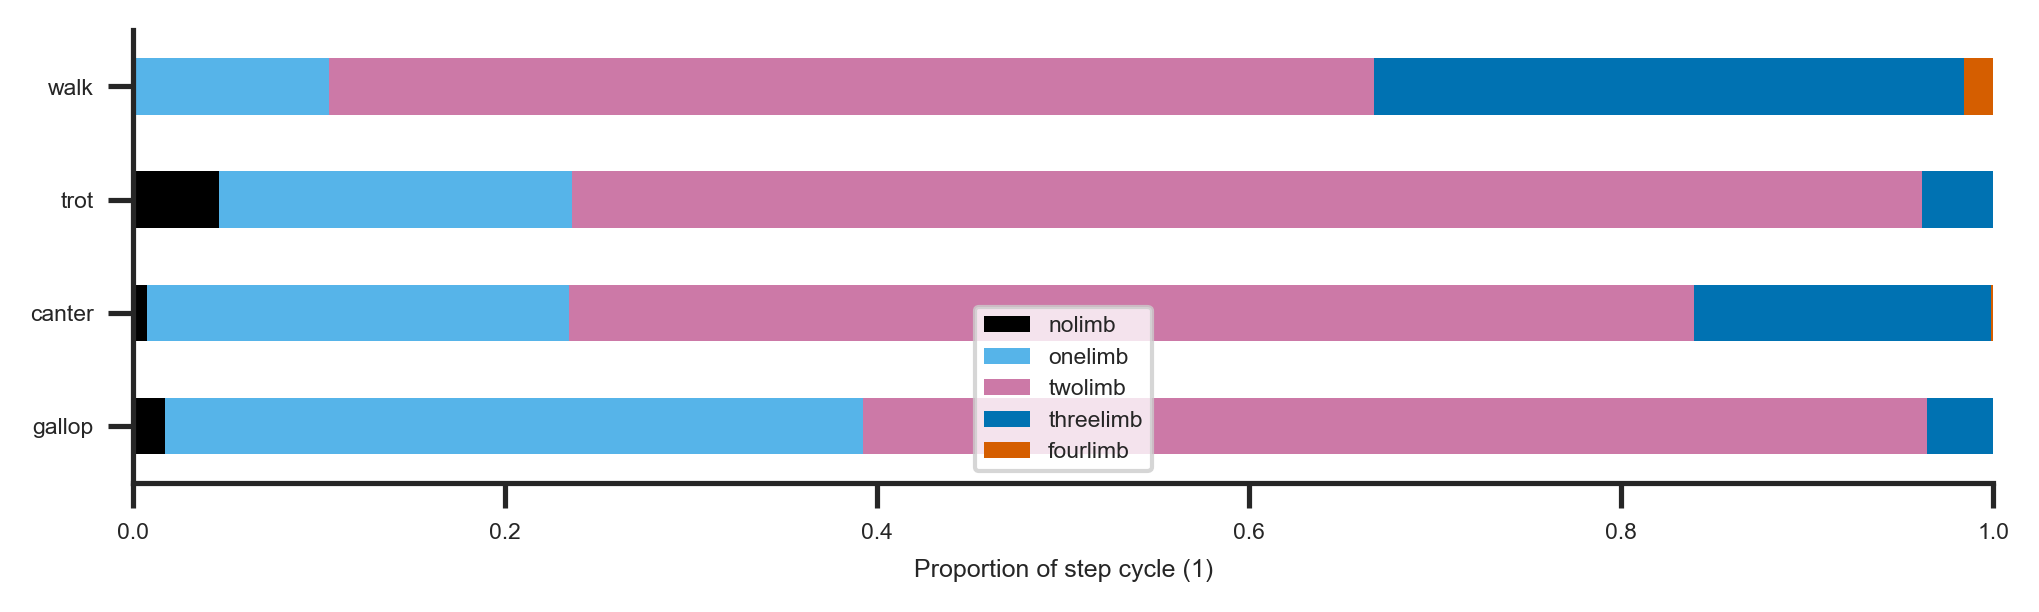

In [30]:
df_ = df_phases[df_phases.SCI=='hemisection']
df_['gaits_']=df.gaits_

fig = plt.figure()
fig.set_size_inches(8,2)
group=df_[['gaits_','nolimb','onelimb','twolimb','threelimb','fourlimb']].groupby(['gaits_'])
print(group.mean())
group.mean().plot.barh(stacked=True,color= colormap[[0,2,7,5,6,4]],lw=0,ax=plt.gca())
plt.xlim([0,1])
sns.despine()
plt.gca().invert_yaxis()
plt.gca().set_ylabel("")
plt.gca().set_xlabel("Proportion of step cycle (1)");


## Figure 5
### Figure 5 A,B: Changes of lead-limb preference following recovery after lateral hemisection injury. 

###### gallop ######
proportion
SCI        hemisection    intact
lead_limb                       
left          0.965116  0.373529
right         0.034884  0.626471


counts
SCI        hemisection  intact
lead_limb                     
left               166     127
right                6     213
Fisher's exact test: OR = 46.402, p = 0.0000


###### canter ######
proportion
SCI        hemisection    intact
lead_limb                       
left               1.0  0.289855
right              0.0  0.710145


counts
SCI        hemisection  intact
lead_limb                     
left                79      20
right                0      49
Fisher's exact test: OR = inf, p = 0.0000




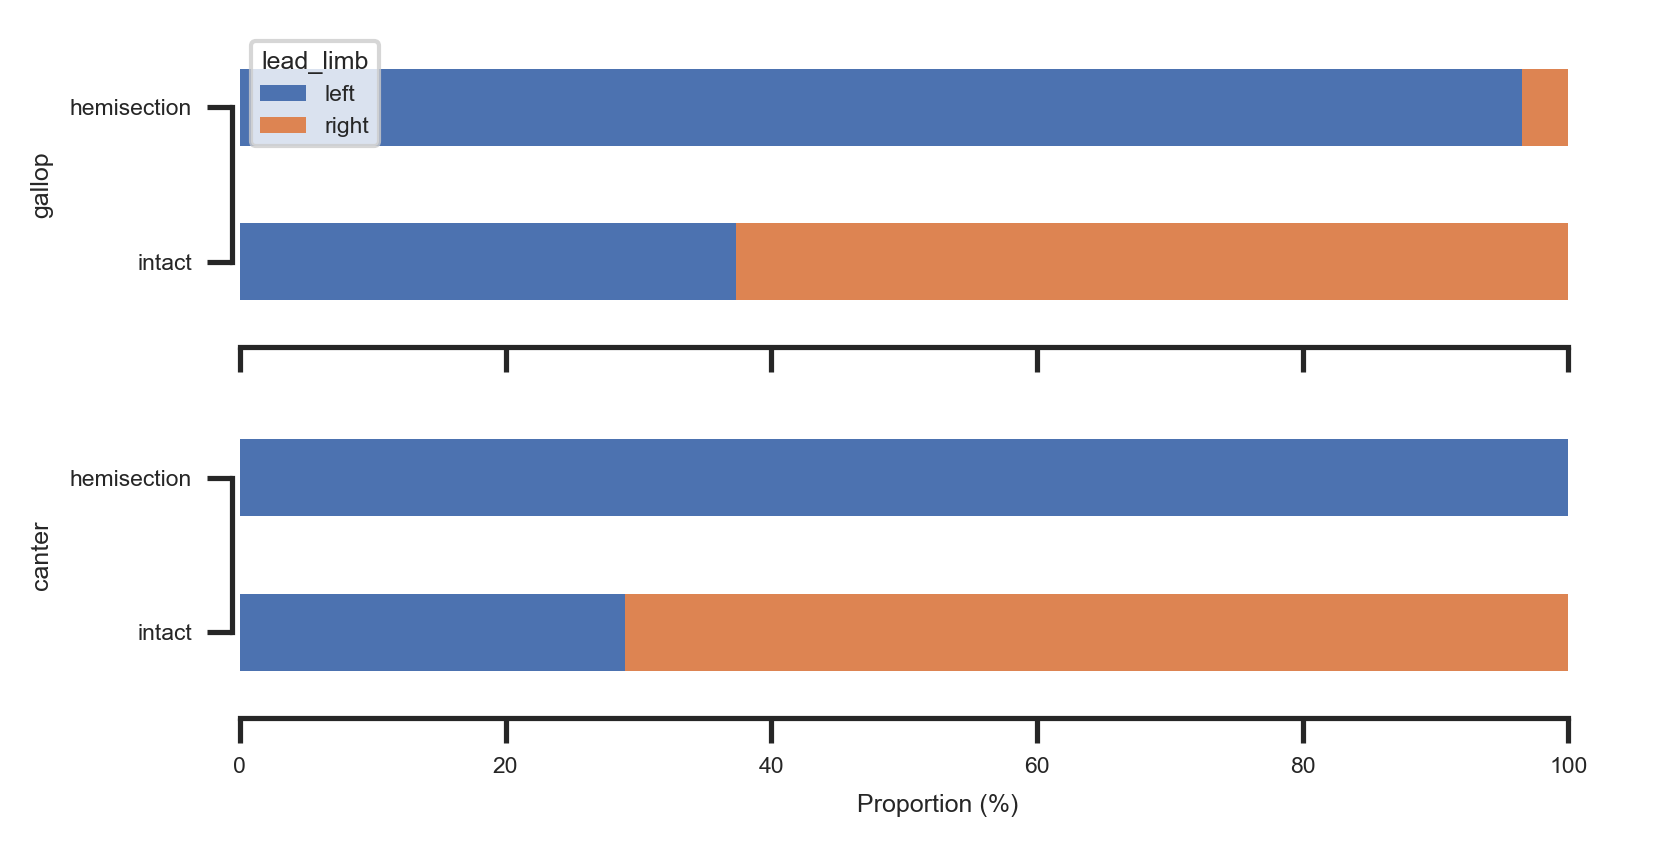

In [31]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

df_a=df_phases[(df_phases.SCI!='contusion')&((df_phases.gaits_all2=='trans_1')|(df_phases.gaits_all2=='trans_2'))]
df_b=df_phases[(df_phases.SCI!='contusion')&((df_phases.gaits_all2=='canter')|(df_phases.gaits_all2=='canter_2'))]

fig,axes = plt.subplots(2,1)
fig.set_size_inches(6, 3, forward=True)

for ax,name, df_ in zip(axes,['gallop','canter'],[df_a,df_b]):
    df_.loc[df_.gaits_all2.isin(['canter','trans_1']),'lead_limb']='left'
    df_.loc[df_.gaits_all2.isin(['canter_2','trans_2']),'lead_limb']='right'
    ct = pd.crosstab(df_.lead_limb, df_.SCI,dropna=True,normalize='columns')
    print('######',name,'######')
    print('proportion')
    print(ct)
    print('\n\ncounts')
    print(pd.crosstab(df_.lead_limb, df_.SCI,dropna=True))
    stacked = ct.stack().reset_index().rename(columns={0: 'value'})
    stacked.SCI = pd.Categorical(
        stacked.SCI,
        categories=[  "intact","hemisection"],
        ordered=False)
    stacked.lead_limb = pd.Categorical(
        stacked.lead_limb.values,
        categories=pd.unique(df_.lead_limb),
        ordered=False)
    
    stacked = stacked.rename(index=str, columns={'value': 'occurance'})
    stacked.occurance = stacked.occurance*100

    pivot_df = stacked.pivot(index='SCI', columns='lead_limb', values='occurance')
    pivot_df.plot.barh(stacked=True,ax=ax,lw=0)
    ax.set_ylabel(name)


    or_,pval = scstats.fisher_exact(pd.crosstab(df_.lead_limb, df_.SCI,dropna=True))
    print("Fisher's exact test: OR = {:2.3f}, p = {:2.4f}".format(or_,pval))
    print('\n')
sns.despine(offset=2,trim=True)

#axes[0].spines[['bottom']].set_visible(False)
#axes[0].tick_params(bottom=False)
axes[0].tick_params(labelbottom=False)
axes[1].set_xlabel('Proportion (%)')
axes[1].get_legend().remove()


### Figure 5 C,D: Changes of left–right coordination during trot (C, D) following recovery after lateral hemisection injury. 

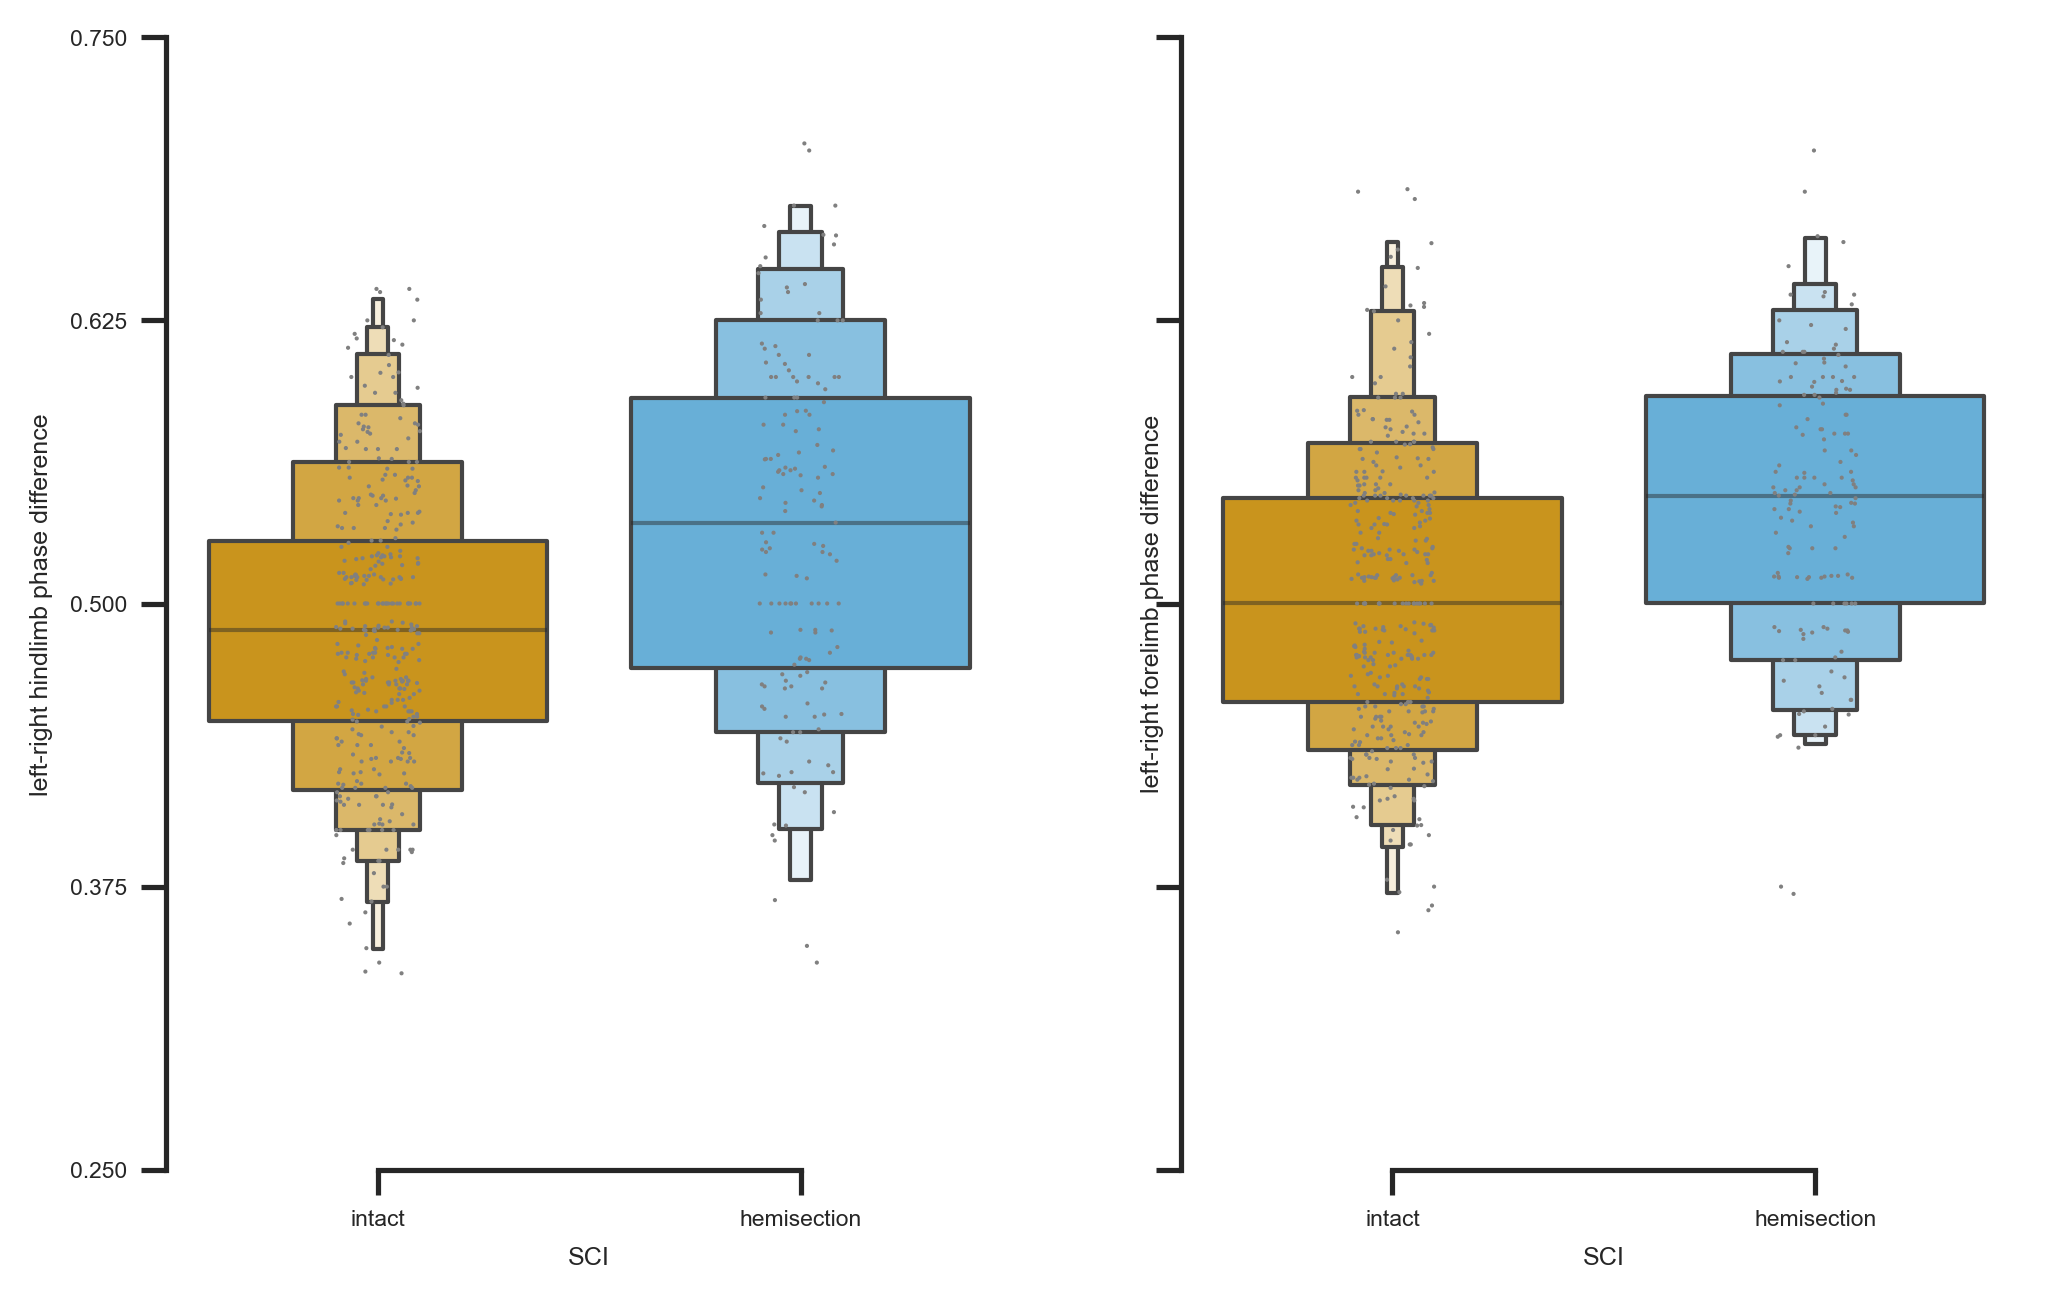

In [32]:
dft = df_phases[df_phases.gaits=='trot']
dft = dft[dft.SCI!='contusion']

fig,axs = plt.subplots(1,2,sharey='all')
fig.set_size_inches(8,5)
cp_ = [colormap[1],colormap[2]]
sns.boxenplot(x=dft.SCI,y=dft.LR_h,ax=axs[0],showfliers=False,k_depth='trustworthy',linewidth=1,palette=cp_)
sns.stripplot(x=dft.SCI,y=dft.LR_h,color='Gray',ax=axs[0],size=1,jitter=True,linewidth=0)
sns.boxenplot(x=dft.SCI,y=dft.LR_f,ax=axs[1],showfliers=False,k_depth='trustworthy',linewidth=1,palette=cp_)
sns.stripplot(x=dft.SCI,y=dft.LR_f,color='Gray',ax=axs[1],size=1,jitter=True,linewidth=0)



axs[0].set_yticks(np.arange(0,1.125,0.125))
axs[0].set_ylabel('left-right hindlimb phase difference')
axs[1].set_ylabel('left-right forelimb phase difference')
axs[0].set_ylim((0.25,0.75))
sns.despine(trim=True)

Data: dft
Models:
mod0: LR_h ~ (1 + SCI | ID), zi=~0, disp=~SCI
mod1: LR_h ~ SCI + (1 + SCI | ID), zi=~0, disp=~SCI
     Df     AIC     BIC logLik deviance  Chisq Chi Df Pr(>Chisq)  
mod0  6 -1429.8 -1404.2 720.92  -1441.8                           
mod1  7 -1433.8 -1403.9 723.90  -1447.8 5.9616      1    0.01462 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
 SCI         emmean      SE  df lower.CL upper.CL
 hemisection  0.549 0.01738 525    0.514    0.583
 intact       0.493 0.00858 525    0.477    0.510

Confidence level used: 0.95 
$SCI



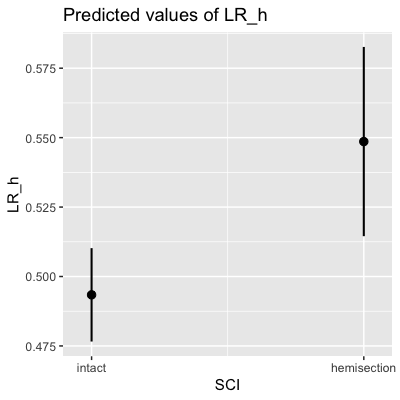

In [33]:
%%R -i dft -w 4 -h 4 --units in -r 100

mod0<-glmmTMB(LR_h ~ (1+SCI|ID),zi=~0,disp=~SCI, data=dft, family=gaussian(link = "identity"))
mod1<-glmmTMB(LR_h ~ SCI + (1+SCI|ID),zi=~0,disp=~SCI, data=dft, family=gaussian(link = "identity"))

print(anova(mod0,mod1))
print(emmeans(mod1, ~SCI,data=dft,component='cond')) 
print(plot_model(mod1,type='pred'))

Data: dft
Models:
mod0: LR_f ~ (1 + SCI | ID), zi=~0, disp=~SCI
mod1: LR_f ~ SCI + (1 + SCI | ID), zi=~0, disp=~SCI
     Df     AIC     BIC logLik deviance  Chisq Chi Df Pr(>Chisq)   
mod0  6 -1486.2 -1460.5 749.10  -1498.2                            
mod1  7 -1494.1 -1464.2 754.07  -1508.1 9.9531      1   0.001606 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
 SCI         emmean      SE  df lower.CL upper.CL
 hemisection  0.546 0.00568 525    0.535    0.557
 intact       0.508 0.00614 525    0.496    0.521

Confidence level used: 0.95 
$SCI



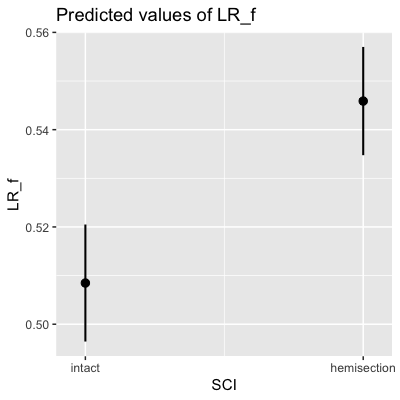

In [34]:
%%R -i dft -w 4 -h 4 --units in -r 100

mod0<-glmmTMB(LR_f ~ (1+SCI|ID),zi=~0,disp=~SCI, data=dft, family=gaussian(link = "identity"))
mod1<-glmmTMB(LR_f ~ SCI + (1+SCI|ID),zi=~0,disp=~SCI, data=dft, family=gaussian(link = "identity"))

print(anova(mod0,mod1))
print(emmeans(mod1, ~SCI,data=dft,component='cond')) 

print(plot_model(mod1,type='pred'))

## Figure 6: Speed-dependent gait expression after recovery from a contusion injury
### Figure 6A: Example bout

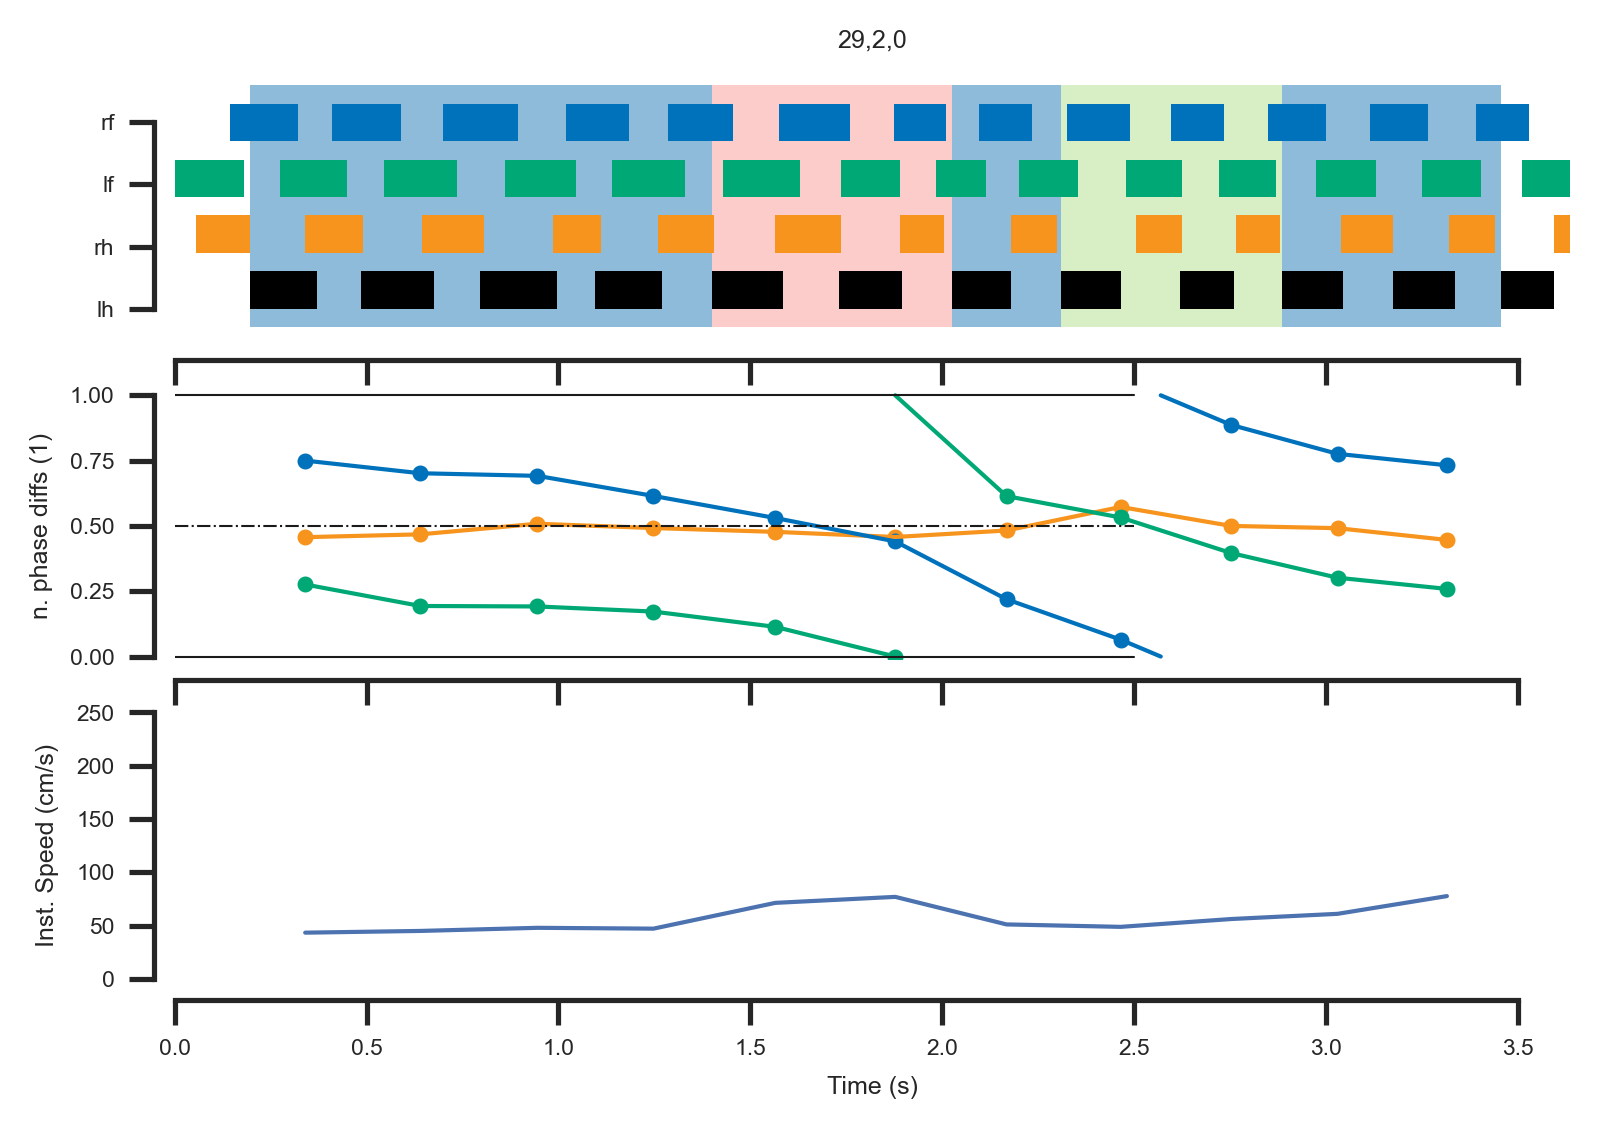

In [35]:
plot_bout(29,2,0);

### Figure 6 B-E: Boxenplots of speed, frequency, stride length, and duty factor for each gait

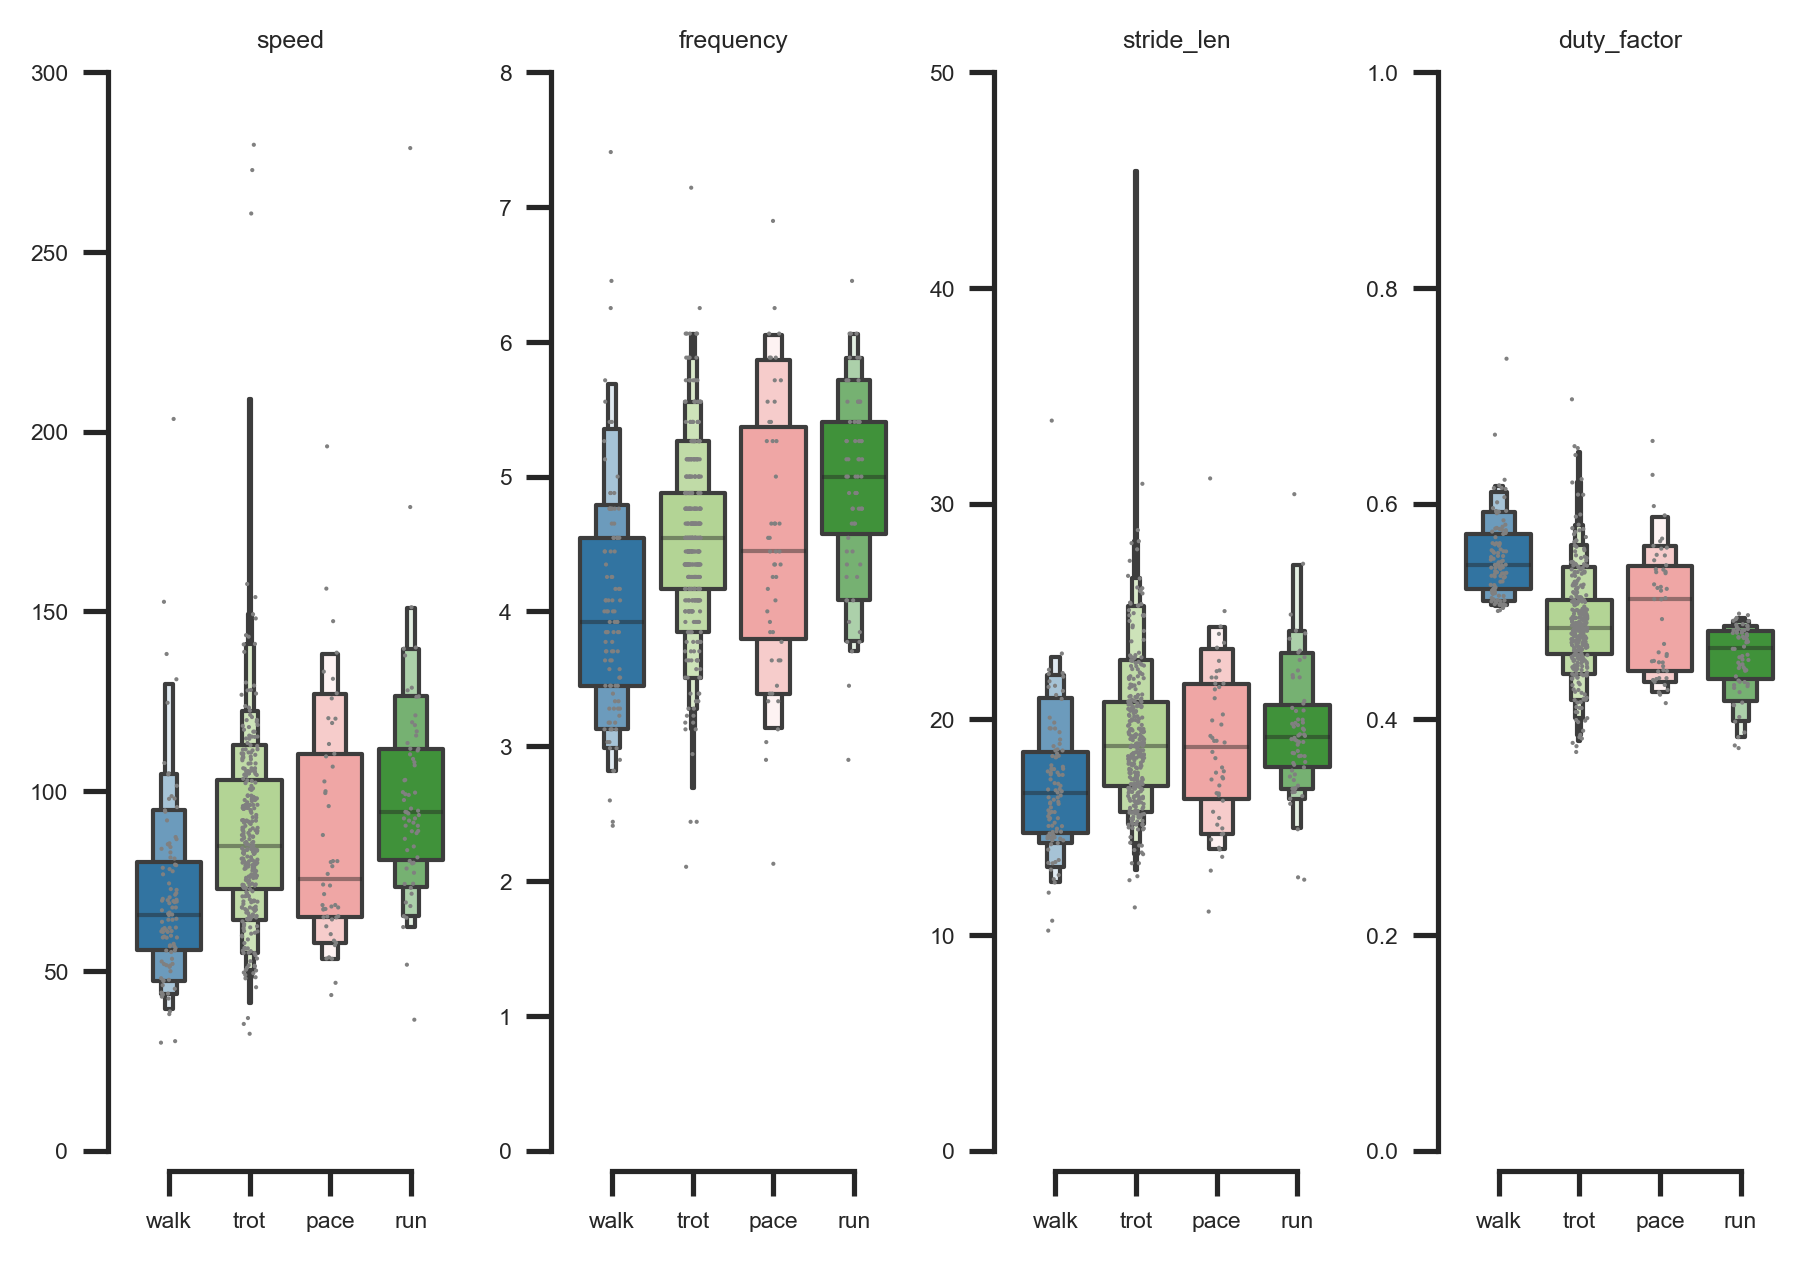

In [36]:
cp_=sns.color_palette("Paired", 20)
cp=cp_[1:]
cp[2]=cp_[4]
cp[3]=cp_[3]

sci ='contusion'

df = df_phases.loc[(df_phases.SCI == sci),['ID','gaits','frequency','speed','stride_len','duty_factor']].dropna()
gaits_= pd.Categorical(
        [np.nan]*len(df.gaits), ['walk', 'trot','pace','run'])
gaits_[df.gaits=='walk']='walk'
gaits_[df.gaits=='trot']='trot'
gaits_[df.gaits=='pace']='pace'
gaits_[df.gaits=='run']='run'
pl=['speed','frequency','stride_len','duty_factor']
ylims=[[0,300],[0,8],[0,50],[0,1],[0,1]]  
fig, ax = plt.subplots(1,4)
fig.set_size_inches(6, 4., forward=True)
plt.tight_layout()
for a,p,yl in zip(ax,pl,ylims):
    a = sns.boxenplot(
            y=df[p],x=gaits_,
            palette=cp,ax=a,linewidth=1,showfliers=False,k_depth='trustworthy')
    #a = sns.swarmplot(y=df[p],x=gaits_,color='0.5',ax=a,size=1,linewidth=0)
    a = sns.stripplot(y=df[p],x=gaits_,
                   size=1, jitter=True,linewidth=0, color="gray",ax=a)
    a.set_ylim(yl)
    a.set_title(p)
    a.set_ylabel("")
sns.despine(offset=5, trim=True) 

df['gaits_']=gaits_

Linear mixed model fit by REML ['lmerMod']
Formula: speed ~ gaits_ + (1 | ID)
   Data: df

REML criterion at convergence: 5045.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4277 -0.5026 -0.1093  0.3675  7.5047 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 303.9    17.43   
 Residual             666.5    25.82   
Number of obs: 540, groups:  ID, 7

Fixed effects:
            Estimate Std. Error t value
(Intercept)   75.062      7.091  10.585
gaits_trot    15.203      2.985   5.093
gaits_pace     7.382      4.675   1.579
gaits_run     14.201      4.372   3.248

Correlation of Fixed Effects:
           (Intr) gts_tr gts_pc
gaits_trot -0.307              
gaits_pace -0.217  0.454       
gaits_run  -0.237  0.515  0.391
 model term df1    df2 F.ratio p.value
 gaits_       3 531.42   9.140  <.0001

$emmeans
 gaits_ emmean   SE   df lower.CL upper.CL
 walk     75.1 7.09 7.49     58.5     91.6
 trot     90.3 6.80 6.32     73.8    106.7
 pace

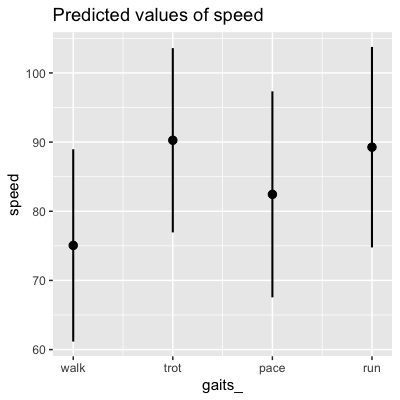

In [37]:
%%R -i df -w 4 -h 4 --units in -r 100
mod1 <- lmer(speed ~ gaits_ + (1|ID) ,data=df)

print(summary(mod1))

print(joint_tests(mod1))
emm_ = emmeans(mod1,pairwise ~gaits_,data=df)
print(emm_) 
print(contrast(emmeans(mod1,~gaits_), "consec"))

print(plot_model(mod1,type='pred'))

Linear mixed model fit by REML ['lmerMod']
Formula: frequency ~ gaits_ + (1 | ID)
   Data: df

REML criterion at convergence: 994.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4324 -0.5095  0.0387  0.5369  4.0959 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 0.3688   0.6073  
 Residual             0.3450   0.5874  
Number of obs: 540, groups:  ID, 7

Fixed effects:
            Estimate Std. Error t value
(Intercept)  4.17728    0.23716  17.614
gaits_trot   0.37835    0.06795   5.568
gaits_pace   0.21779    0.10652   2.045
gaits_run    0.35547    0.09962   3.568

Correlation of Fixed Effects:
           (Intr) gts_tr gts_pc
gaits_trot -0.209              
gaits_pace -0.148  0.453       
gaits_run  -0.162  0.514  0.392
 model term df1    df2 F.ratio p.value
 gaits_       3 530.65  10.728  <.0001

$emmeans
 gaits_ emmean    SE   df lower.CL upper.CL
 walk     4.18 0.237 6.63     3.61     4.74
 trot     4.56 0.233 6.14     3.99     5.12

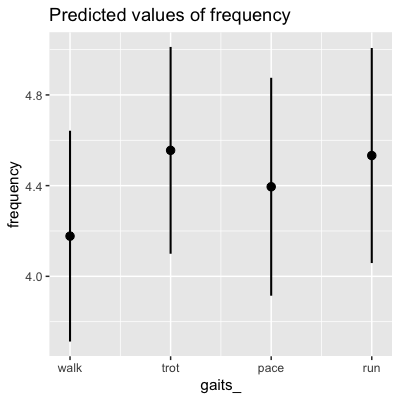

In [38]:
%%R -i df -w 4 -h 4 --units in -r 100

mod1 <- lmer(frequency ~ gaits_ + (1|ID) ,data=df)

print(summary(mod1))
print(joint_tests(mod1))
emm_ = emmeans(mod1,pairwise ~gaits_,data=df)
print(emm_) 

print(plot_model(mod1,type='pred'))

Linear mixed model fit by REML ['lmerMod']
Formula: stride_len ~ gaits_ + (1 | ID)
   Data: df

REML criterion at convergence: 3415.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6240 -0.4404 -0.1722  0.1969  8.1356 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept)  1.293   1.137   
 Residual             32.615   5.711   
Number of obs: 540, groups:  ID, 7

Fixed effects:
            Estimate Std. Error t value
(Intercept)  17.8889     0.7176  24.930
gaits_trot    1.6950     0.6569   2.580
gaits_pace    1.0384     1.0169   1.021
gaits_run     1.7559     0.9484   1.851

Correlation of Fixed Effects:
           (Intr) gts_tr gts_pc
gaits_trot -0.675              
gaits_pace -0.466  0.467       
gaits_run  -0.509  0.523  0.378
 model term df1    df2 F.ratio p.value
 gaits_       3 492.95   2.346  0.0720

$emmeans
 gaits_ emmean    SE    df lower.CL upper.CL
 walk     17.9 0.720 22.82     16.4     19.4
 trot     19.6 0.563  8.09     18.3    

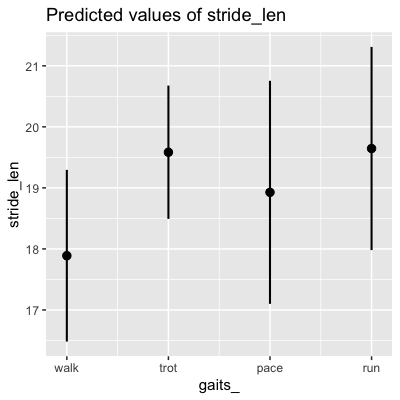

In [39]:
%%R -i df -w 4 -h 4 --units in -r 100

mod1 <- lmer(stride_len ~ gaits_ + (1|ID),data=df)

print(summary(mod1))
print(joint_tests(mod1))
emm_=emmeans(mod1,pairwise ~gaits_,data=df)
print(emm_) 

print(plot_model(mod1,type='pred'))

Linear mixed model fit by REML ['lmerMod']
Formula: duty_factor ~ gaits_ + (1 | ID)
   Data: df

REML criterion at convergence: -1884

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0945 -0.5954 -0.1039  0.5163  4.8942 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 0.000664 0.02577 
 Residual             0.001621 0.04026 
Number of obs: 540, groups:  ID, 7

Fixed effects:
             Estimate Std. Error t value
(Intercept)  0.541551   0.010563  51.270
gaits_trot  -0.057575   0.004655 -12.368
gaits_pace  -0.037065   0.007289  -5.085
gaits_run   -0.063839   0.006816  -9.366

Correlation of Fixed Effects:
           (Intr) gts_tr gts_pc
gaits_trot -0.321              
gaits_pace -0.228  0.454       
gaits_run  -0.248  0.515  0.391
 model term df1    df2 F.ratio p.value
 gaits_       3 531.57  55.583  <.0001

$emmeans
 gaits_ emmean     SE    df lower.CL upper.CL
 walk    0.542 0.0106  7.67    0.517    0.566
 trot    0.484 0.0101  6.36    0

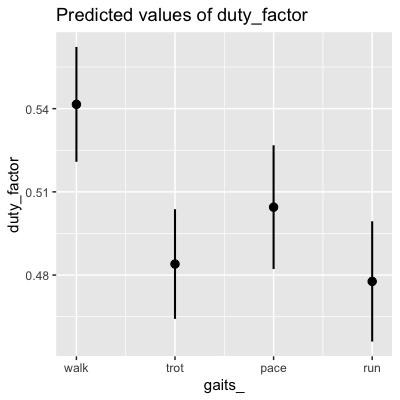

In [40]:
%%R -i df -w 4 -h 4 --units in -r 100 -o emm

mod1 <- lmer(duty_factor ~ gaits_ + (1|ID) ,data=df)

print(summary(mod1))
print(joint_tests(mod1))
emm_=emmeans(mod1,pairwise ~gaits_,data=df)
print(emm_) 
print(plot_model(mod1,type='pred'))

### Figure 6F-H: (F) Average stance phases; (G) circular plots of average normalized phase differences; and (H) average foot position for each gait of contused animals

walk_lat  	LR=0.484+-0.039, HL=0.268+-0.079, diag=0.740+-0.083
walk_diag 	LR=0.496+-0.072, HL=0.723+-0.063, diag=0.242+-0.076
trot      	LR=0.513+-0.058, HL=0.480+-0.057, diag=0.993+-0.070
pace      	LR=0.483+-0.091, HL=0.036+-0.074, diag=0.483+-0.071
run_lat   	LR=0.462+-0.038, HL=0.308+-0.071, diag=0.798+-0.071
run_diag  	LR=0.480+-0.058, HL=0.703+-0.093, diag=0.236+-0.083


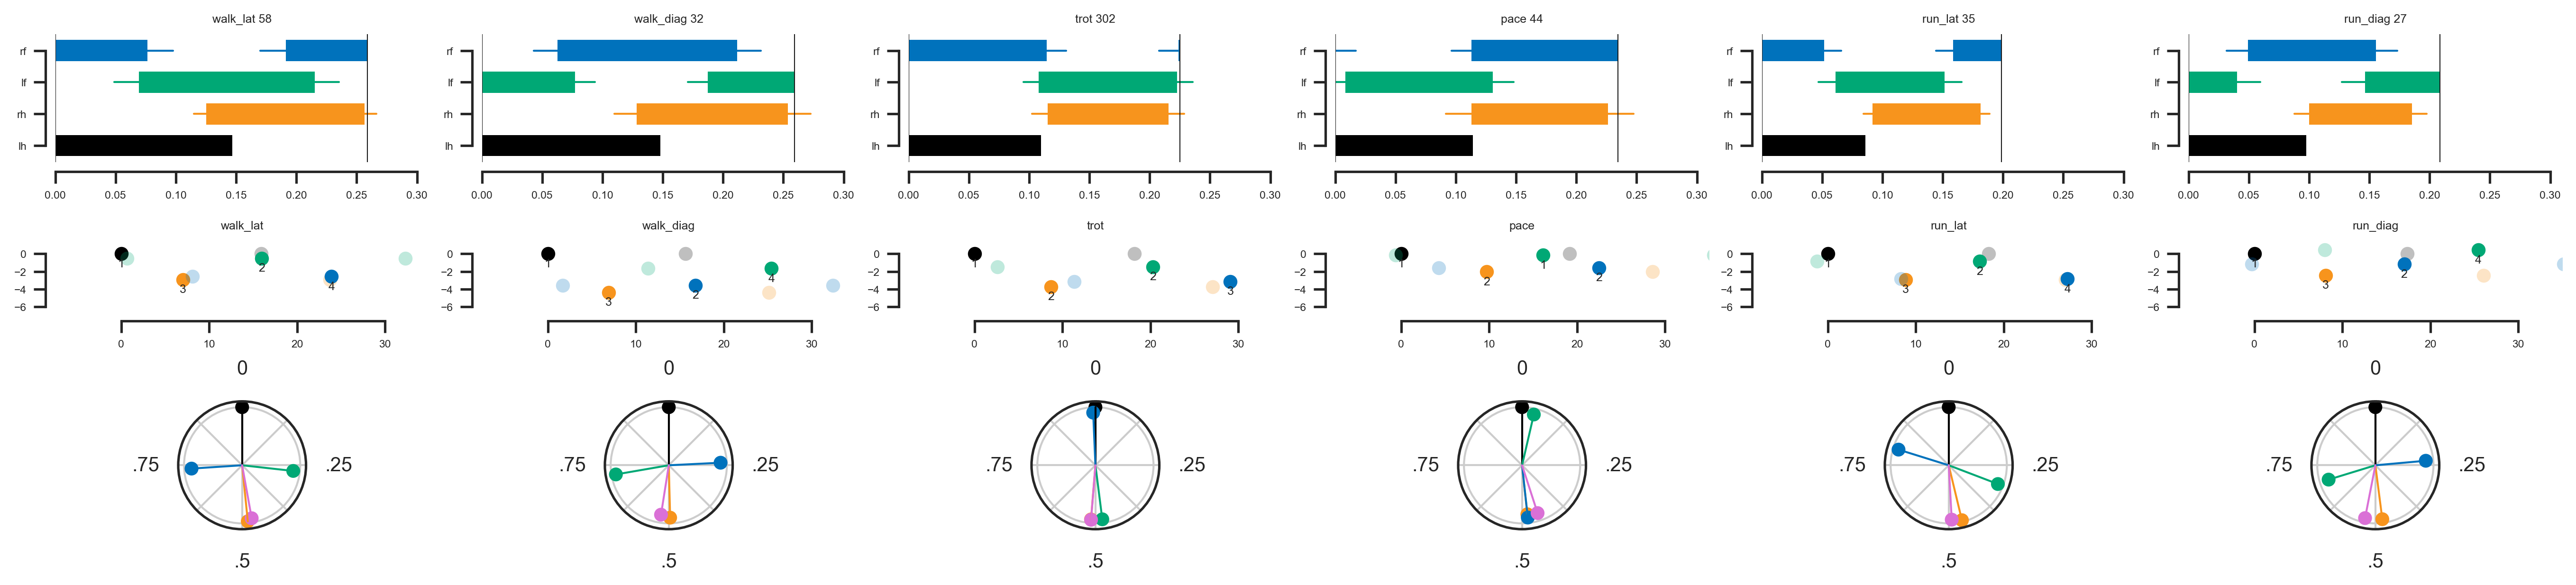

In [41]:
fig = plot_gait_properties('contusion', ['walk_lat','walk_diag','trot','pace','run_lat','run_diag'])

### Figure 6---figure supplement 1: Number of limbs on the ground as a proportion of the step cycle for each gait

          nolimb   onelimb   twolimb  threelimb  fourlimb
gaits_                                                   
walk    0.000000  0.064426  0.706535   0.219438  0.009602
trot    0.009594  0.112539  0.800284   0.071479  0.006104
pace    0.016110  0.116918  0.729054   0.125616  0.012302
run     0.002790  0.196850  0.734816   0.064045  0.001499


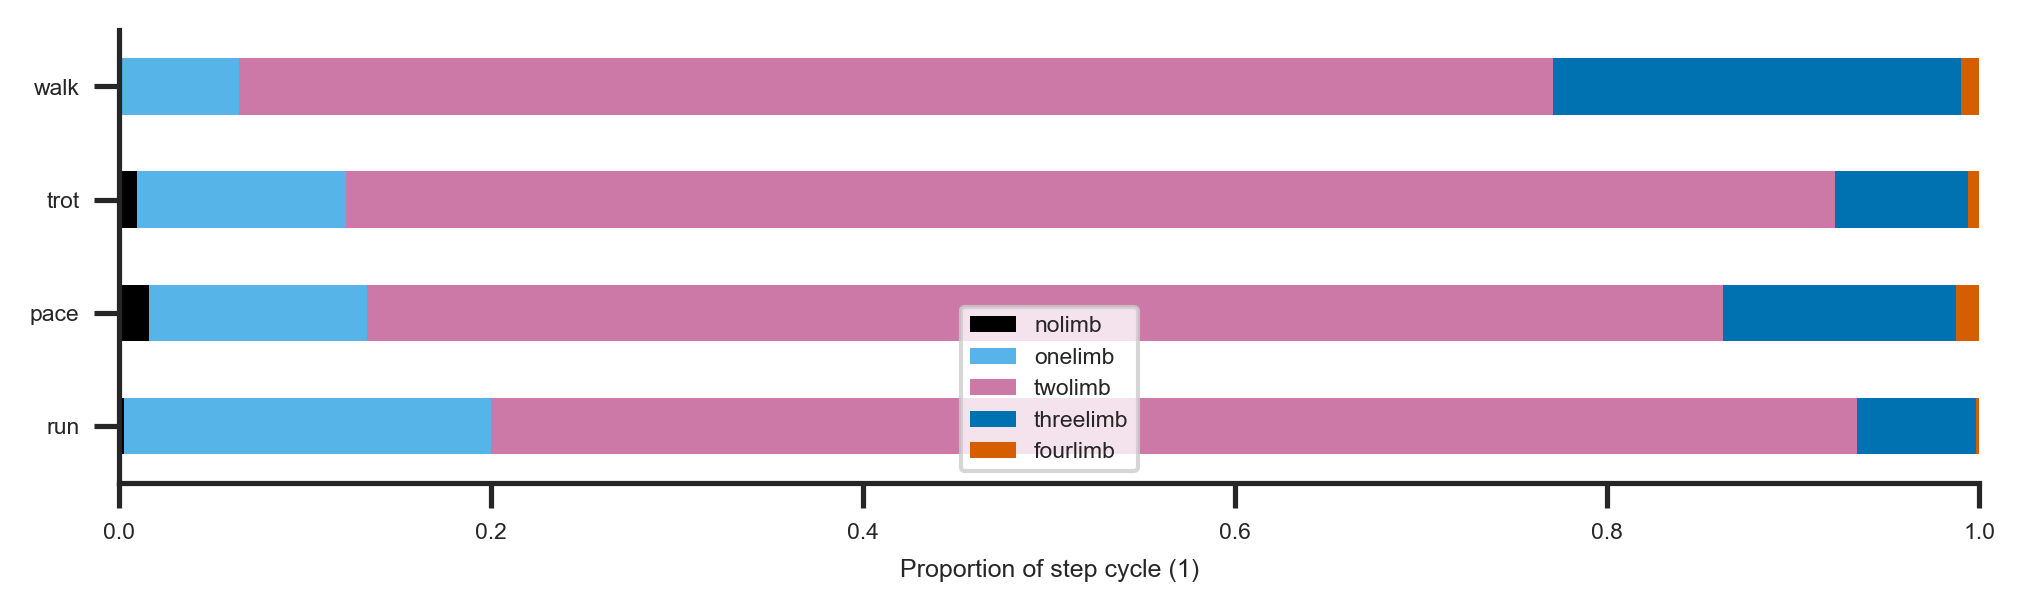

In [42]:
df_ = df_phases[df_phases.SCI=='contusion']
df_['gaits_']=df.gaits_

fig = plt.figure()
fig.set_size_inches(8,2)
group=df_[['gaits_','nolimb','onelimb','twolimb','threelimb','fourlimb']].groupby(['gaits_'])
print(group.mean())
group.mean().plot.barh(stacked=True,color= colormap[[0,2,7,5,6,4]],lw=0,ax=plt.gca())
plt.xlim([0,1])
sns.despine()
plt.gca().invert_yaxis()
plt.gca().set_ylabel("")
plt.gca().set_xlabel("Proportion of step cycle (1)");


## Figure 7: Speed-dependent distribution of normalized phase differences of intact (A), hemisected (B), and contused (C) animals.

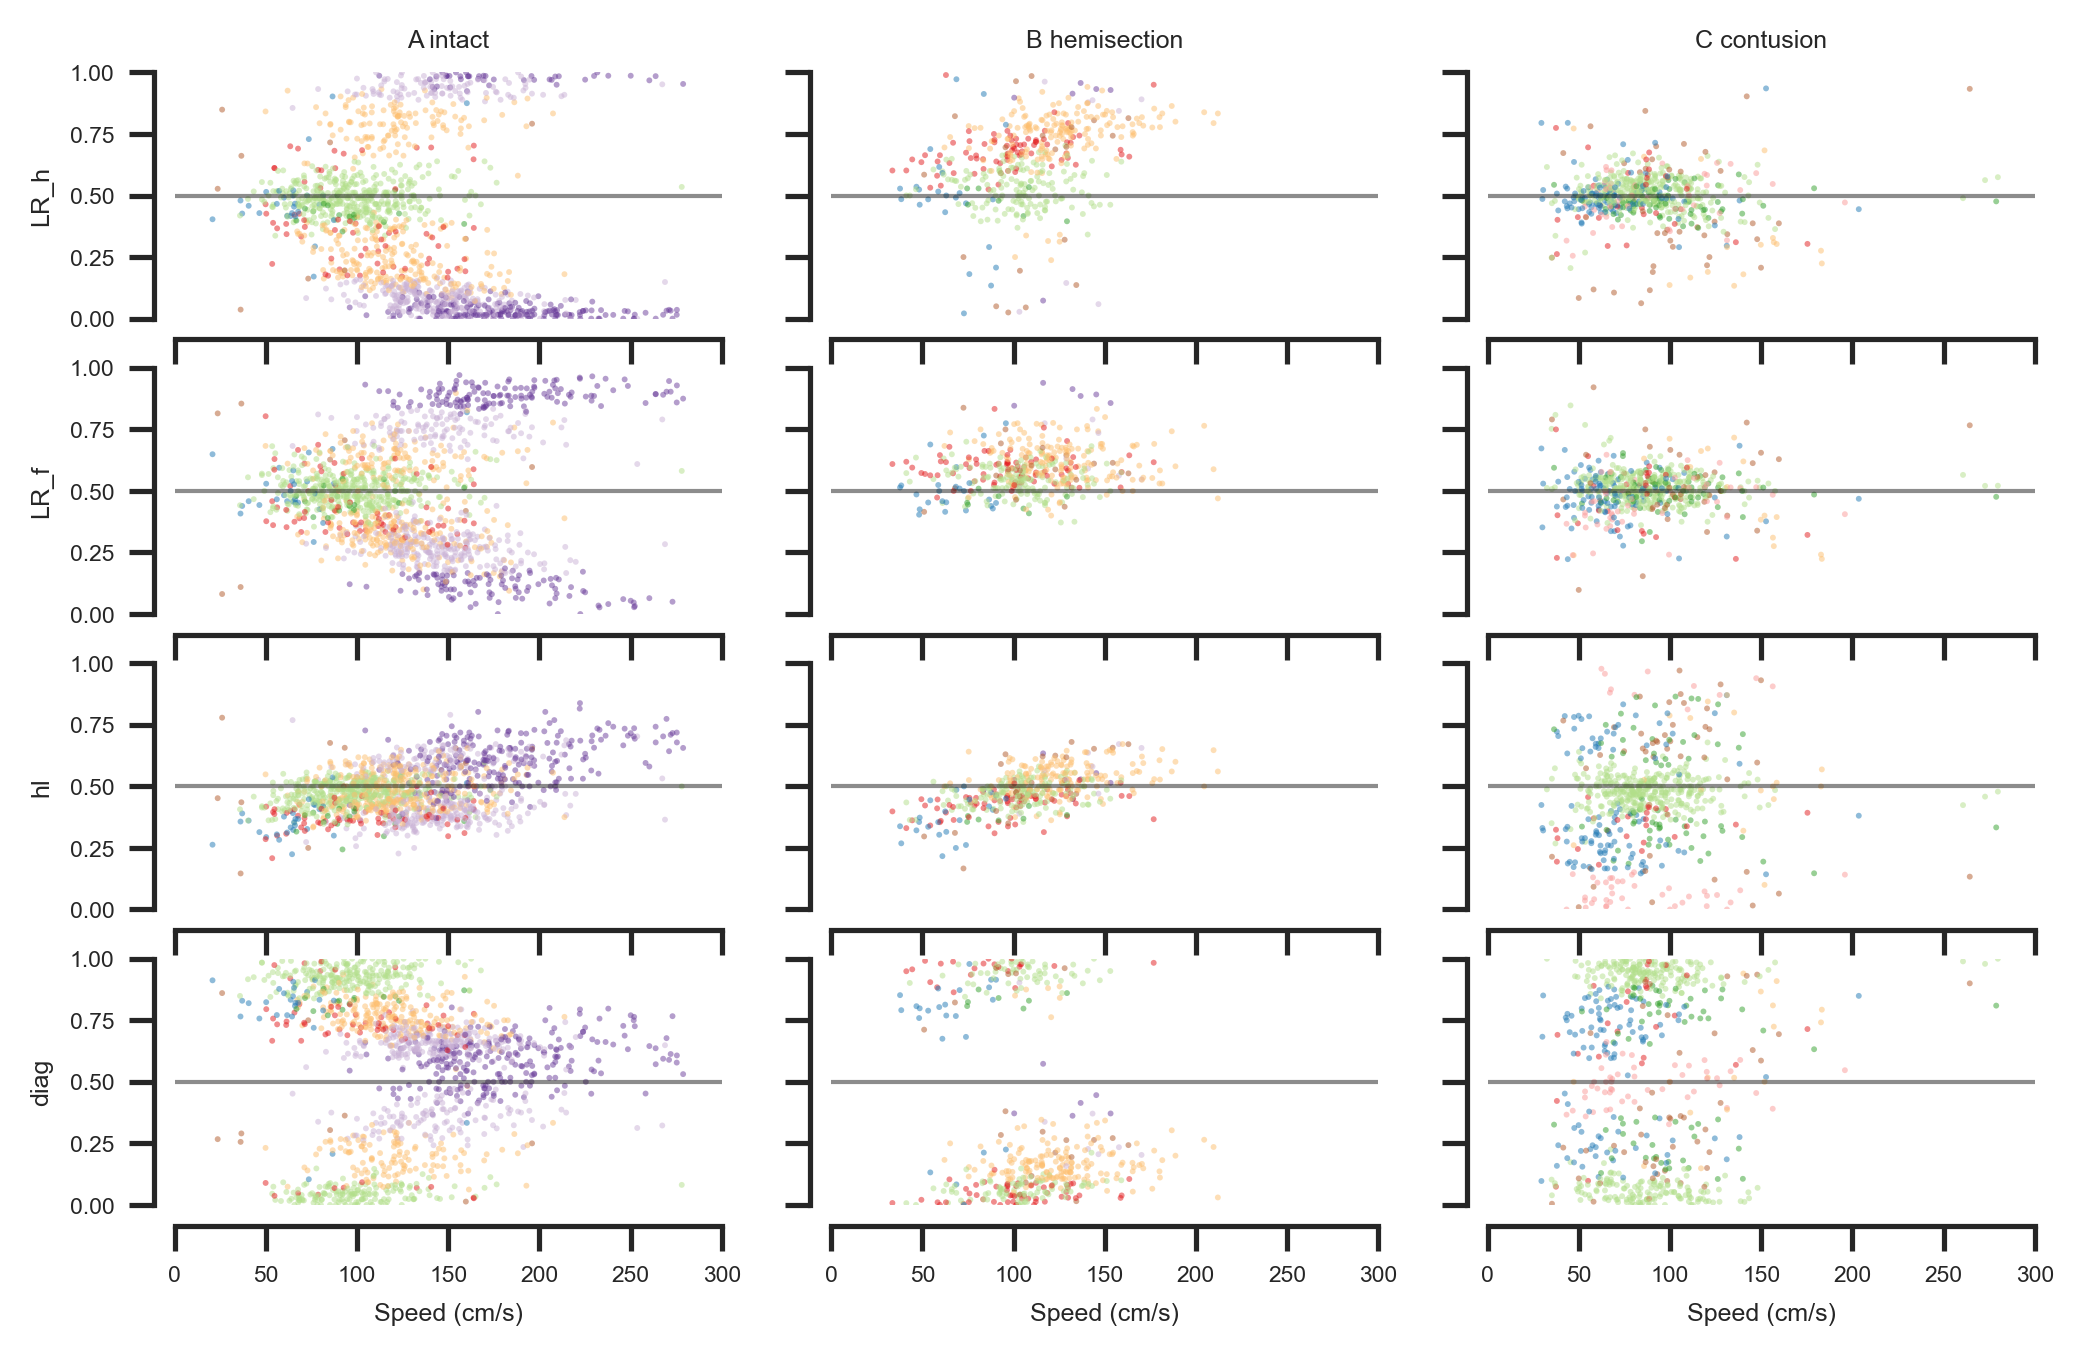

In [43]:
cp=sns.color_palette("Paired", 20)
cp[0]=cp[11]
cp.pop(7)
abc=['A','B','C']
x_col, x_lim, bw = ('speed', (0.0, 300.0), (10., 0.05)) #('frequency', (2.0, 8.0), (0.35, 0.05))
fig, ax = plt.subplots(4, 3, sharex='all', sharey='all')
fig.set_size_inches(8., 5., forward=True)
for (j, phased) in enumerate(['LR_h', 'LR_f', 'hl', 'diag']):
    
    for (i, sci) in enumerate(pd.unique(df_phases.SCI)):
        df_sci = df_phases.loc[df_phases.SCI == sci, [x_col, phased,'gaits']]
        df_sci = df_sci.dropna()
        col = [cp[k] for k in df_sci.gaits.cat.codes.values]
        ax[j, i].scatter(df_sci[x_col],df_sci[phased],c=col,alpha=0.5,s=2,lw=0)
        plt.setp(ax[j, i].artists, lw=1)#
        ax[j, i].plot(x_lim,[0.5,0.5],'k',lw=1,alpha=0.5)
        ax[j, i].set_xlim(x_lim)
        ax[j, i].set_ylim((0.0, 1.0))
        ax[j, i].set_yticks([0,0.25,0.5,0.75,1.0])
        if j == 0:
            ax[j, i].set_title(abc[i]+" " +sci)
        if i == 0:
            ax[j, i].set_ylabel(phased)
        if j==3:
            ax[j,i].set_xlabel('Speed (cm/s)')
        
sns.despine(offset=5,trim=True )

## Figure 8: Distribution of phase differences in intact rats (A) and after hemisection (B) and contusion injury (C).

In [44]:
trot = np.array([0.4883484085061223, 0.47336071322291484, 0.9751760430532729])
hbound=np.array([0.935816, 0.602606, 0.358777])

ideal_pace = np.array([0.5,0.,0.5])
ideal_trot = np.array([0.5,0.5,0])

b_1=(hbound - trot)%1
b_2=(ideal_pace-ideal_trot)%1

reg_data = {'trot_bound': (b_1,trot,1.,1),
            'trot_pace':  (b_2,ideal_trot,np.sqrt(b_2@b_2))}

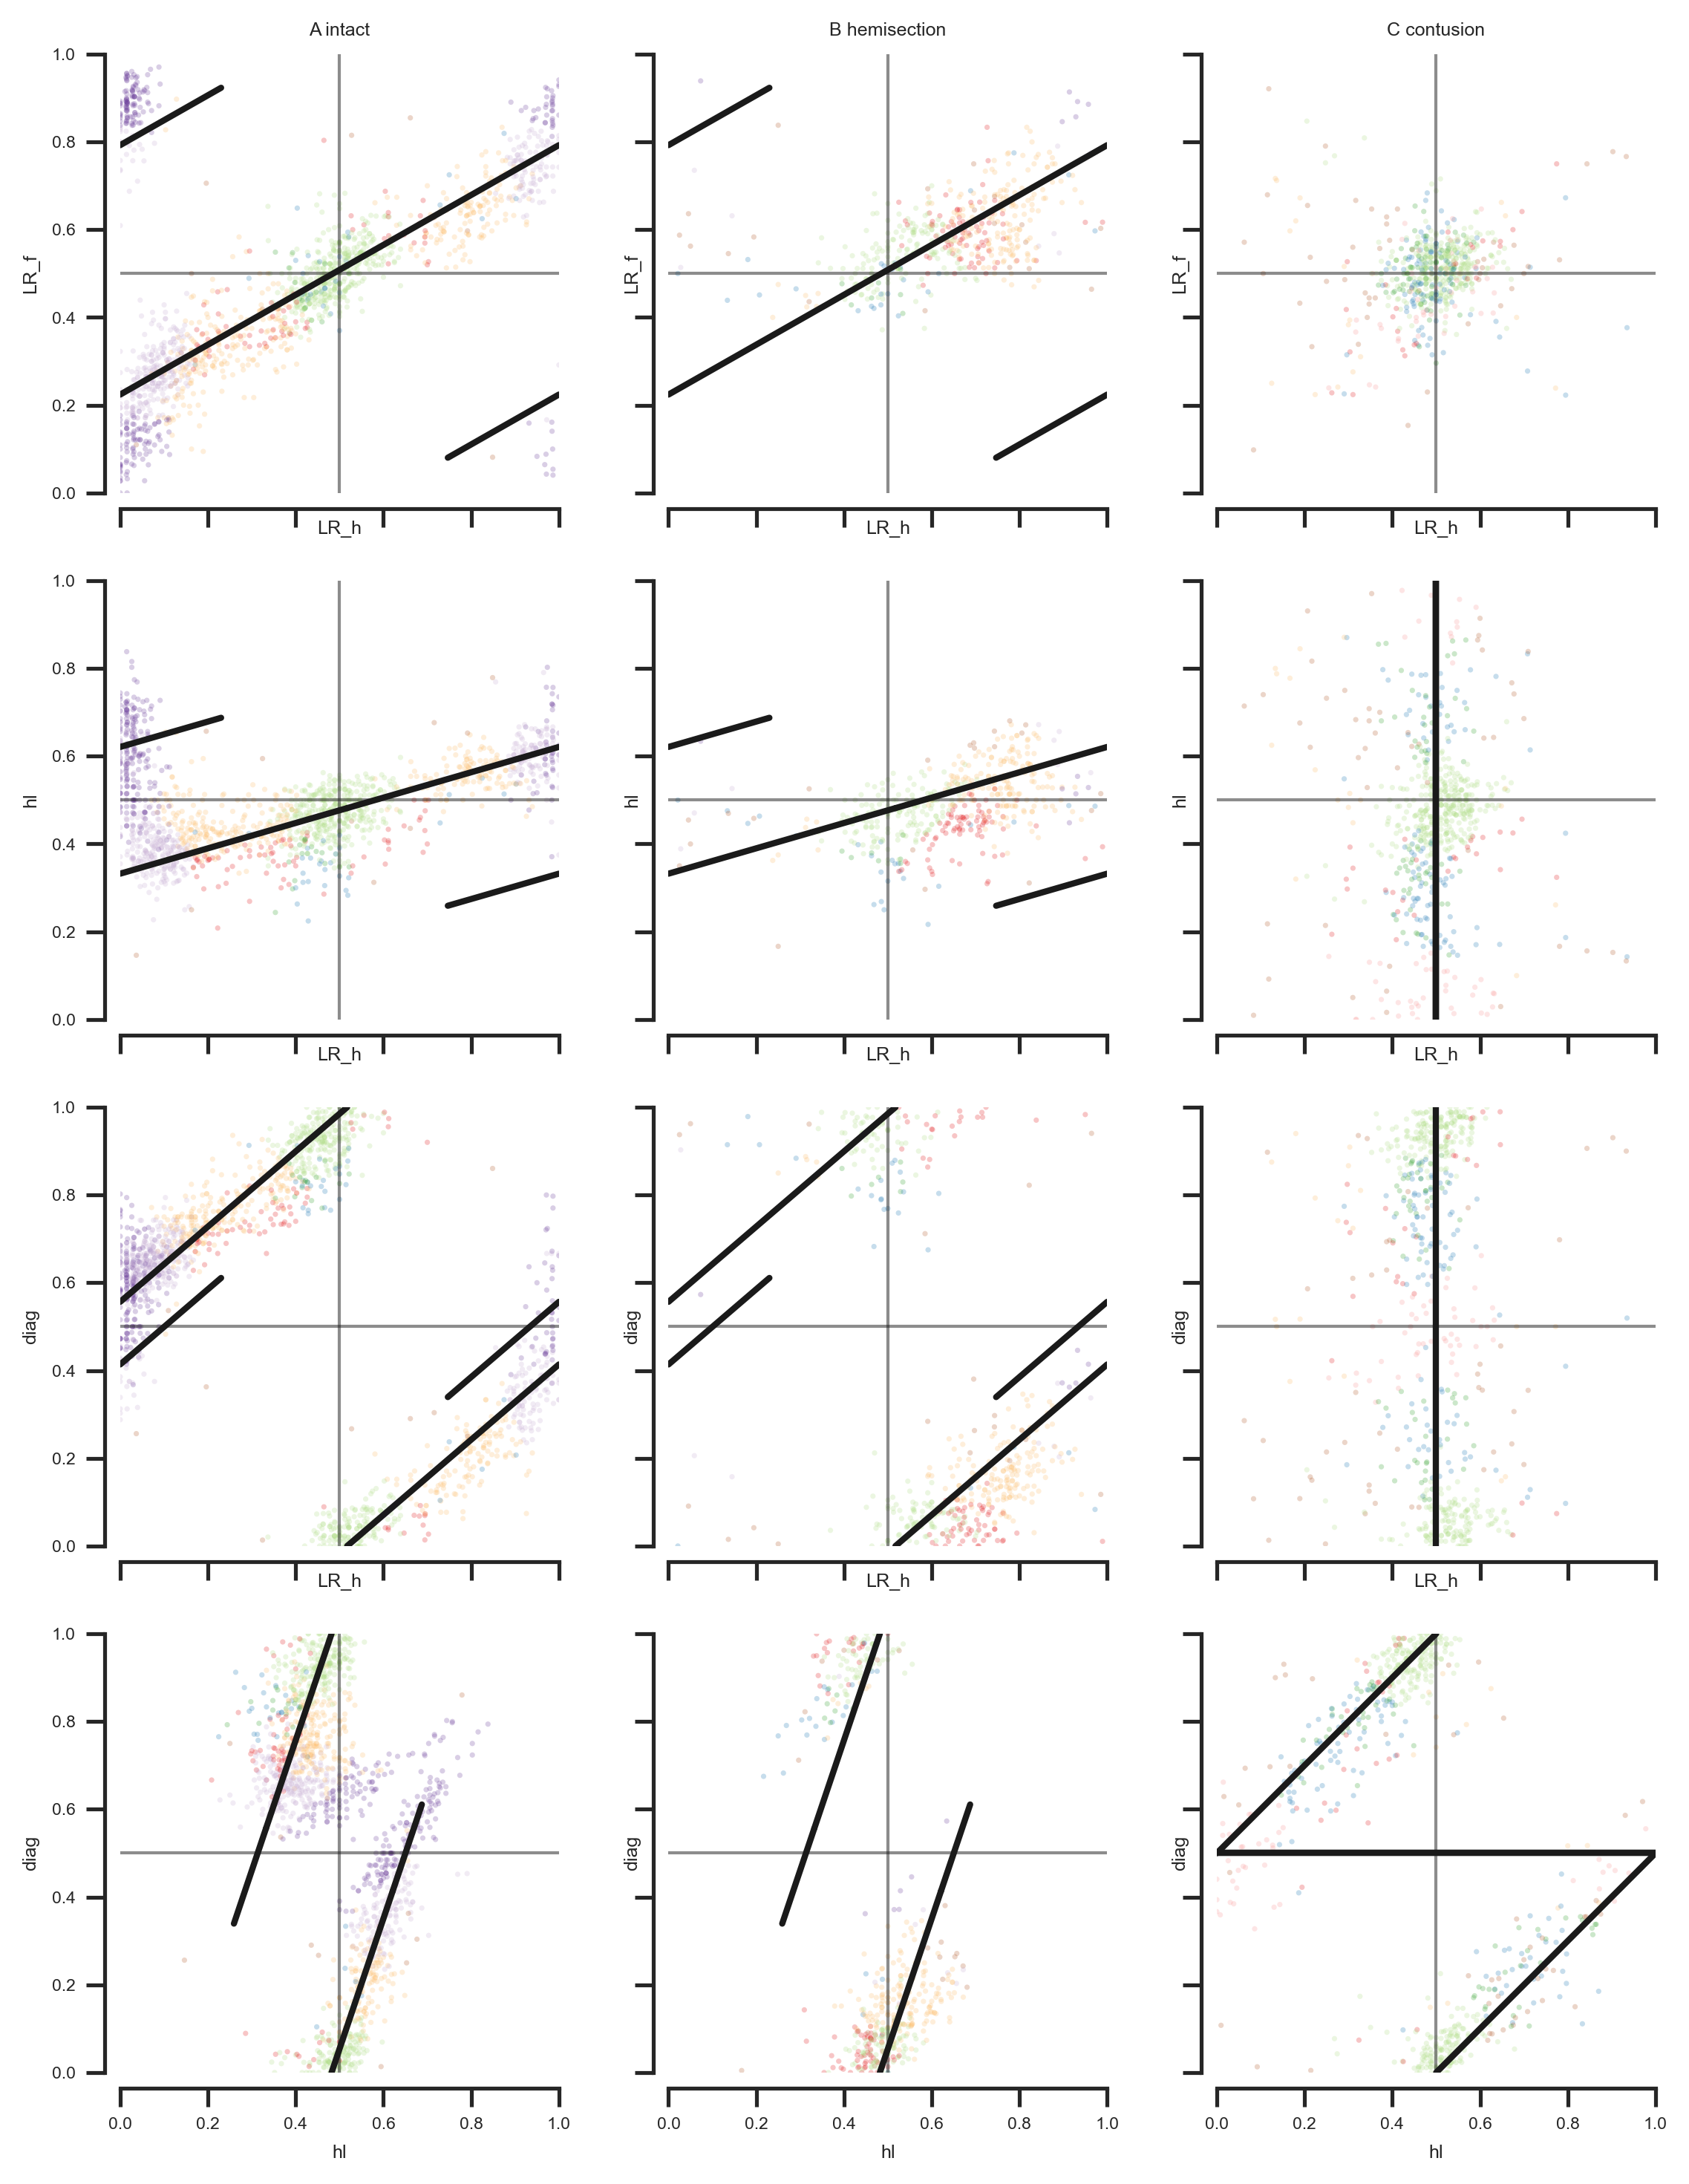

In [45]:
c_factor = 'gaits'
cp=sns.color_palette("Paired", 20)
cp[0]=cp[11]
cp.pop(7)

p_dict={'LR_h':0,'hl':1,'diag':2,'LR_f':3}
eps=0.000000001
fig, ax = plt.subplots(4, 3, sharex='all', sharey='all')
fig.set_size_inches(9., 12, forward=True)
for (j, phasep) in enumerate([('LR_h', 'LR_f'), ('LR_h','hl'), ('LR_h','diag'), ('hl','diag')]):
    for (i, (sci,reg_)) in enumerate(zip(pd.unique(df_phases.SCI),['trot_bound','trot_bound','trot_pace'])):
        df_sci = df_phases.loc[(df_phases.SCI == sci), [phasep[0], phasep[1],c_factor]]
        df_sci = df_sci.dropna()
        
        col = [cp[k] for k in df_sci.gaits.cat.codes.values]
        ax[j, i].plot([0,1],[0.5,0.5],'k',lw=1,alpha=0.5)
        ax[j, i].plot([0.5,0.5],[0,1],'k',lw=1,alpha=0.5)
        ax[j, i].scatter(df_sci[phasep[0]],df_sci[phasep[1]],c=col,alpha=0.25,s=3,lw=0)
        ax[j, i].set_xlim((0.0, 1.0))
        ax[j, i].set_ylim((0.0, 1.0))
        ax[j, i].set_xlabel(phasep[0])
        ax[j, i].set_ylabel(phasep[1])
        ax[j, i].set_aspect('equal')
        m=reg_data[reg_][1]
        b=reg_data[reg_][0]
        lm_th=reg_data[reg_][2]
        nb=b/np.sqrt(b@b)
        m_ = np.concatenate((m,[m[2]-m[1]]))
        nb_ = np.concatenate((nb,[nb[2]-nb[1]]))
        ks = [-lm_th,lm_th]
        for i_ in range(len(m_)):
            for y0 in [2,-1,0,1,2]:
                if nb_[i_]!=0:
                    ks.append((y0-m_[i_])/nb_[i_])
        ks=np.array(ks)
        ks = ks[np.abs(ks)<=lm_th]
        ks = np.sort(ks)
        for i_ in range(len(ks)-1):
            xy = [[(m_[p_dict[p_]]+ks[i_]*nb_[p_dict[p_]]),(m_[p_dict[p_]]+ks[i_+1]*nb_[p_dict[p_]]-eps)] for p_ in phasep]
            ax[j,i].plot(np.array(xy[0])%1,np.array(xy[1])%1,c='k',lw=2)
        if j == 0:
            ax[j, i].set_title(abc[i]+" " +sci)

sns.despine(offset=5,trim=True )

Calculation of projection of each step onto a line in phase-space

In [46]:
def dist_p_l(x,nb):
    x_ = (x + np.pi) % (2 * np.pi) - np.pi
    return (x_@nb)

def sq_len(x):
    return np.sum(np.angle(np.exp(1j*x))**2)

def AICcalc(LLa,LLb,ka=6,kb=6):
    AICa=2*6-2*LLa
    AICb=2*kb-2*LLb
    x = np.exp(-0.5*(AICb-AICa))
    AICw = 1/(x+1)
    return AICa,AICb,AICw

phases=['LR_h','hl','diag']


def project(b,m,df,lam_th=2*np.pi,offset=np.pi*2):
    b=b*2*np.pi
    m=m*2*np.pi
    b_len=np.sqrt(sq_len(b))
    df=df*np.pi*2
    nb=b/b_len

    lams=list()
    a2lens=list()
    for m_ in [m,m+nb*offset,m-nb*offset]:
        a=df-m_
        lam=np.apply_along_axis(lambda x: dist_p_l(x,nb),1,a)
        a1=np.array(lam).reshape((len(lam),1))*nb
        a2=a-a1
        a2len=np.abs(np.apply_along_axis(lambda x: sq_len(x),1,a2))
        lams.append(lam)
        a2lens.append(a2len)
    lam = lams[0]
    
    a2len = a2lens[0]
    
    l1_ = (a2len>a2lens[1]) & ((lams[1]+offset) < lam_th) & ((lams[1]+offset) > -1*lam_th)
    lam[l1_]=lams[1][l1_]+offset
    a2len[l1_]=a2lens[1][l1_]
    l2_ = (a2len>a2lens[2]) & ((lams[2]-offset) > -1*lam_th) & ((lams[2]-offset) < lam_th)
    lam[l2_]=lams[2][l2_]-offset
    a2len[l2_]=a2lens[2][l2_]
    
    g_mean=circmean(df,axis=0)
    clen=np.abs(np.apply_along_axis(lambda x: sq_len(x),1,df-g_mean))
    R2=1-np.sum(a2len)/np.sum(clen)
    return lam,R2,a2len,a2,clen


gof = []
for case,sci in [['trot_bound',sci] for sci in ['intact','hemisection','contusion']]+[['trot_pace','contusion']]:
    m=reg_data[case][1]
    b=reg_data[case][0]
    lam_th=reg_data[case][2]

    lam,R2,a2len,_,clen=project(b,m,df_phases[df_phases.SCI==sci][phases].dropna())
    LLm =-0.5*len(a2len)*np.log(np.mean(a2len))
    LLb =-0.5*len(clen)*np.log(np.mean(clen))
    gof.append({'SCI':sci,'case':case,'R2':R2,'LLm':LLm,'LLb':LLb})

df_gof=pd.DataFrame(gof)

print('contusion trot_pace vs trot_bound')
AICa,AICb,AICw=AICcalc(df_gof[(df_gof.SCI=='contusion')&(df_gof.case=='trot_pace')].LLm.values[0],df_gof[(df_gof.SCI=='contusion')&(df_gof.case=='trot_bound')].LLm.values[0])
print('AICa={:5.3f}, AICb={:5.3f}, AICw={:5.10f}'.format(AICa,AICb,AICw))

df_gof[['SCI','case','R2']]

contusion trot_pace vs trot_bound
AICa=-337.896, AICb=454.770, AICw=1.0000000000


SCI        case        R2
0       intact  trot_bound  0.937263
1  hemisection  trot_bound  0.737732
2    contusion  trot_bound  0.445764
3    contusion   trot_pace  0.840313

Median and interquartile range of R2 per animal and injury type

In [47]:
gof_id = []
for case,sci in [['trot_bound',sci] for sci in ['intact','hemisection','contusion']]+[['trot_pace','contusion']]:
    m=reg_data[case][1]
    b=reg_data[case][0]
    lam_th=reg_data[case][2]
    for id_,df_id in df_phases[df_phases.SCI==sci].groupby('ID'):
        lam,R2,a2len,_,clen=project(b,m,df_id[phases].dropna())
        LLm =-0.5*len(a2len)*np.log(np.mean(a2len))
        LLb =-0.5*len(clen)*np.log(np.mean(clen))
        gof_id.append({'SCI':sci,'case':case,'ID':id_,'R2':R2,'LLm':LLm,'LLb':LLb})

df_gof_id=pd.DataFrame(gof_id)
df_gof_id

df_gof_id.groupby(['SCI','case']).apply(lambda x:{
        'median':np.median(x.R2),
        'q25':np.percentile(x.R2,25),
        'q75':np.percentile(x.R2,75)}
    ).apply(pd.Series)

median       q25       q75
SCI         case                                    
contusion   trot_bound  0.419483  0.220687  0.452244
            trot_pace   0.819343  0.754379  0.833701
hemisection trot_bound  0.677085  0.607770  0.701570
intact      trot_bound  0.914078  0.805171  0.931219

## Figure 9: Variability of interlimb coordination in intact rats and after hemisection and contusion injury

### Figure 9 A: example bouts. A1: contusion, A2: intact

array([<AxesSubplot:title={'center':'29,2,0'}>,
       <AxesSubplot:ylabel='n. phase diffs (1)'>,
       <AxesSubplot:xlabel='Time (s)', ylabel='Inst. Speed (cm/s)'>],
      dtype=object)

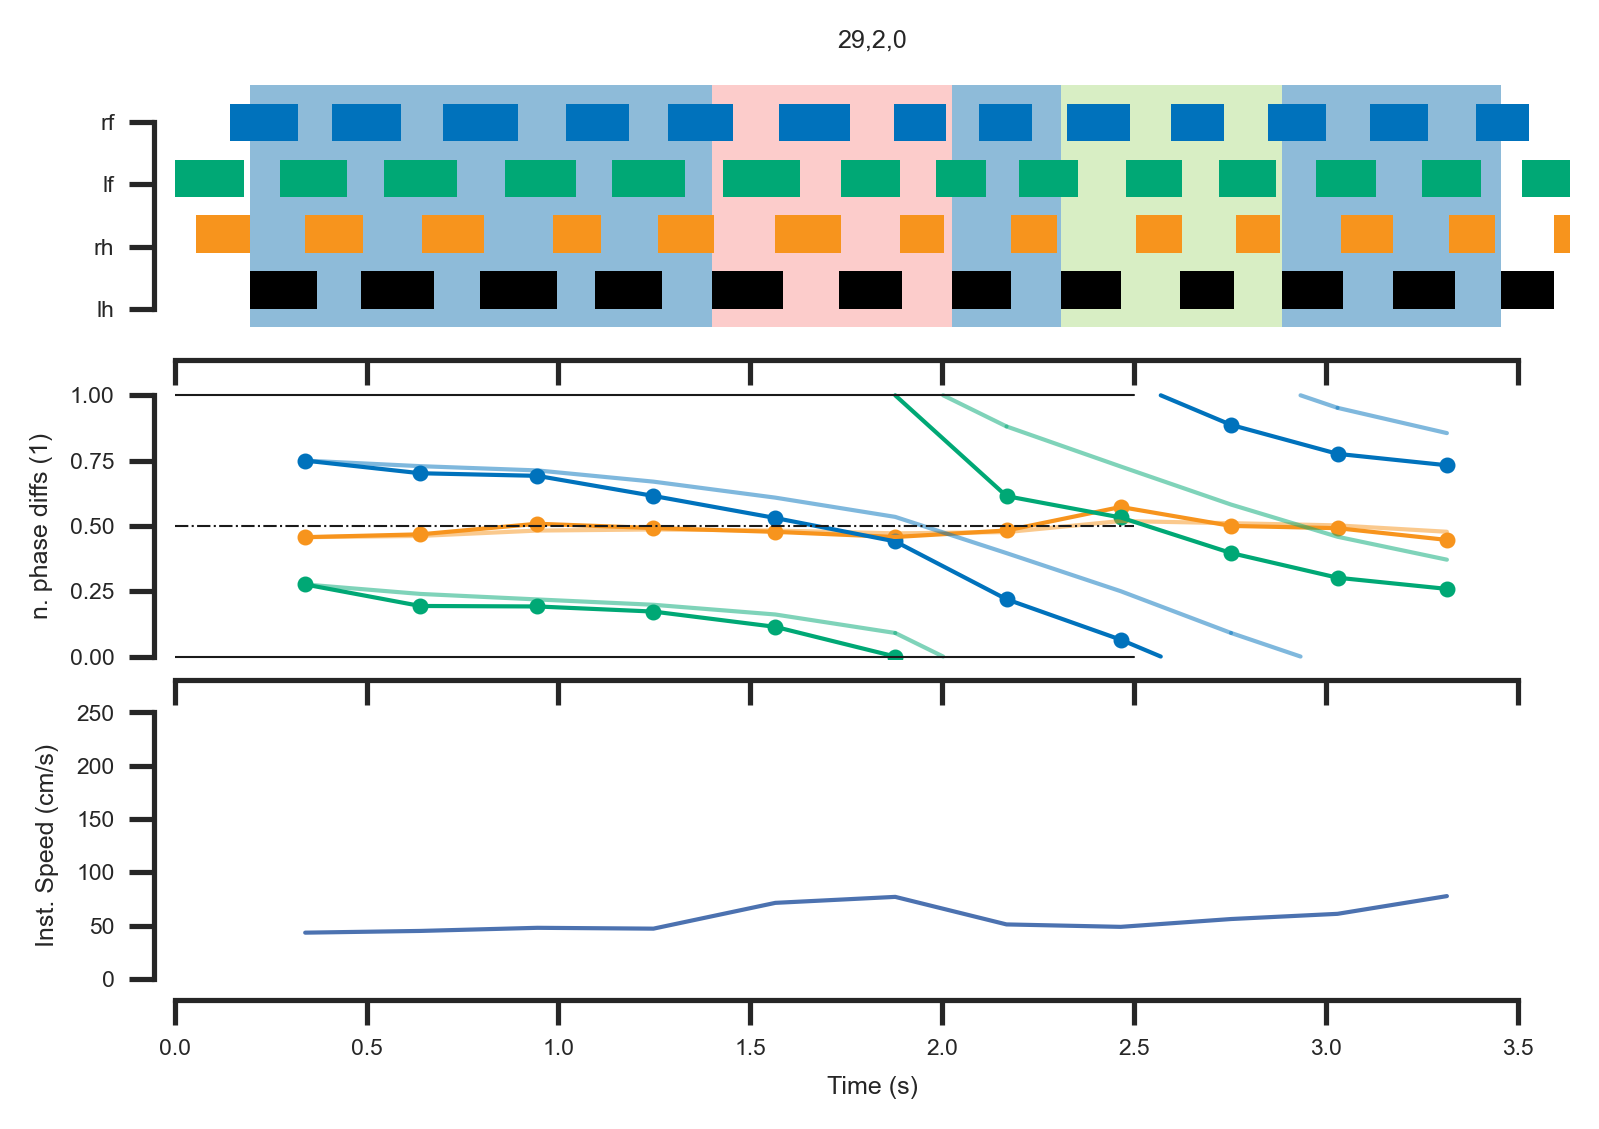

In [48]:
# A1: contusion
plot_bout(29,2,0,True)
#Dark solid lines are the actual normalized phase differences and the lighter colored ones are the moving averages.
#orange: hindlimb left-right normalized phase difference
#green: homolateral normalized phase difference 
#blue: diagonal normalized phase difference

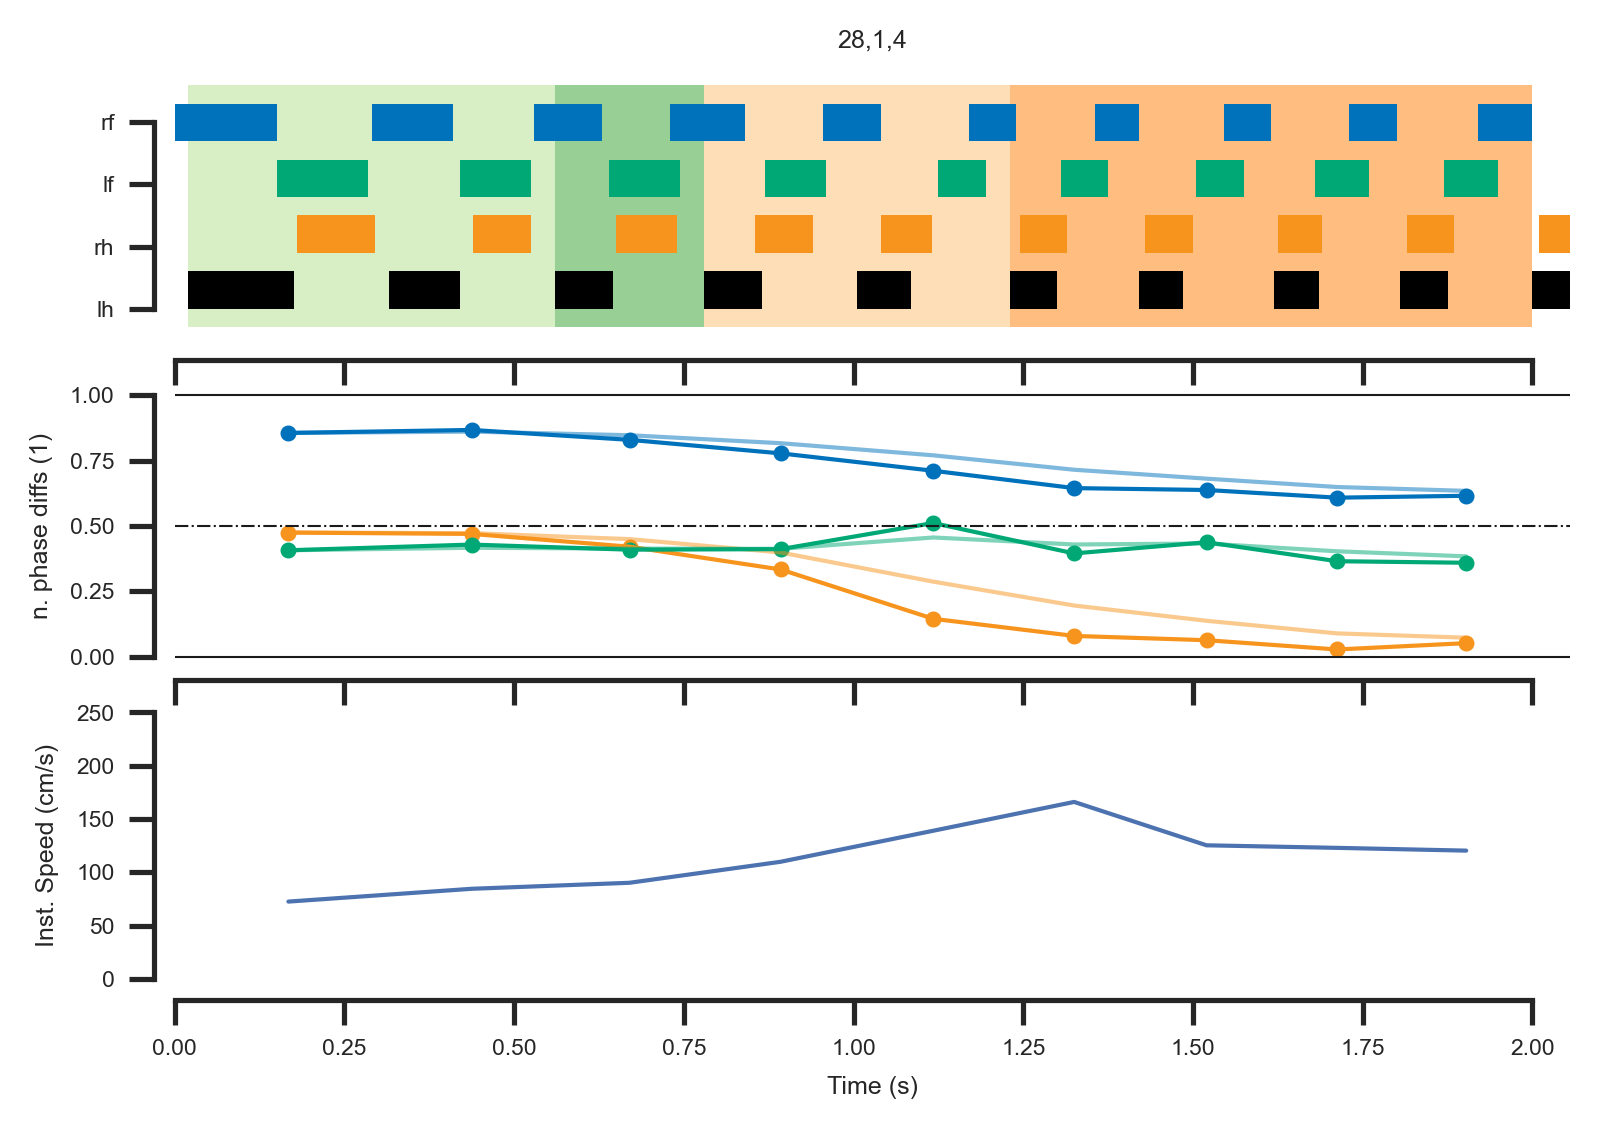

In [49]:
# A2: intact
plot_bout(28,1,4,True);

In [50]:
res_=df_phases.groupby(['SCI','ID','RID','bout']).apply(lambda df:calc_ma_dev(df,0.125)).apply(pd.Series)
res=res_.reset_index()
res2=res.melt(id_vars=['SCI','ID','RID','bout'], var_name='pdiff',value_name='madev')
res2.SCI=pd.Categorical(res2.SCI).reorder_categories(['intact','hemisection','contusion'])
res2.pdiff=pd.Categorical(res2.pdiff,categories=['r_LR_f', 'r_LR_h',  'r_hl', 'r_hl_r','r_diag', 'r_diag_2'])

 Family: beta  ( logit )
Formula:          madev ~ SCI * pdiff + (1 | ID)
Dispersion:             ~SCI * pdiff
Data: res2

     AIC      BIC   logLik deviance df.resid 
 -6798.3  -6597.5   3436.1  -6872.3     1641 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 ID     (Intercept) 0.02608  0.1615  
Number of obs: 1678, groups:  ID, 17

Conditional model:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -2.612433   0.054609  -47.84  < 2e-16 ***
SCIhemisection               -0.179241   0.073324   -2.44 0.014505 *  
SCIcontusion                 -0.057304   0.073687   -0.78 0.436770    
pdiffr_LR_h                   0.034075   0.060700    0.56 0.574551    
pdiffr_hl                    -0.343041   0.054762   -6.26 3.75e-10 ***
pdiffr_hl_r                  -0.190683   0.049927   -3.82 0.000134 ***
pdiffr_diag                   0.042937   0.052338    0.82 0.412003    
pdiffr_diag_2                 0.163288   0.0534

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



$emmeans
 SCI         response      SE   df lower.CL upper.CL
 intact        0.0653 0.00260 1641   0.0604   0.0706
 hemisection   0.0683 0.00337 1641   0.0620   0.0752
 contusion     0.0883 0.00421 1641   0.0804   0.0970

Results are averaged over the levels of: pdiff 
Confidence level used: 0.95 
Intervals are back-transformed from the logit scale 

$contrasts
 contrast                odds.ratio     SE   df null t.ratio p.value
 intact / hemisection         0.953 0.0377 1641    1  -1.227  0.4373
 intact / contusion           0.721 0.0266 1641    1  -8.871  <.0001
 hemisection / contusion      0.757 0.0402 1641    1  -5.247  <.0001

Results are averaged over the levels of: pdiff 
P value adjustment: tukey method for comparing a family of 3 estimates 
Tests are performed on the log odds ratio scale 



R[write to console]: I bet you wanted to call this with just object[[1]] - use '[[]]' or which' if I'm wrong.
See '? emm_list' for more information



$emmeans
 SCI         response      SE   df lower.CL upper.CL
 intact        0.0653 0.00260 1641   0.0604   0.0706
 hemisection   0.0683 0.00337 1641   0.0620   0.0752
 contusion     0.0883 0.00421 1641   0.0804   0.0970

Results are averaged over the levels of: pdiff 
Confidence level used: 0.95 
Intervals are back-transformed from the logit scale 

$contrasts
 contrast                odds.ratio     SE   df lower.CL upper.CL
 intact / hemisection         0.953 0.0377 1641    0.868    1.045
 intact / contusion           0.721 0.0266 1641    0.661    0.786
 hemisection / contusion      0.757 0.0402 1641    0.668    0.857

Results are averaged over the levels of: pdiff 
Confidence level used: 0.95 
Conf-level adjustment: tukey method for comparing a family of 3 estimates 
Intervals are back-transformed from the log odds ratio scale 

$emmeans
pdiff = r_LR_f:
 SCI         response      SE   df lower.CL upper.CL
 intact        0.0683 0.00348 1641   0.0618   0.0755
 hemisection   0.0578 0.0

R[write to console]: I bet you wanted to call this with just object[[1]] - use '[[]]' or which' if I'm wrong.
See '? emm_list' for more information



$emmeans
pdiff = r_LR_f:
 SCI         response      SE   df lower.CL upper.CL
 intact        0.0683 0.00348 1641   0.0618   0.0755
 hemisection   0.0578 0.00402 1641   0.0504   0.0662
 contusion     0.0648 0.00455 1641   0.0564   0.0743

pdiff = r_LR_h:
 SCI         response      SE   df lower.CL upper.CL
 intact        0.0705 0.00406 1641   0.0630   0.0789
 hemisection   0.0889 0.00717 1641   0.0758   0.1040
 contusion     0.0672 0.00557 1641   0.0570   0.0790

pdiff = r_hl:
 SCI         response      SE   df lower.CL upper.CL
 intact        0.0495 0.00264 1641   0.0445   0.0549
 hemisection   0.0393 0.00279 1641   0.0342   0.0452
 contusion     0.0974 0.00801 1641   0.0828   0.1143

pdiff = r_hl_r:
 SCI         response      SE   df lower.CL upper.CL
 intact        0.0572 0.00277 1641   0.0520   0.0628
 hemisection   0.0803 0.00690 1641   0.0677   0.0949
 contusion     0.1029 0.00772 1641   0.0887   0.1191

pdiff = r_diag:
 SCI         response      SE   df lower.CL upper.CL
 intact 

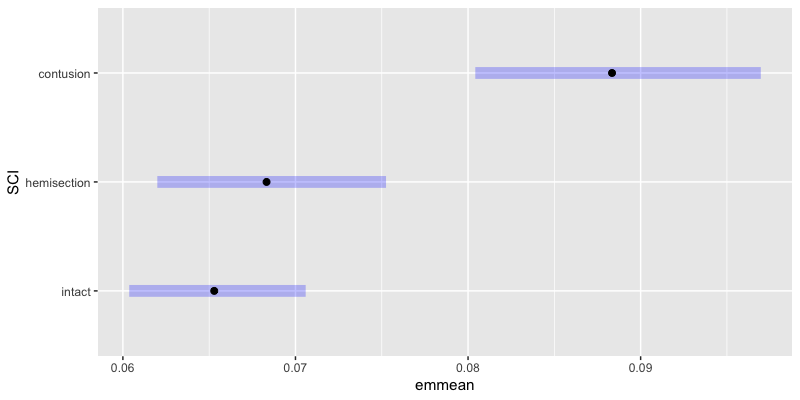

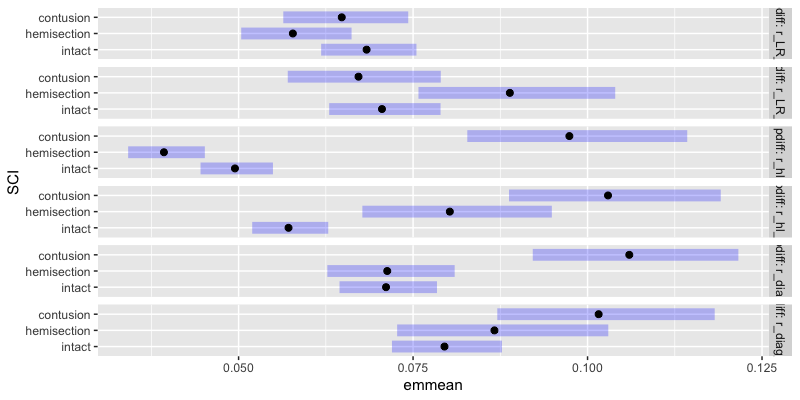

In [51]:
%%R -i res2 -w 8 -h 4 --units in -r 100
library(ggeffects)
library(sjmisc)

mod1<-glmmTMB(madev ~ SCI*pdiff+(1|ID),zi=~0,disp=~SCI*pdiff, data=res2,family=beta_family(link='logit'))
print(summary(mod1))
print(joint_tests(mod1))

em1 = emmeans(mod1,pairwise ~SCI,data=res2,type='response')
print(em1) 
print(plot(em1))
print(confint(em1)) 

em2 = emmeans(mod1,pairwise ~SCI|pdiff,data=res2,type='response')
print(em2) 
print(plot(em2))
print(confint(em2)) 

#print(plot(simulateResiduals(mod1)))

### Figure 9---figure supplement 1

$emmeans
SCI = intact:
 pdiff    response      SE   df lower.CL upper.CL
 r_LR_f     0.0683 0.00348 1641   0.0618   0.0755
 r_LR_h     0.0705 0.00406 1641   0.0630   0.0789
 r_hl       0.0495 0.00264 1641   0.0445   0.0549
 r_hl_r     0.0572 0.00277 1641   0.0520   0.0628
 r_diag     0.0711 0.00356 1641   0.0645   0.0784
 r_diag_2   0.0795 0.00401 1641   0.0720   0.0877

SCI = hemisection:
 pdiff    response      SE   df lower.CL upper.CL
 r_LR_f     0.0578 0.00402 1641   0.0504   0.0662
 r_LR_h     0.0889 0.00717 1641   0.0758   0.1040
 r_hl       0.0393 0.00279 1641   0.0342   0.0452
 r_hl_r     0.0803 0.00690 1641   0.0677   0.0949
 r_diag     0.0713 0.00464 1641   0.0627   0.0810
 r_diag_2   0.0867 0.00769 1641   0.0727   0.1030

SCI = contusion:
 pdiff    response      SE   df lower.CL upper.CL
 r_LR_f     0.0648 0.00455 1641   0.0564   0.0743
 r_LR_h     0.0672 0.00557 1641   0.0570   0.0790
 r_hl       0.0974 0.00801 1641   0.0828   0.1143
 r_hl_r     0.1029 0.00772 1641   0.088

R[write to console]: I bet you wanted to call this with just object[[1]] - use '[[]]' or which' if I'm wrong.
See '? emm_list' for more information



$emmeans
SCI = intact:
 pdiff    response      SE   df lower.CL upper.CL
 r_LR_f     0.0683 0.00348 1641   0.0618   0.0755
 r_LR_h     0.0705 0.00406 1641   0.0630   0.0789
 r_hl       0.0495 0.00264 1641   0.0445   0.0549
 r_hl_r     0.0572 0.00277 1641   0.0520   0.0628
 r_diag     0.0711 0.00356 1641   0.0645   0.0784
 r_diag_2   0.0795 0.00401 1641   0.0720   0.0877

SCI = hemisection:
 pdiff    response      SE   df lower.CL upper.CL
 r_LR_f     0.0578 0.00402 1641   0.0504   0.0662
 r_LR_h     0.0889 0.00717 1641   0.0758   0.1040
 r_hl       0.0393 0.00279 1641   0.0342   0.0452
 r_hl_r     0.0803 0.00690 1641   0.0677   0.0949
 r_diag     0.0713 0.00464 1641   0.0627   0.0810
 r_diag_2   0.0867 0.00769 1641   0.0727   0.1030

SCI = contusion:
 pdiff    response      SE   df lower.CL upper.CL
 r_LR_f     0.0648 0.00455 1641   0.0564   0.0743
 r_LR_h     0.0672 0.00557 1641   0.0570   0.0790
 r_hl       0.0974 0.00801 1641   0.0828   0.1143
 r_hl_r     0.1029 0.00772 1641   0.088

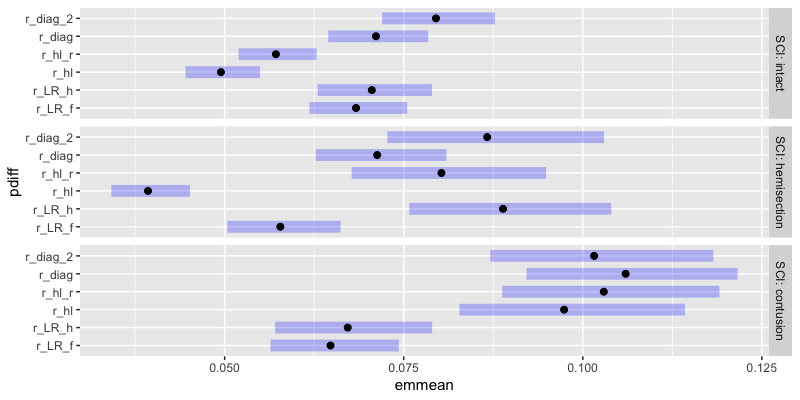

In [52]:
%%R -i res2 -w 8 -h 4 --units in -r 100
em3 = emmeans(mod1,pairwise ~pdiff|SCI,data=res2,type='response')
print(em3) 
print(plot(em3))
print(confint(em3)) 